<a href="https://colab.research.google.com/github/Bode2222/Grapher/blob/main/MathOperatorEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [518]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#dtype = torch.bfloat16
dtype = torch.float32
print(device)

False
cpu


# Goal
Predict the math operation given the inputs and outputs. The network takes in a sequence of 1 to 3 numbers in the order operands, result. The purpose of this is to find a vector representation for 4 math operations and constants in range [-10, 10]. This first version will only encode binary operations and constants.

get `0.005` error on validation. Increasing the number of training sample seems to be the way to go. 5k reached .35 before diverging
15k -> 0.2 error
60

In [519]:
# Output categories: +, -, * , /, c (constants [-10, 10])
MATH_OPERATIONS = {
    0: "Constant",
    1: "Addition",
    2: "Subtraction",
    3: "Multiplication",
    4: "Division"
}
N_CATEGORIES = len(MATH_OPERATIONS)
CONSTANT_INDEX = 0
CONSTANT_MASK = torch.tensor([1, 0, 0, 0, 0], dtype=dtype).to(device)

def is_nullary(index):
  return index == 0

def is_binary(index):
  return index == 1 \
         or index == 2 \
         or index == 3 \
         or index == 4

# Network

In [520]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model).to(device) # Query transformation
        self.W_k = nn.Linear(d_model, d_model).to(device) # Key transformation
        self.W_v = nn.Linear(d_model, d_model).to(device) # Value transformation
        self.W_o = nn.Linear(d_model, d_model).to(device) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [521]:
# Feed forward layer
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_size).to(device)
        self.fc2 = nn.Linear(hidden_size, d_model).to(device)
        self.relu = nn.ReLU().to(device)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [522]:
# Positional encoding
# Encoding the position is important to differentiate operands from results
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model).to(device)
        position = torch.arange(0, max_seq_length, dtype=torch.float, device=device)\
                        .unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() \
                             * -(math.log(10000.0) / d_model))
        div_term = div_term.to(device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
      return x + self.pe[:, :x.size(1)]

# Math Net

## Attention net

In [523]:
# Network

# Stages:
# 0. positional encoding
# 1. Attention
# 2. Feed forward (target_vector_size)
# 3.1 softmax
# 3.2 feed foward, relu (connects to #2 and predicts the constant value if
# constant)

# Try a conv layer on the input sequence

class MathNet(nn.Module):
    def __init__(self, d_model, target_vector_size, dropout, max_seq_length, num_encoders=5, num_layers=5, num_const_layers=5, num_heads=4):
        super(MathNet, self).__init__()
        self.dropout = nn.Dropout(dropout).to(device)
        self.relu = nn.ReLU().to(device) # formerly tanh
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length).to(device)
        self.num_encoders = num_encoders
        self.num_layers = num_layers
        self.num_const_layers = num_const_layers
        self.broadcast = nn.Linear(d_model, target_vector_size)
        self.self_attn = []
        self.layer_norm = []
        for i in range(num_encoders):
          self.self_attn.append(MultiHeadAttention(target_vector_size, num_heads).to(device))
          self.layer_norm.append(nn.LayerNorm(target_vector_size).to(device))
        self.l1 = nn.Linear(max_seq_length * target_vector_size, target_vector_size).to(device)
        self.layers = []
        self.layer_norm2 = []
        for i in range(num_encoders):
          self.layers.append(nn.Linear(target_vector_size, target_vector_size).to(device))
          self.layer_norm2.append(nn.LayerNorm(target_vector_size).to(device))
        self.const_layers = []
        self.layer_norm3 = []
        for i in range(num_const_layers):
          self.const_layers.append(nn.Linear(target_vector_size, target_vector_size).to(device))
          self.layer_norm3.append(nn.LayerNorm(target_vector_size).to(device))
        self.fc0 = nn.Linear(target_vector_size, N_CATEGORIES).to(device)
        self.fc1 = nn.Linear(target_vector_size, d_model).to(device)

    def forward(self, x):
      # removed layer shrinking from d_model to target_vector_size
      x = self.dropout(self.positional_encoding(x))
      x = self.relu(self.broadcast(x))
      for i in range(self.num_encoders):
        attn_out = self.relu(self.self_attn[i](x, x, x))
        x = self.layer_norm[i](attn_out + self.dropout(x))
        ff_out = self.relu(self.layers[i](x))
        x = self.layer_norm2[i](ff_out + self.dropout(x))
      x = nn.Flatten()(x)
      x = self.relu(self.l1(x))
      '''for i in range(self.num_layers):
        ff_out = self.relu(self.layers[i](x))
        x = self.layer_norm2[i](ff_out + self.dropout(x))'''
      y0 = self.fc0(x)
      for i in range(self.num_const_layers):
        x = self.relu(self.const_layers[i](x))
        #x = self.layer_norm3[i](ff_out + self.dropout(x))
      y1 = self.fc1(x)
      return y0, y1

## Conv net

In [524]:
# Network

# Stages:
# 0. positional encoding
# 1. Attention
# 2. Feed forward (target_vector_size)
# 3.1 softmax
# 3.2 feed foward, relu (connects to #2 and predicts the constant value if
# constant)

# Try a conv layer on the input sequence

class MathNet2(nn.Module):
    def __init__(self, d_model, target_vector_size, dropout, max_seq_length, n_conv_layers= 1, channel_size=16):
        super(MathNet2, self).__init__()
        self.relu = nn.ReLU()
        # conv layer, 16 channels
        self.c0 = nn.Conv1d(in_channels=max_seq_length, out_channels=channel_size, \
                            kernel_size=1, dtype=dtype).to(device)
        # conv layer, 8 channels
        self.convs = []
        self.n_conv_layers = n_conv_layers
        self.c1 = nn.Conv1d(in_channels=channel_size, out_channels=channel_size, \
                              kernel_size=1, dtype=dtype).to(device)
        self.c2 = nn.Conv1d(in_channels=channel_size, out_channels=channel_size, \
                              kernel_size=1, dtype=dtype).to(device)
        for i in range(n_conv_layers):
          self.convs.append(nn.Conv1d(in_channels=channel_size, out_channels=channel_size, \
                              kernel_size=1, dtype=dtype).to(device))
        # flat layer
        self.l0 = nn.Linear(channel_size * d_model, target_vector_size, dtype=dtype).to(device)
        # 1 layer for logits, one layer for constant recollection
        self.l1 = nn.Linear(target_vector_size, N_CATEGORIES, dtype=dtype).to(device)
        self.l2 = nn.Linear(target_vector_size, d_model, dtype=dtype).to(device)
        self.att = nn.MultiheadAttention(d_model, 4, dropout=0.1)
        # profit?
        return

    def forward(self, x):
      x = self.relu(self.c0(x))
      #x = self.relu(self.c1(x))
      #x = self.relu(self.c2(x))
      for i in range(self.n_conv_layers):
        x = self.relu(self.convs[i](x))
      x = nn.Flatten()(x)
      x = self.relu(self.l0(x))
      y0 = self.l1(x)
      y1 = self.l2(x)
      return y0, y1

# Notes:
Pytorch does not like for loops


# Samples

In [525]:
N_SAMPLES = 131072 # 10 heads at 10 target vector size is good with 100 samples
# good as in validation follows training, and no overfitting
batch_size = 64 # formerly 16
SPLIT_RATIO = .85 if N_SAMPLES > 1 else 1

# Data

## Float to bits v1

In [526]:
import struct

# too complicated for network learning

def float_to_bits(f):
    # Pack the float into 4 bytes using IEEE 754 format
    packed = struct.pack('!f', f)
    # Unpack as an integer to convert bytes to a single integer value
    as_int = struct.unpack('!I', packed)[0]
    # Format the integer as a binary string, remove the '0b' prefix, and pad with zeros
    bits = f'{as_int:032b}'
    # Convert string to list of bits
    return [int(bit) for bit in bits]

# Example usage:
float_number = 3.14
bits_list = float_to_bits(float_number)
print(bits_list)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]


In [527]:
# TODO: fix this so I can get sensible results back
def bits_to_float(bits):
    # Convert list of bits back to a string
    bit_string = ''.join(str(bit) for bit in bits)
    # Convert binary string to integer
    as_int = int(bit_string, 2)
    # Pack integer as bytes and unpack as float
    packed = struct.pack('!I', as_int)
    # Unpack the bytes to get the float
    return struct.unpack('!f', packed)[0]

# Example usage:
bits_list = float_to_bits(3.14) # This could represent a NaN
float_number = bits_to_float(bits_list)
print(float_number)


3.140000104904175


## Float to bits v2

In [528]:
BASE = 10
# 3.14 (3 before decimal, 14 after decimal (2 decimal places)).
N_DECIMAL_PLACES = 4
N_BEFORE_DECIMAL = 3
# The first bit is the sign
N_BITS_BEFORE_DECIMAL = N_BEFORE_DECIMAL + 1
TOTAL_DIGITS = N_DECIMAL_PLACES + N_BITS_BEFORE_DECIMAL


# Having issue representing small negative nums like those between 0 and -100


def float_to_bits_twos_complement(num):
  bits = [0 for _ in range(TOTAL_DIGITS)]
  # Nan case
  if num != num:
    bits[-1] = -1
    return torch.tensor(bits, dtype=dtype)
  max = BASE ** N_BITS_BEFORE_DECIMAL
  # overflow cse
  if num >= max:
    num = max - 1
  # underflow case
  if num < -max:
    num  = -max
  # Negative case. -771234 = 10000000
  if num < 0:
    num += max
    bits[-1] = 1
  # Normal case
  # 3.14 -> 314
  num = int(num * BASE ** N_DECIMAL_PLACES)
  i = 0
  while int(num) > 0 and i < len(bits):
    bits[i] = int((num%BASE)) / BASE
    num = int(num/BASE)
    i += 1
  return bits
  #return torch.tensor(bits, dtype=dtype)

def bits_to_float_twos_complement(bits):
  if bits[-1] == -1:
    return float('nan')
  total = 0
  coeff = BASE ** (-N_DECIMAL_PLACES + 1)
  for i, bit in enumerate(bits):
    if i == len(bits) - 1:
      coeff = -1 * BASE ** N_BEFORE_DECIMAL
    val = coeff * bit
    #if i == len(bits) - 1:
    #  val *= -1
    print(f"{coeff} * {bit} = {val}")
    total += val
    coeff *= BASE
  return total

x = float('nan')
x = -.5
y = float_to_bits_twos_complement(x)
print(y)
y = bits_to_float_twos_complement(y)
print(x)
print(y)

[0.0, 0.0, 0.0, 0.5, 0.9, 0.9, 0.9, 0.9]
0.001 * 0.0 = 0.0
0.01 * 0.0 = 0.0
0.1 * 0.0 = 0.0
1.0 * 0.5 = 0.5
10.0 * 0.9 = 9.0
100.0 * 0.9 = 90.0
1000.0 * 0.9 = 900.0
-1000 * 0.9 = -900.0
-0.5
99.5


## Float to bits v3

In [529]:
# float to bits v3
import numpy as np
# multiply by base ^ decimal places
# convert to int16
# convert to bits

N_DECIMAL_PLACES = 2
coeff = int(BASE ** N_DECIMAL_PLACES)
itype = np.int16


def float_to_bits_v3(num):
  # nan
  if np.isnan(num):
    num = np.iinfo(itype).min
  num = int(num * coeff)
  # overflow
  if num >= np.iinfo(itype).max:
    num = np.iinfo(itype).max
  # underflow
  elif num <= np.iinfo(itype).min:
    num = np.iinfo(itype).min + 1
  num = itype([num])
  bits = np.unpackbits(num.view(dtype=np.uint8))
  return bits

def bits_to_float_v3(bits):
  num = np.packbits(bits, axis=0).view(dtype=np.int16)
  num = num / coeff
  return num

x = float_to_bits_v3(-.5)
print(x)
y = bits_to_float_v3(x)
print(y)

[1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1]
[-0.5]


## Sample gen

In [530]:
def layer_smoothing(y_hot, alpha = 0.00):
  return (1 - alpha) * y_hot + alpha / N_CATEGORIES

In [531]:
# Data

# Create n samples of data.
# input is 1-3 scaled numbers
# target is a one-hot vector representing the operation
# The 'result' in the input must always be between -10 and 10
# To get 'result', pick 2 numbers in range and calculate what the third must be.
#
# Partition the data into training and test sets
import numpy as np
import struct



# Stuff for network inputs
BASE = 10
GEN_MIN = -100
GEN_MAX = 100


def number_to_network_input(num):
  y = float_to_bits_v3(num)
  #y = float_to_bits(num)
  return torch.tensor(y, dtype=dtype)

def get_null():
  return number_to_network_input(float('nan'))

# 1. generate an N_TOTAL_DIGITS long number
# 2. divide by BASE ** N_DECIMAL_PLACES
def gen_random_num(num_min=GEN_MIN, num_max=GEN_MAX):
  chosen = np.random.uniform(num_min, num_max)
  return chosen

# i.e. the values should be between sqrt(max) and sqrt(min)
# 3. perform calculations to get x1, x2, y
# 4. convert to net input and return
def gen_inputs_and_target1(math_op_index):
  inputs = None
  target1 = None
  if MATH_OPERATIONS[math_op_index] == "Constant":
    chosen = gen_random_num()
    chosen = number_to_network_input(chosen)
    null = get_null()
    inputs = torch.stack((chosen, null, null))
    target1 = chosen
  else:
    assert is_binary(math_op_index), "Unexpected math operator in data gen"
    # pick two random floats in const range
    y = gen_random_num()
    x1 = gen_random_num()
    x2 = None
    # calculate 3rd random float
    if MATH_OPERATIONS[math_op_index] == "Division":
      y = gen_random_num()
      # if the situation is a pain, make this multiplication
      if (y == 0):
        x2 = 0
        math_op_index = 3
      if (x1 == 0):
        x1 = 1
        math_op_index = 3
      else:
        x2 = x1 / y
    elif MATH_OPERATIONS[math_op_index] == "Multiplication":
      x1 = gen_random_num()
      if x1 == 0:
        x1 = 1
      x2 = y / x1
    elif MATH_OPERATIONS[math_op_index] == "Addition":
      x2 = y - x1
    else:
      assert MATH_OPERATIONS[math_op_index] == "Subtraction", \
      "Unrecognized math operation in gen_inputs_and_targets datagen"
      x2 = x1 - y

    x1 = number_to_network_input(x1)
    x2 = number_to_network_input(x2)
    y = number_to_network_input(y)
    inputs = torch.stack((x1, x2, y))
    # assign all 3 to input tuple, let target be 0
    target1 = x1

  # Scale inputs & target1 between accepted range
  return inputs, target1


# TODO: Each input sample should be (batch_size, max_seq_length)

inputs = []
target0 = [] # chosen category
target1 = [] # constant value
for i in range(N_SAMPLES):
  # pick an operation
  math_op_index = np.random.randint(0, N_CATEGORIES)
  # generate the appropriate number of values that represent that operation
  input_tensor, target1_tensor = gen_inputs_and_target1(math_op_index)
  # insert vector of values and category index into appropriate lists
  # each input is a list of input tensors. i.e. a sequence
  math_op_index = torch.tensor(math_op_index, dtype=torch.int64)
  target0.append(\
                 layer_smoothing(\
                                 nn.functional.one_hot(\
                                                       math_op_index,\
                                                       N_CATEGORIES))\
                 .type(dtype))#.to(device))
  target1.append(target1_tensor)#.to(device))
  inputs.append(input_tensor)#.to(device))

# Split lists into train/test set
assert len(inputs) == len(target0), "Inputs must have same size as outputs(0)"
assert len(inputs) == len(target1), "Inputs must have same size as outputs(1)"

inputs = torch.stack(inputs)
target0 = torch.stack(target0)
target1 = torch.stack(target1)

input_len = len(inputs)
n_train = int(input_len * SPLIT_RATIO)
train_input = inputs[:n_train]
train_t1 = target1[:n_train]
train_t0 = target0[:n_train]
test_input = inputs[n_train:]
test_t1 = target1[n_train:]
test_t0 = target0[n_train:]

print(train_t0)
# each input is now of shape [batch_size, seq_len, d_model (embedding dim)]
if SPLIT_RATIO < 1:
  print(f"{train_input[0].shape}")
  print(f"len train: {len(train_input)}, len test: {len(test_input)}")
  print(f"{MATH_OPERATIONS[torch.argmax(train_t0[0][0]).item()]}")
  print(f"{MATH_OPERATIONS[torch.argmax(train_t0[0][1]).item()]}")
  print(f"x1, x2, y: {train_input[0]}")
  print(f"One hot: {train_t0[0]}")
  print(f"Constant: {train_t1[0]}")

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
torch.Size([3, 16])
len train: 111411, len test: 19661
Constant
Constant
x1, x2, y: tensor([[0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
One hot: tensor([0., 0., 1., 0., 0.])
Constant: tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.])


In [532]:
# Create pytorch dataset and dataloader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_input, train_t0, train_t1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = TensorDataset(test_input, test_t0, test_t1)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Training

In [533]:
import matplotlib.pyplot as plt
def plot_train(train_loss, title, val_loss, title2):
  fig = plt.figure(figsize=(12, 8))
  plt.grid(visible=True)
  plt.plot(train_loss, label='train ' + title)
  plt.title("Train " + title)
  plt.plot(val_loss, label='val ' + title)
  plt.title("Val " + title)
  plt.legend()
  plt.show()

In [534]:
# loss_func:
# softmax loss (of #3.1 output) + sum(target_vector * constant_mask) * rms(#3.2)
# where:
# target_vector is the target output of the softmax portion
# constant_mask is the same dimensions for the output which is 1 if that output
# represents a constant and 0 elsewhere
# rms is the root mean square error of the output of 3.2


# y0 is the selection of the math operators
def loss_func(y0, y1, target0, target1, tau=2.5):
  softmax_loss = nn.CrossEntropyLoss()(y0, target0)
  constant_loss = tau * nn.MSELoss()(y1, target1)
  #constant_loss = tau * nn.CrossEntropyLoss()(y1, target1)
  return softmax_loss + constant_loss

In [535]:
# Training loop

def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0
  last_loss = 0
  batches_run = 0
  for i, (input, t0, t1) in enumerate(train_loader):
    optimizer.zero_grad()
    input = input.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    y0, y1 = mathNet(input)
    loss = loss_func(y0, y1, t0, t1)
    loss.backward()
    optimizer.step()
    if i % 1000 == 999:
      print(f"batch / 1000: {batches_run + 1}")
      batches_run += 1
    # Gather data and report
    running_loss += loss.item()
  return running_loss / len(train_loader)

# Run train

In [536]:
# Train the network

# Notes:
# 1. When overfitting, increase the number of samples, you can also get away with
#    a smaller network.
# 2. If you plateau with an error that is too high, add another encoder layer.
#    Be prepared for a flatter graph (slower training)
# 3. Change target_vector size first, larger ones train slower but take less
#    steps to get to the bottom (they overfit faster/easier)

# init network
d_model = np.dtype(itype).itemsize * 8#TOTAL_DIGITS # 32
# Binary op: input0, input1 and output
max_seq_length = 3
dropout = 0.1
# The less the better, but the less parallelism as well (i.e. slower train)
# wrong! setting num_heads = target_vector_size showed surprisingly good perf in
# validation at 10 T_T. Performed worse at 20 with the same number of samples!
# 10 heads with tvs=10 and 100 samples does well!
num_heads = 200
# This can be large, with larger ones learning better (faster) I think
target_vector_size = 128 # 300 before, try making it 600
# Make this too large and you wont see your net train. Even 10 can be too much
# If plateau isn't low enough, add one
# expect training to take longer and the graph to be flatter
# I've noticed that every time you increase training sample by an order of
# magnitude, you might want another one of these: 1e3 samples = 3 encoder layers
num_encoders = 1 # 5 before
num_layers = 10
num_const_layers = 1
'''mathNet = MathNet(d_model=d_model, target_vector_size=target_vector_size,\
                  dropout=dropout, max_seq_length=max_seq_length, \
                  num_encoders=num_encoders, num_layers=num_layers, \
                  num_const_layers=5, num_heads=num_heads)'''
n_conv_layers=3
channel_size=96
target_vector_size = 128 # 300 before, try making it 600
# Uses convnets
mathNet = MathNet2(d_model, target_vector_size, dropout, max_seq_length, n_conv_layers=n_conv_layers, channel_size=channel_size)
mathNet.to(device)
optimizer = optim.Adam(mathNet.parameters(), lr=0.005, betas=(0.9, 0.98), eps=1e-9)
torch.nn.utils.clip_grad_norm_(mathNet.parameters(), max_norm=1.0)


print(d_model)

16


In [537]:
train_loss = []
val_loss = []

EPOCH 1:
batch / 1000: 1
LOSS train 0.6161519935561075 valid 0.4606987535953522


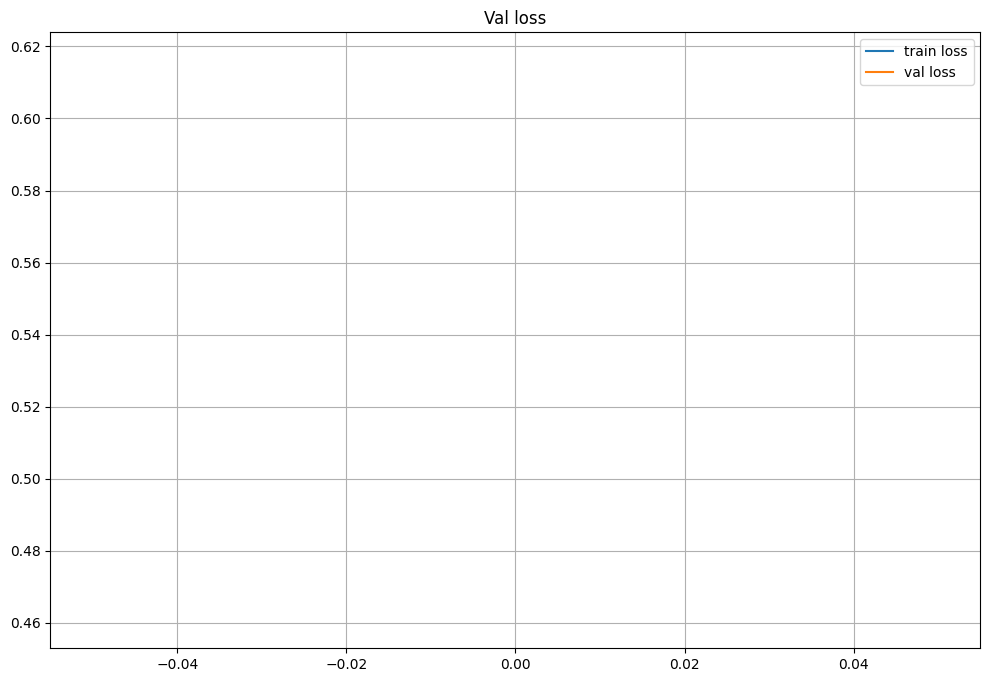

EPOCH 2:
batch / 1000: 1
LOSS train 0.3731005290231097 valid 0.32320547103881836


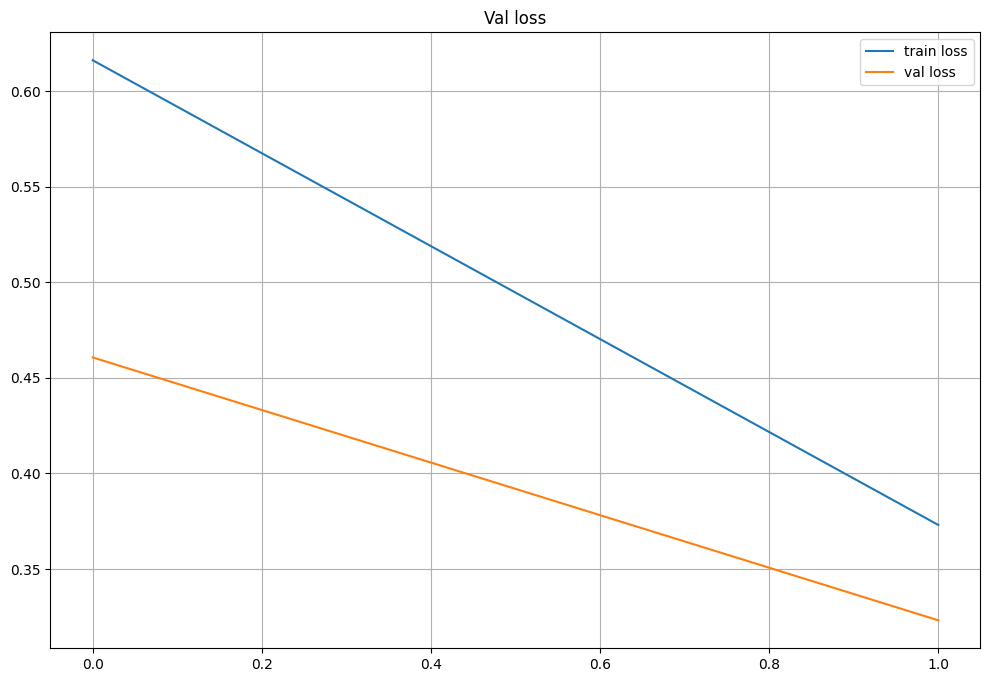

EPOCH 3:
batch / 1000: 1
LOSS train 0.31964036592082823 valid 0.3070816695690155


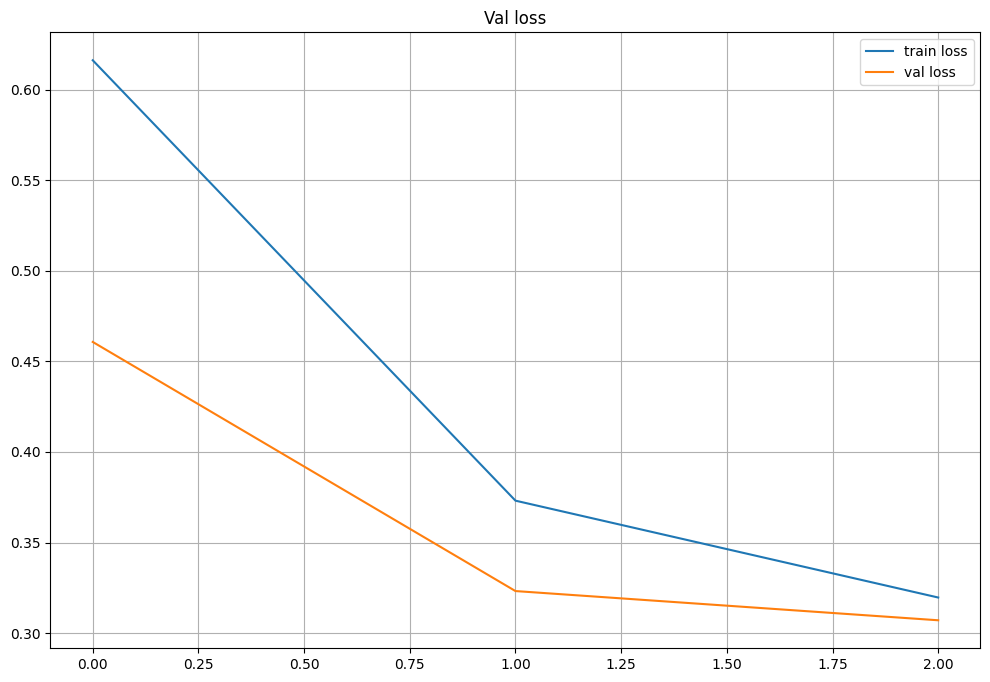

EPOCH 4:
batch / 1000: 1
LOSS train 0.30914930975313915 valid 0.3062126338481903


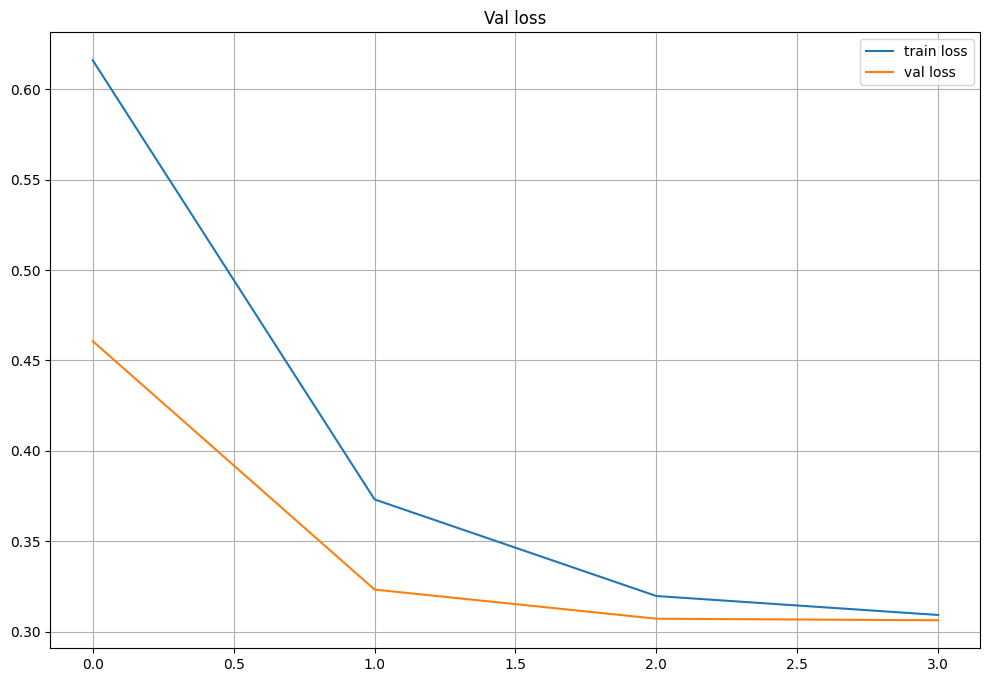

EPOCH 5:
batch / 1000: 1
LOSS train 0.3036104805729021 valid 0.30759888887405396


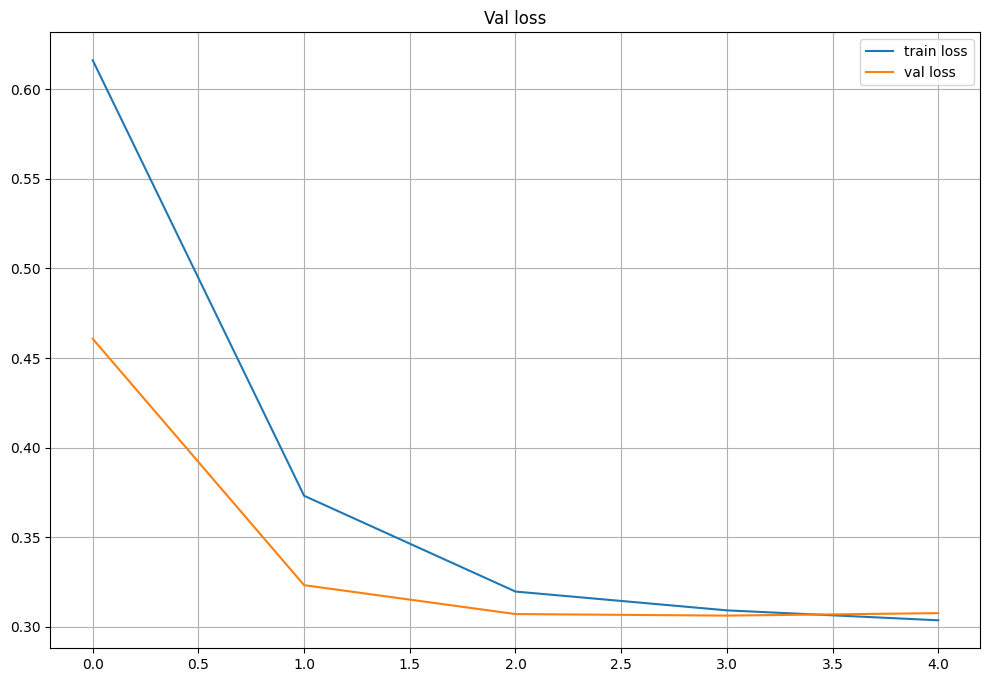

EPOCH 6:
batch / 1000: 1
LOSS train 0.30225074827876464 valid 0.3059351146221161


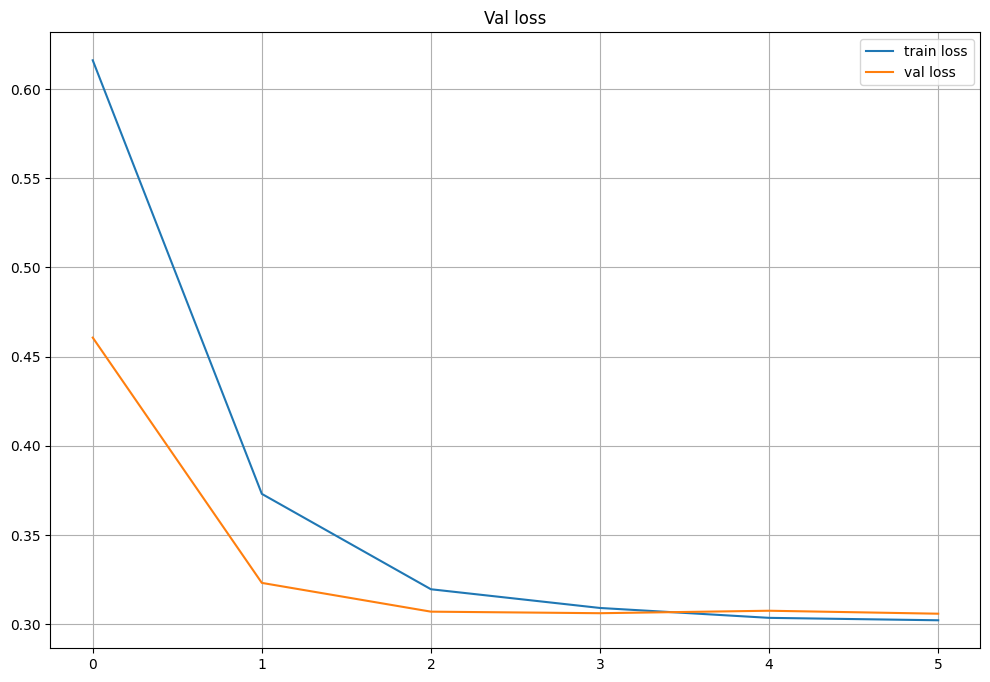

EPOCH 7:
batch / 1000: 1
LOSS train 0.2997836678330067 valid 0.30584797263145447


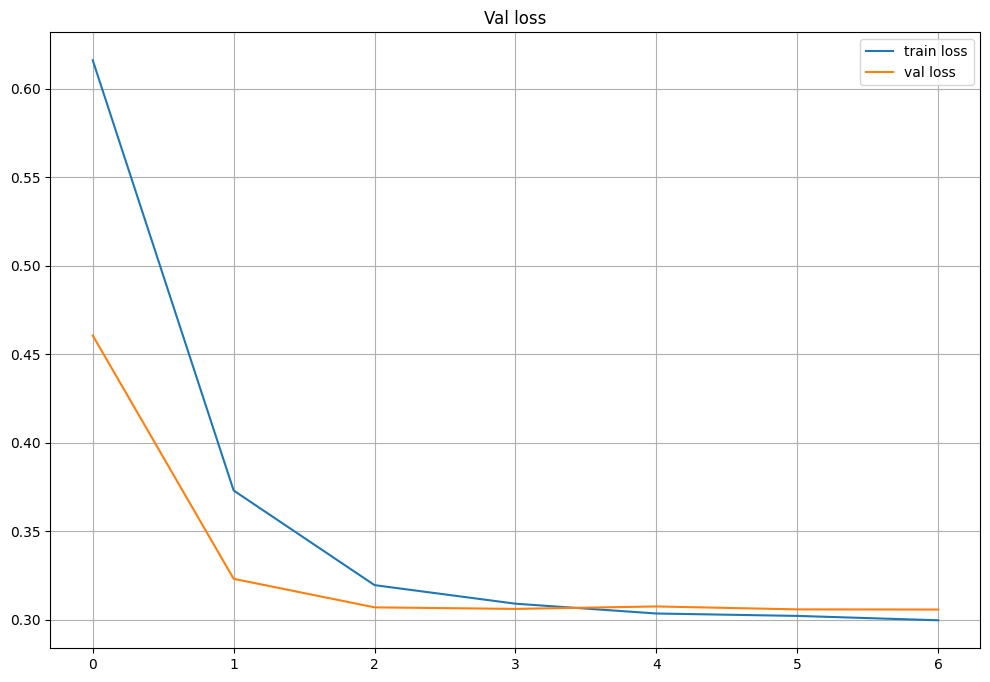

EPOCH 8:
batch / 1000: 1
LOSS train 0.2975921698218444 valid 0.30413803458213806


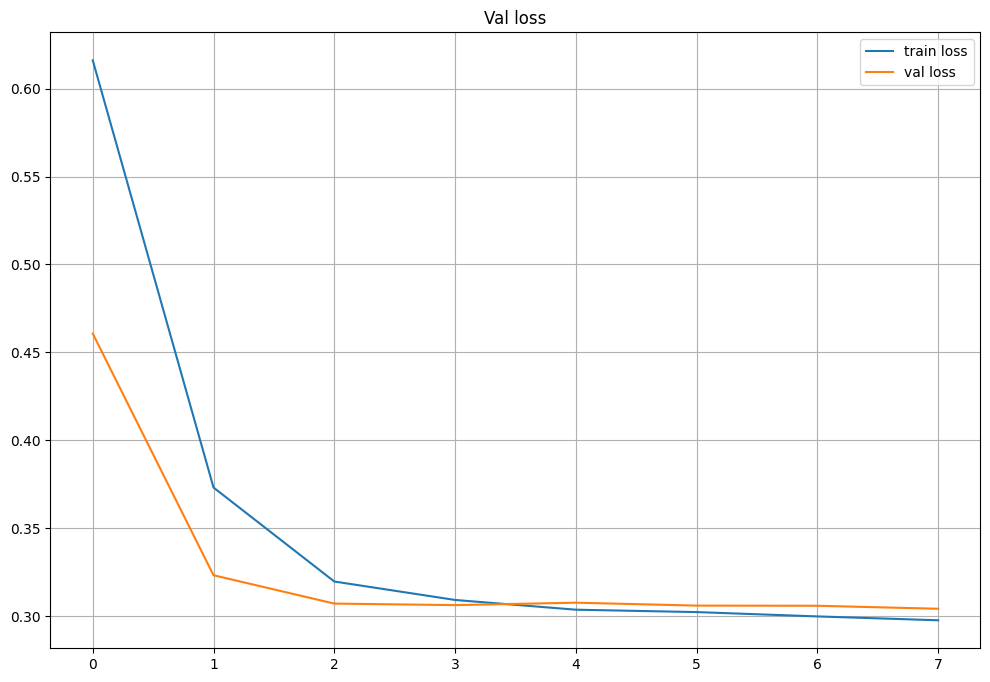

EPOCH 9:
batch / 1000: 1
LOSS train 0.29643749584760015 valid 0.3011346161365509


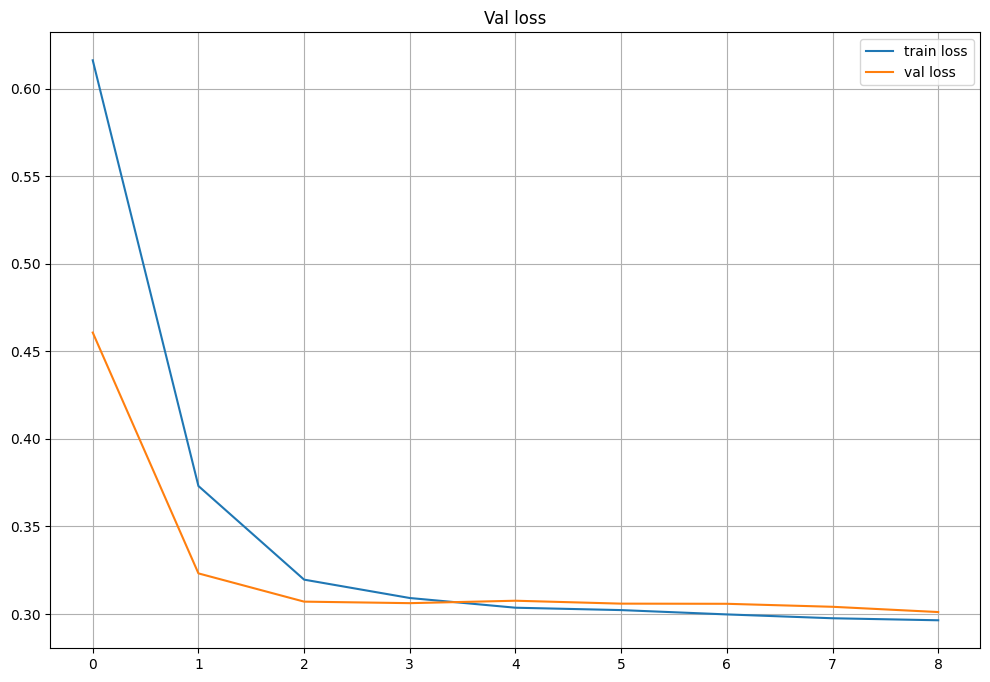

EPOCH 10:
batch / 1000: 1
LOSS train 0.28744566171830715 valid 0.29040199518203735


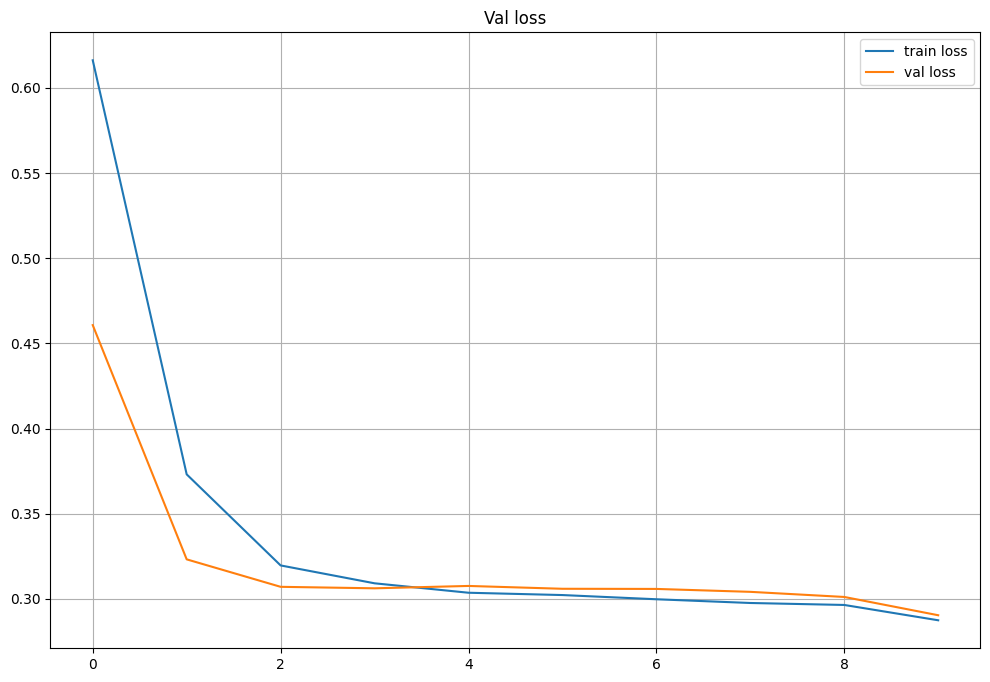

EPOCH 11:
batch / 1000: 1
LOSS train 0.28124467733688974 valid 0.28779518604278564


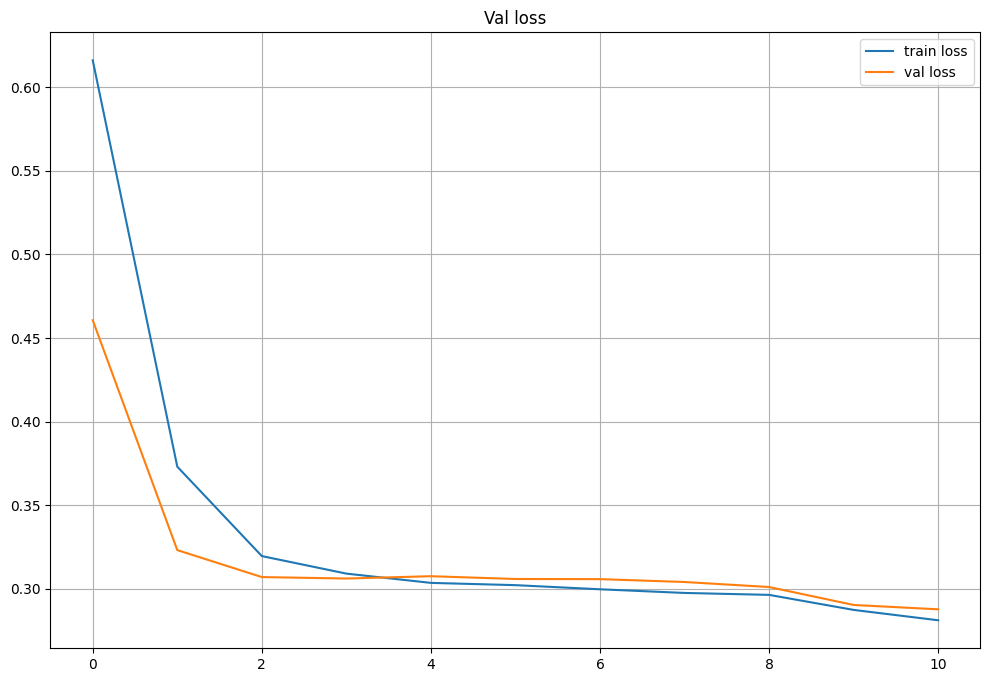

EPOCH 12:
batch / 1000: 1
LOSS train 0.2768788184758783 valid 0.27794742584228516


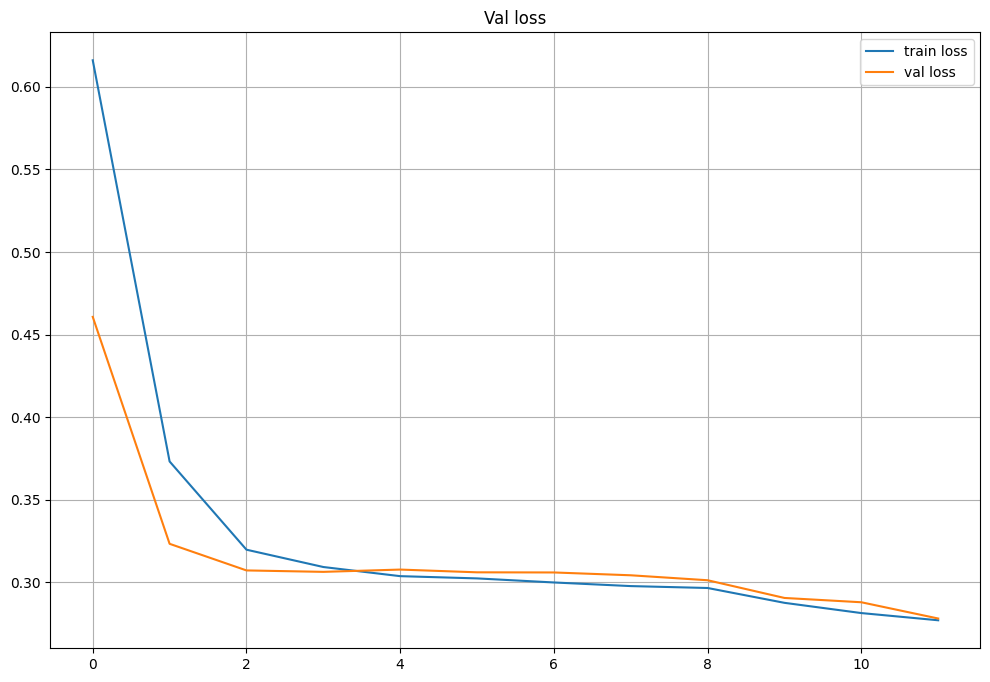

EPOCH 13:
batch / 1000: 1
LOSS train 0.26276150083469973 valid 0.2532770335674286


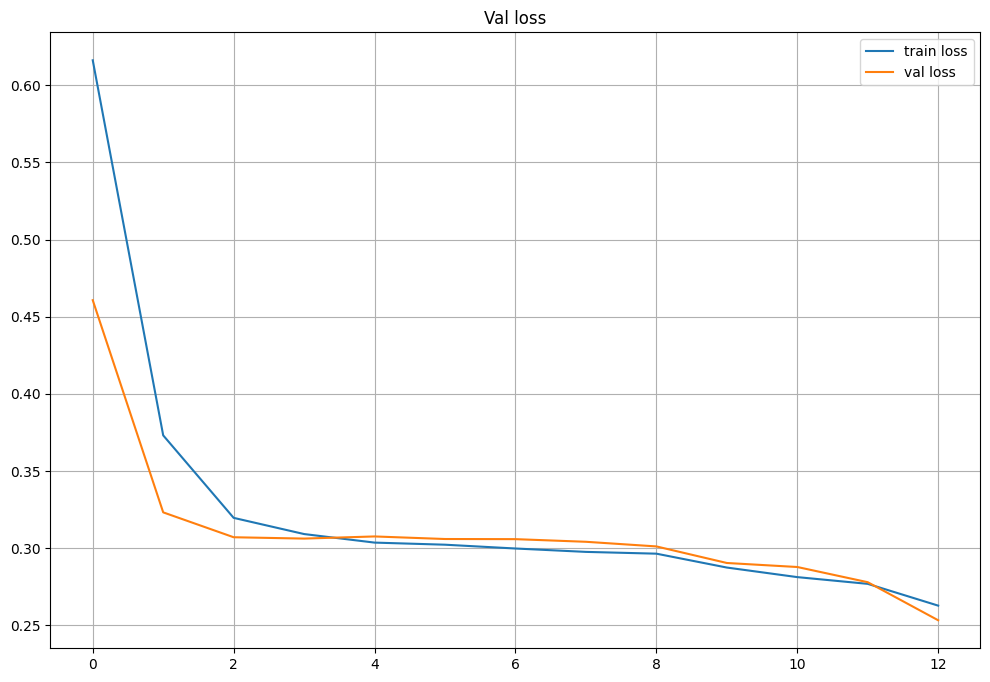

EPOCH 14:
batch / 1000: 1
LOSS train 0.2540248030179332 valid 0.2567083537578583


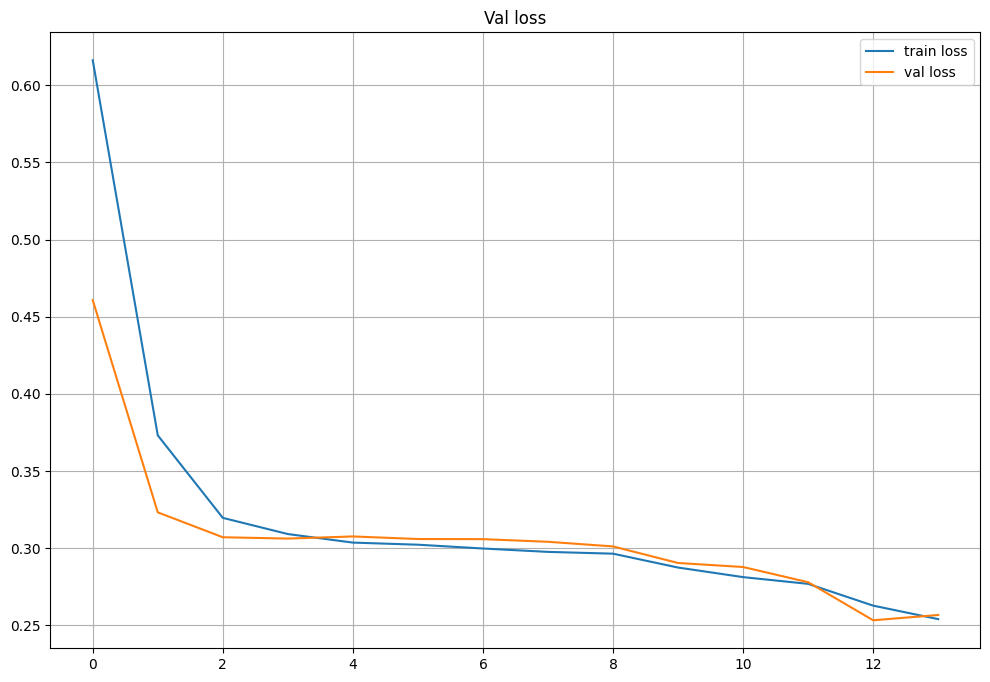

EPOCH 15:
batch / 1000: 1
LOSS train 0.24243574006625251 valid 0.2297949641942978


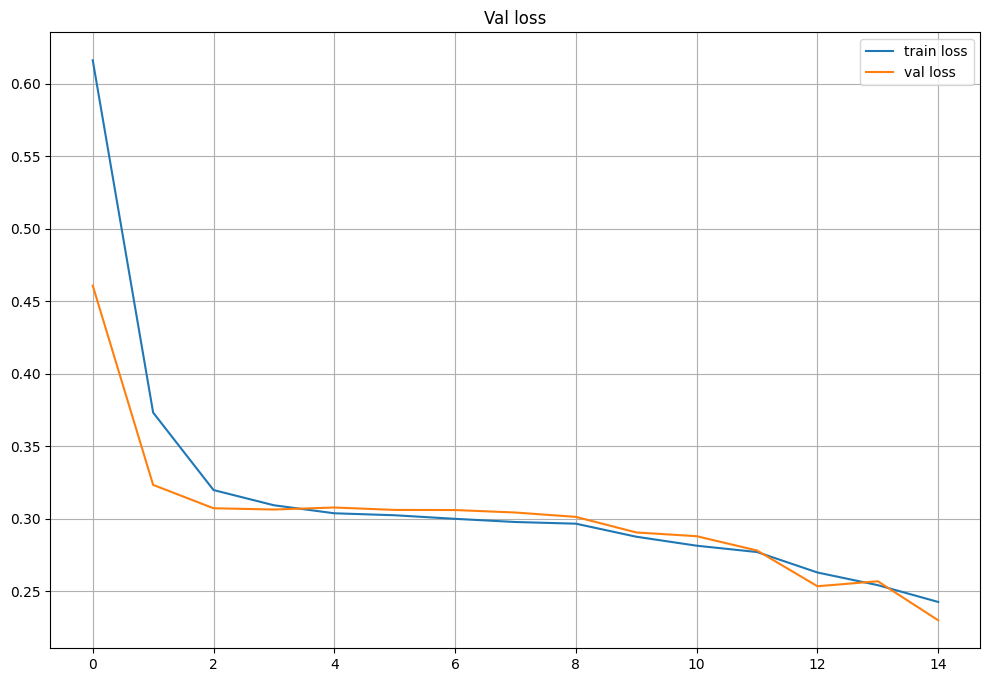

EPOCH 16:
batch / 1000: 1
LOSS train 0.22288690467612762 valid 0.21370233595371246


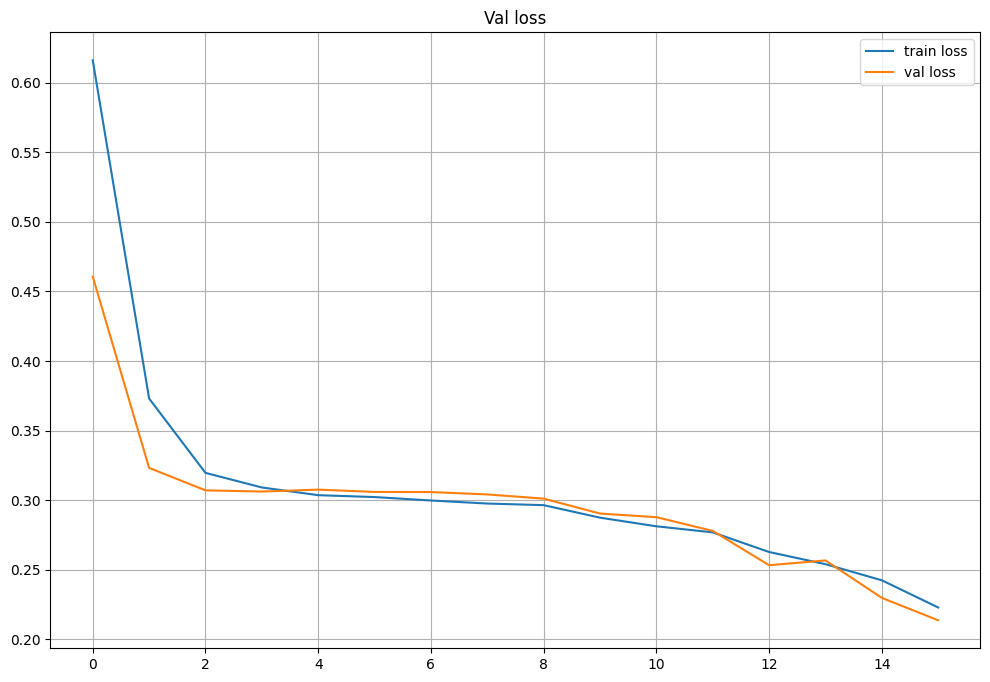

EPOCH 17:
batch / 1000: 1
LOSS train 0.20583201599473724 valid 0.19647417962551117


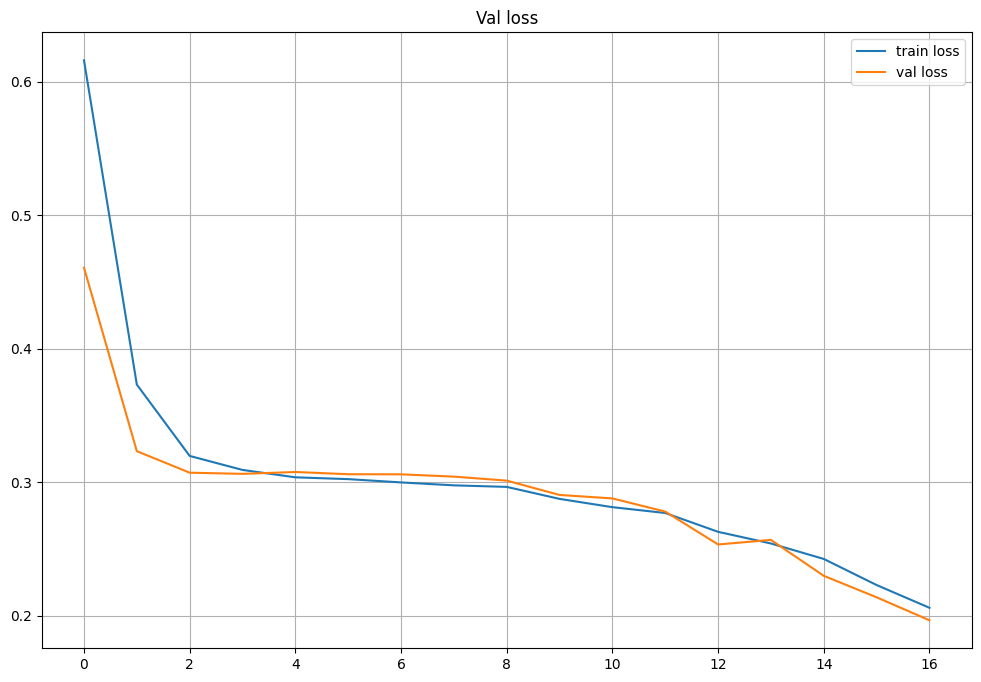

EPOCH 18:
batch / 1000: 1
LOSS train 0.18756205992348438 valid 0.1711537390947342


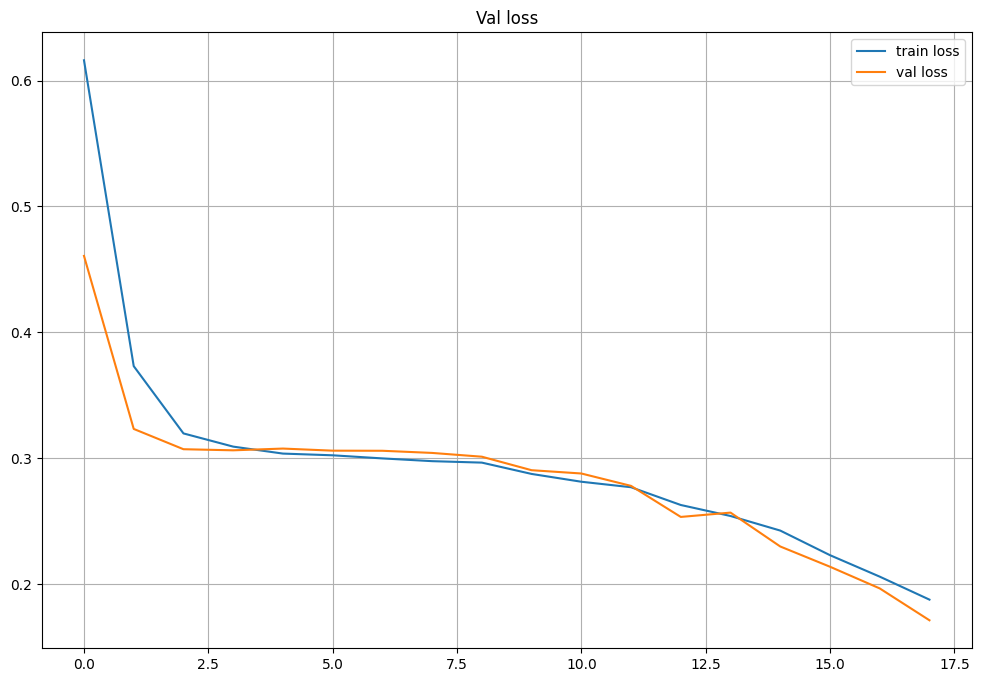

EPOCH 19:
batch / 1000: 1
LOSS train 0.17382228975534644 valid 0.15944084525108337


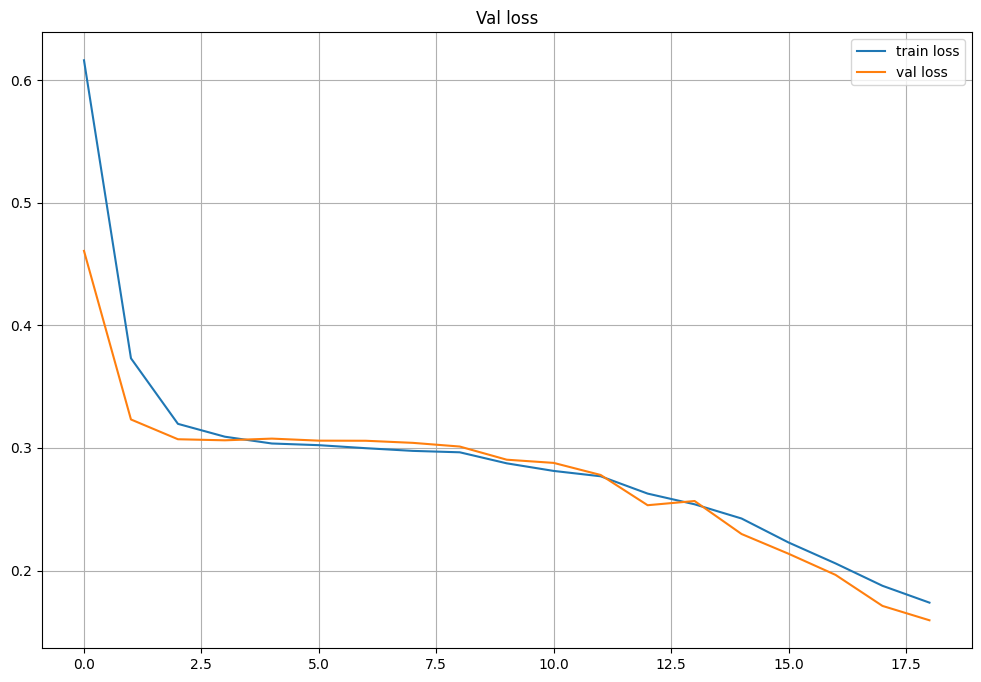

EPOCH 20:
batch / 1000: 1
LOSS train 0.16475742610705302 valid 0.15107910335063934


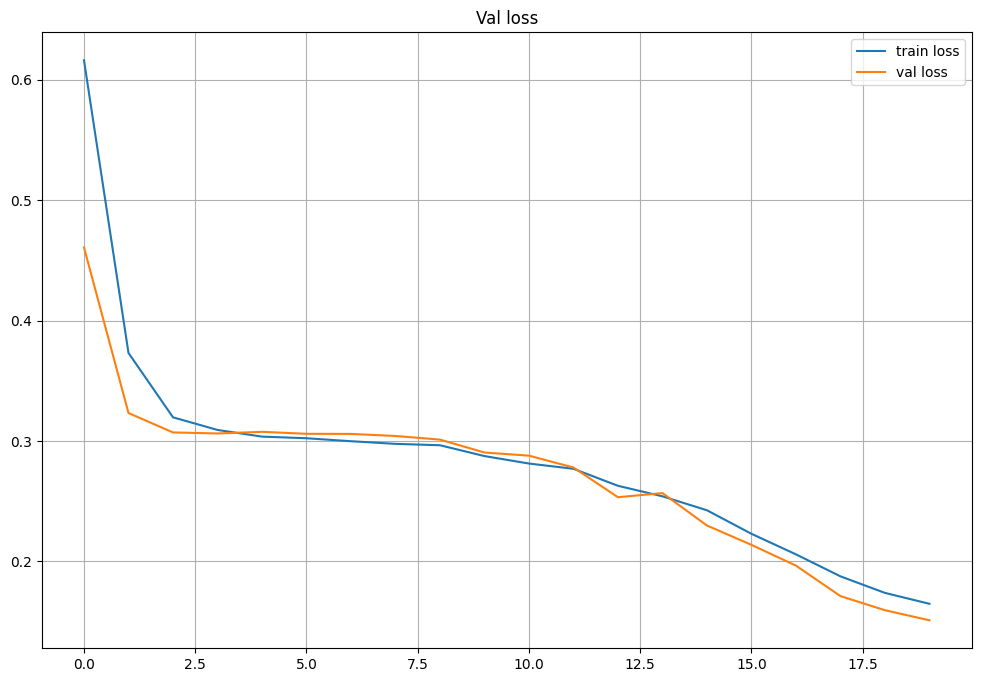

EPOCH 21:
batch / 1000: 1
LOSS train 0.15686837041355767 valid 0.14847517013549805


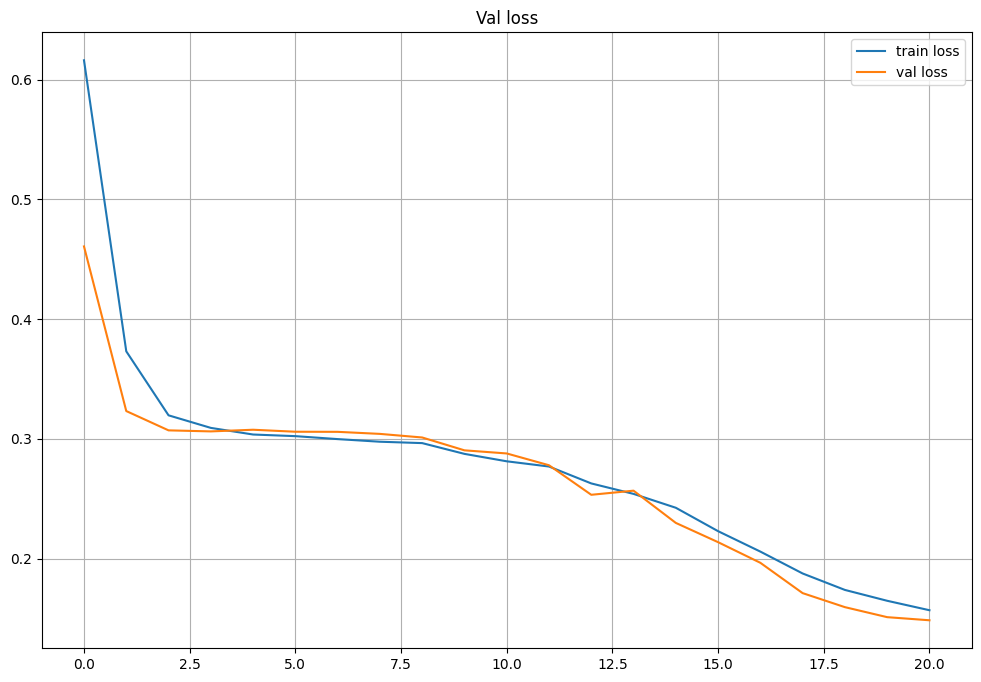

EPOCH 22:
batch / 1000: 1
LOSS train 0.1527556926707455 valid 0.1496906578540802


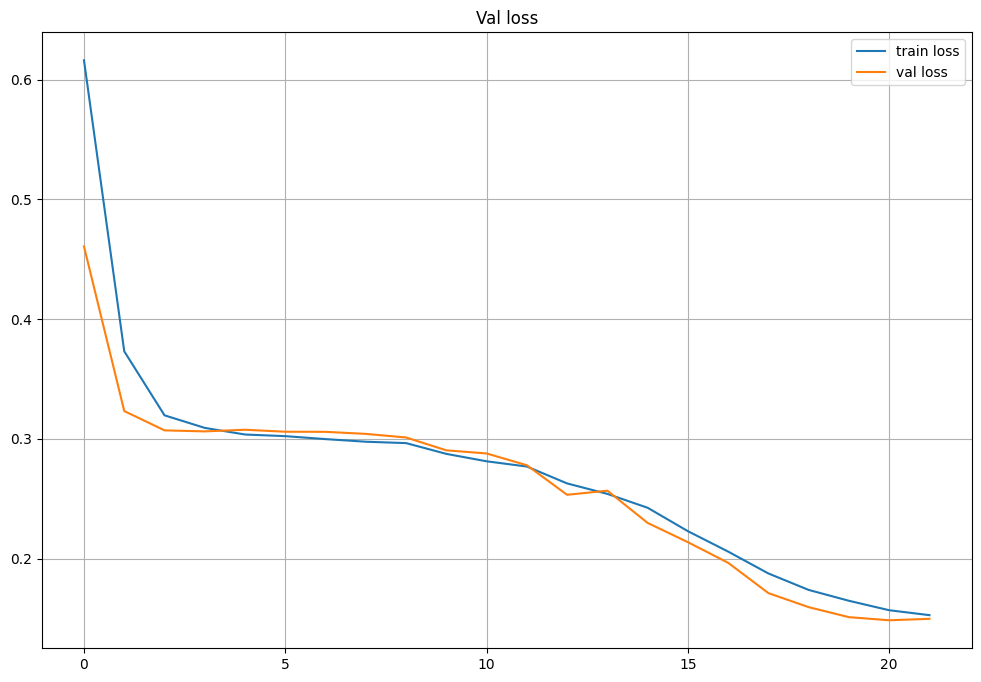

EPOCH 23:
batch / 1000: 1
LOSS train 0.14880499646221682 valid 0.13925997912883759


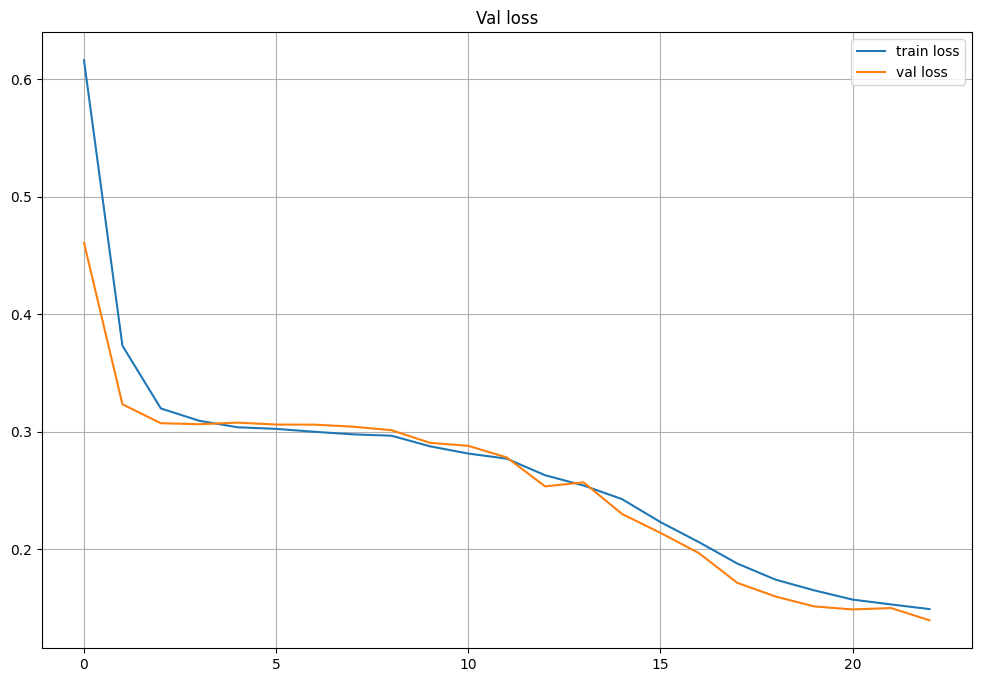

EPOCH 24:
batch / 1000: 1
LOSS train 0.14465229274006428 valid 0.1376325935125351


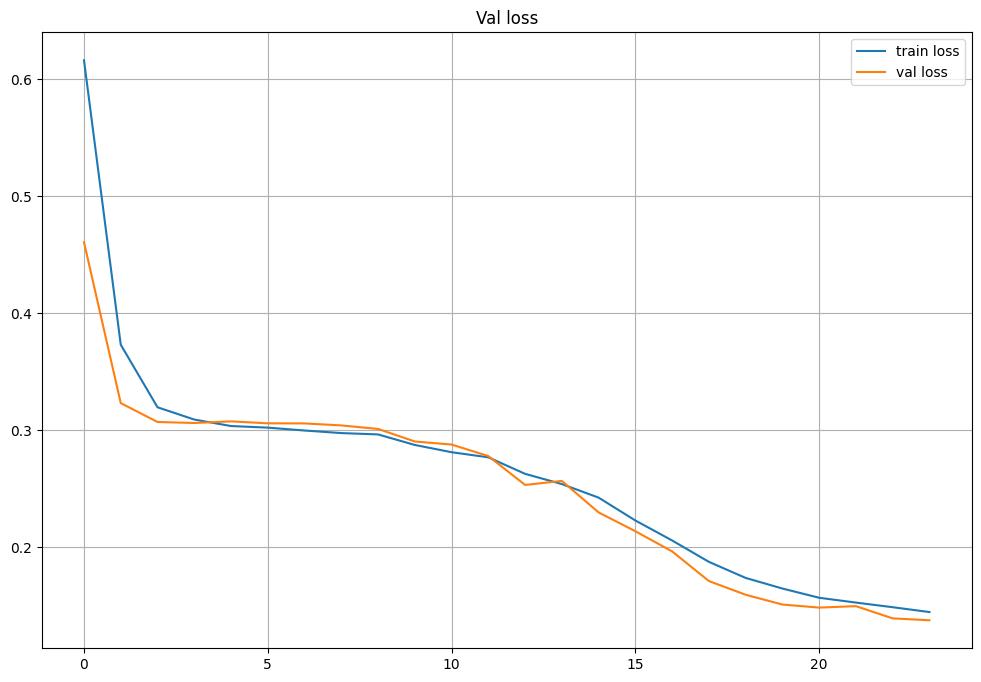

EPOCH 25:
batch / 1000: 1
LOSS train 0.14101691747545375 valid 0.13923384249210358


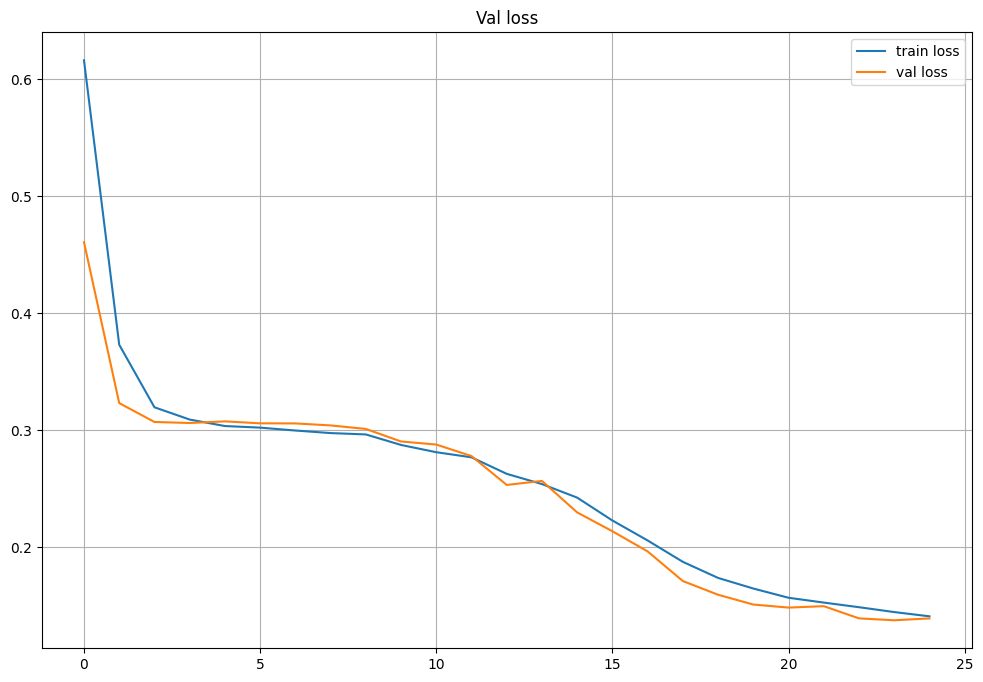

EPOCH 26:
batch / 1000: 1
LOSS train 0.13697057239398883 valid 0.1252903938293457


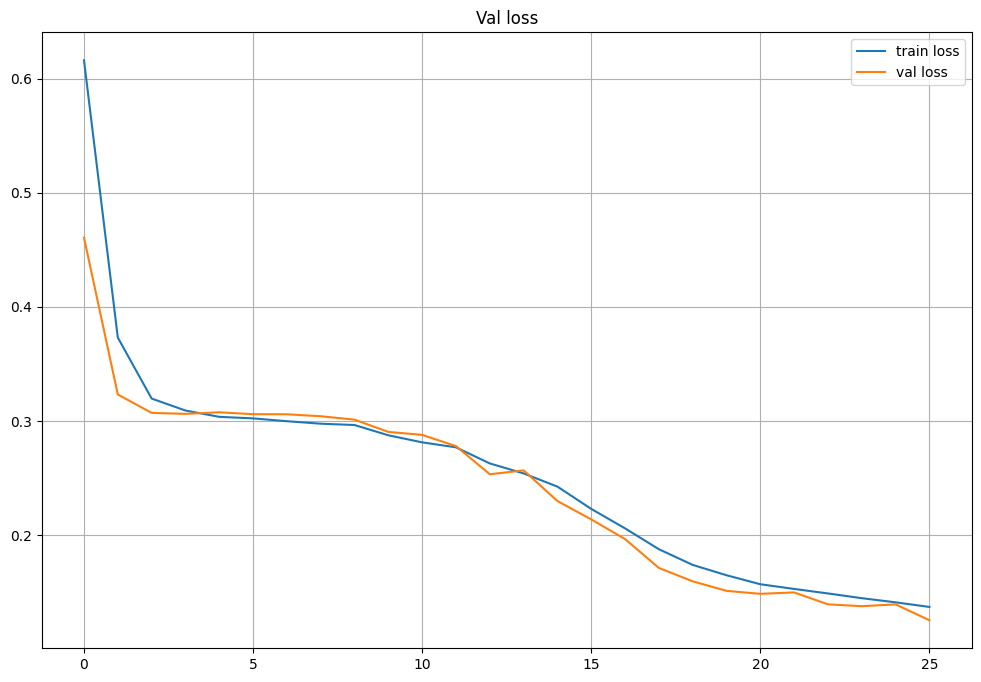

EPOCH 27:
batch / 1000: 1
LOSS train 0.1331957606090546 valid 0.11933433264493942


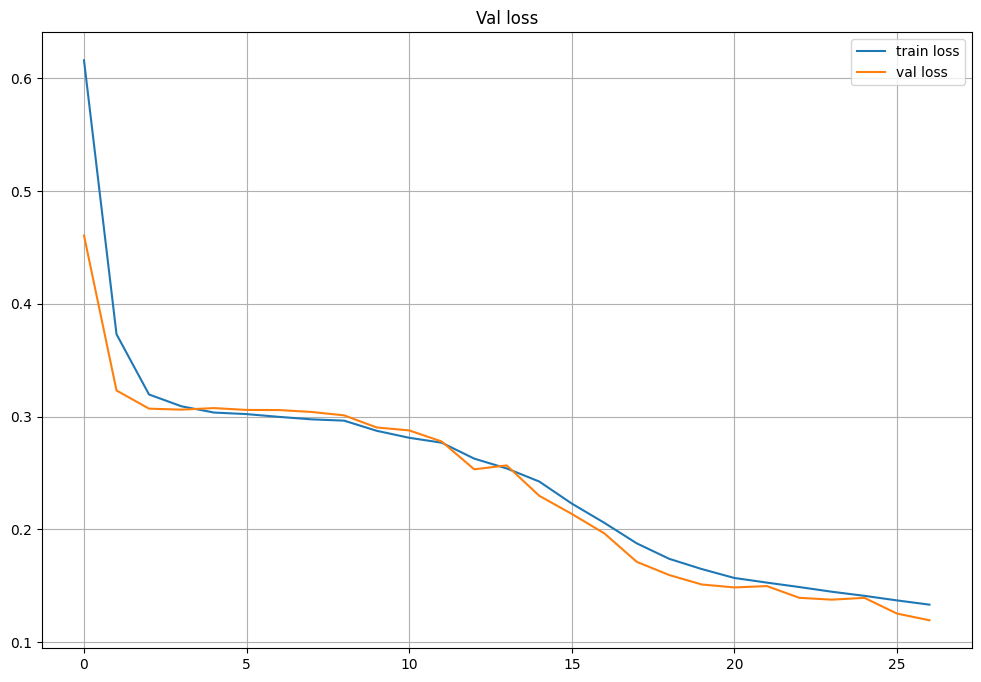

EPOCH 28:
batch / 1000: 1
LOSS train 0.12887616075964783 valid 0.12306178361177444


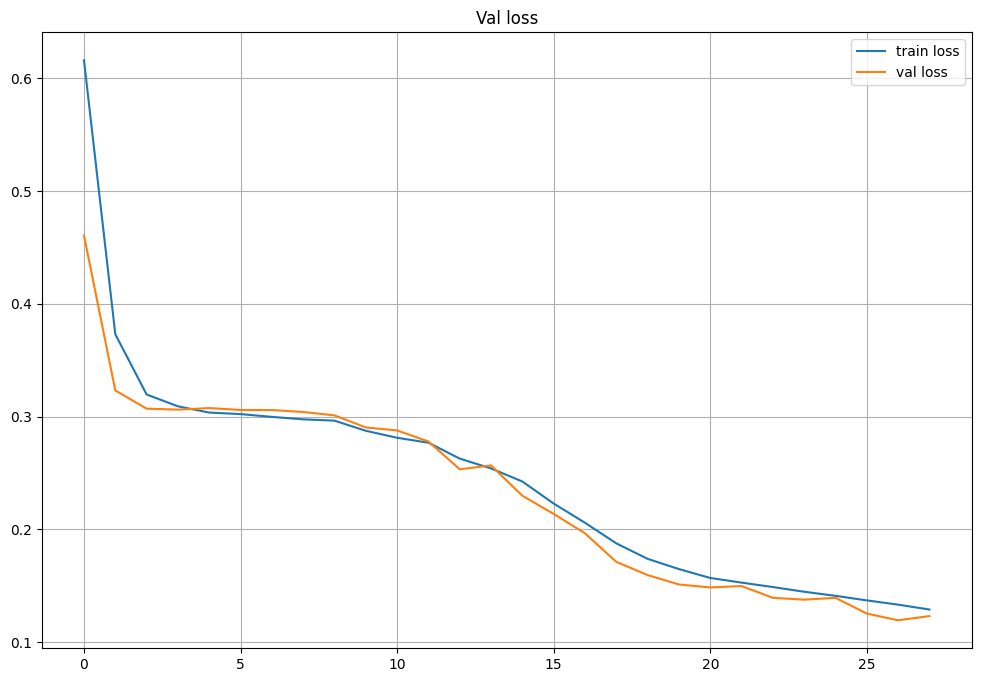

EPOCH 29:
batch / 1000: 1
LOSS train 0.1262032451297465 valid 0.1186809167265892


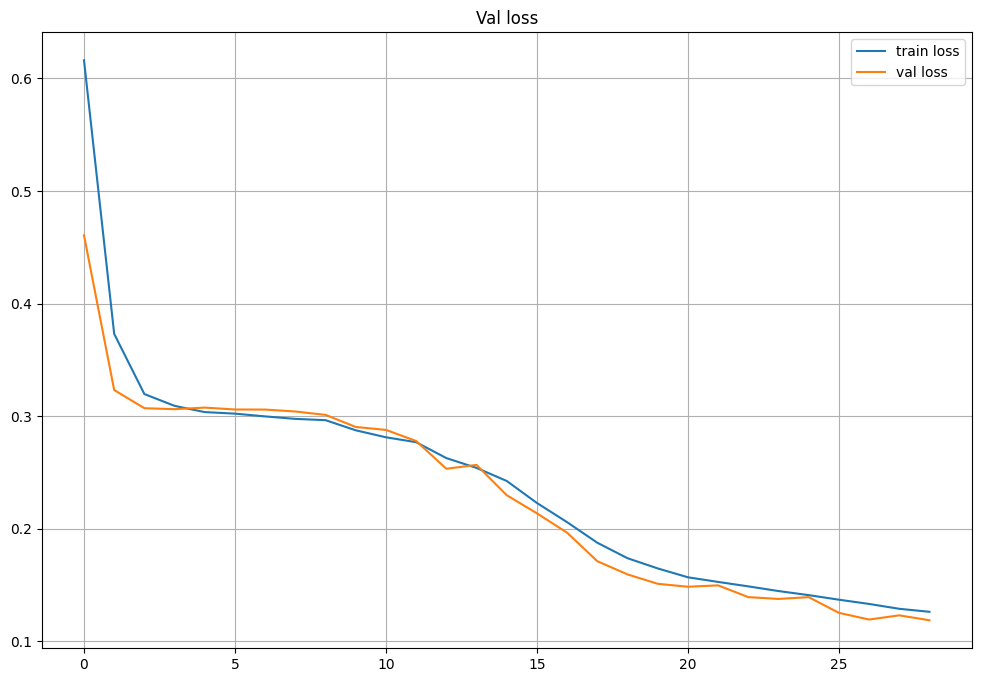

EPOCH 30:
batch / 1000: 1
LOSS train 0.12354221310742555 valid 0.1287129521369934


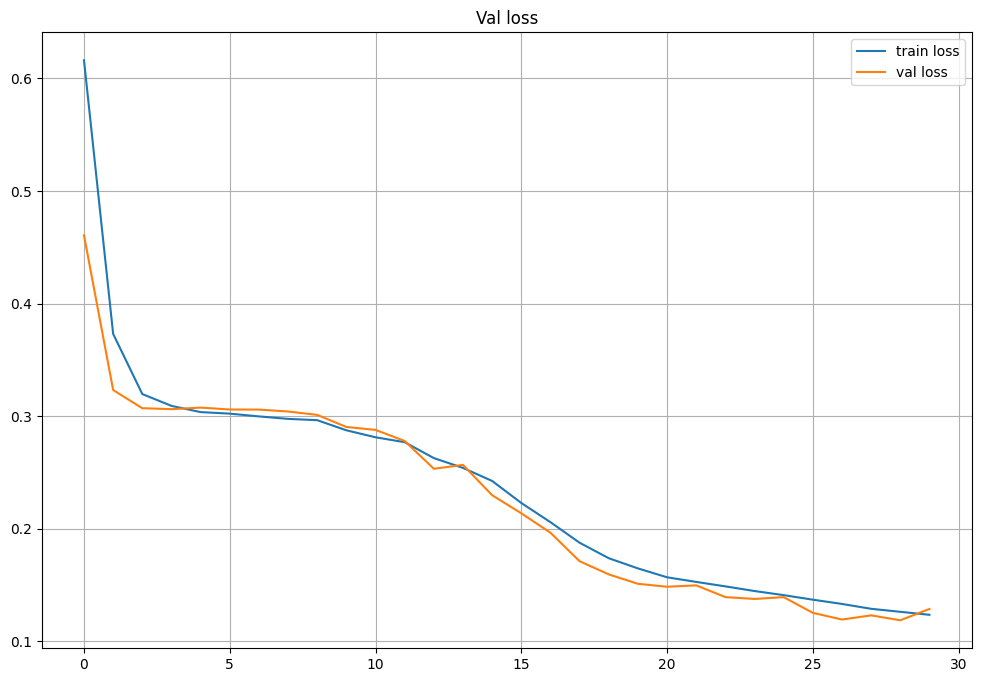

EPOCH 31:
batch / 1000: 1
LOSS train 0.12224802778181093 valid 0.11068505048751831


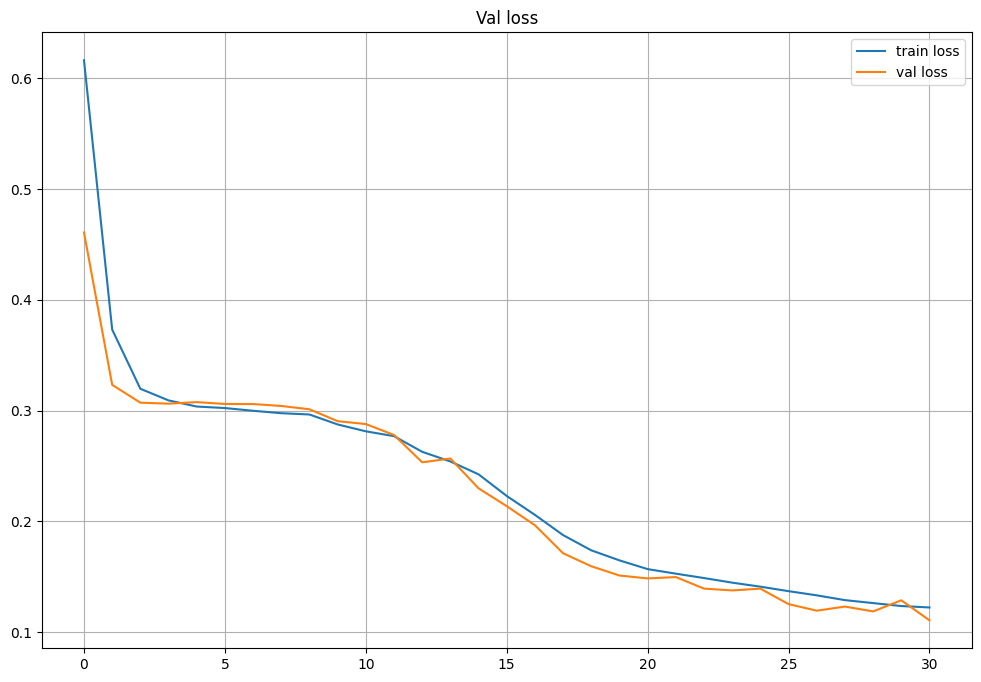

EPOCH 32:
batch / 1000: 1
LOSS train 0.12045809309469564 valid 0.11849614977836609


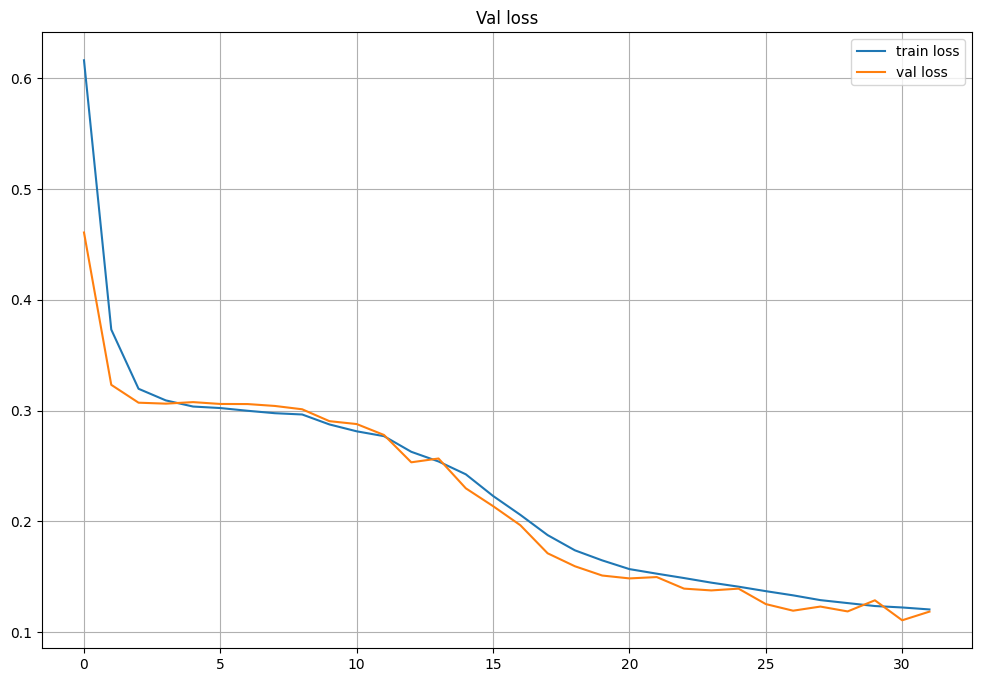

EPOCH 33:
batch / 1000: 1
LOSS train 0.11718840844873585 valid 0.11627412587404251


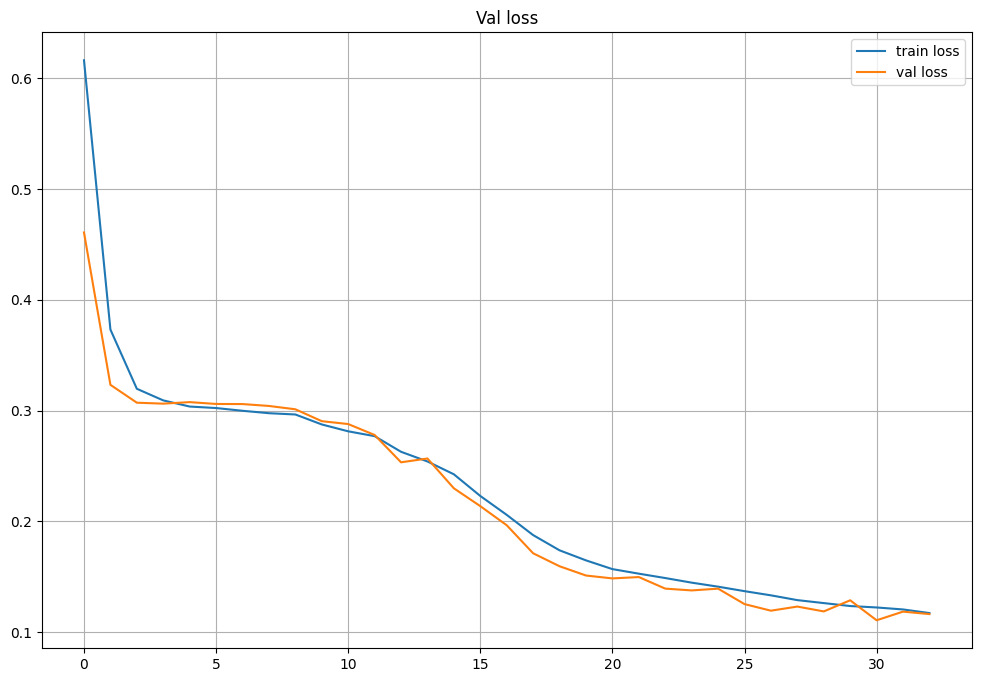

EPOCH 34:
batch / 1000: 1
LOSS train 0.11695304546464558 valid 0.11703135818243027


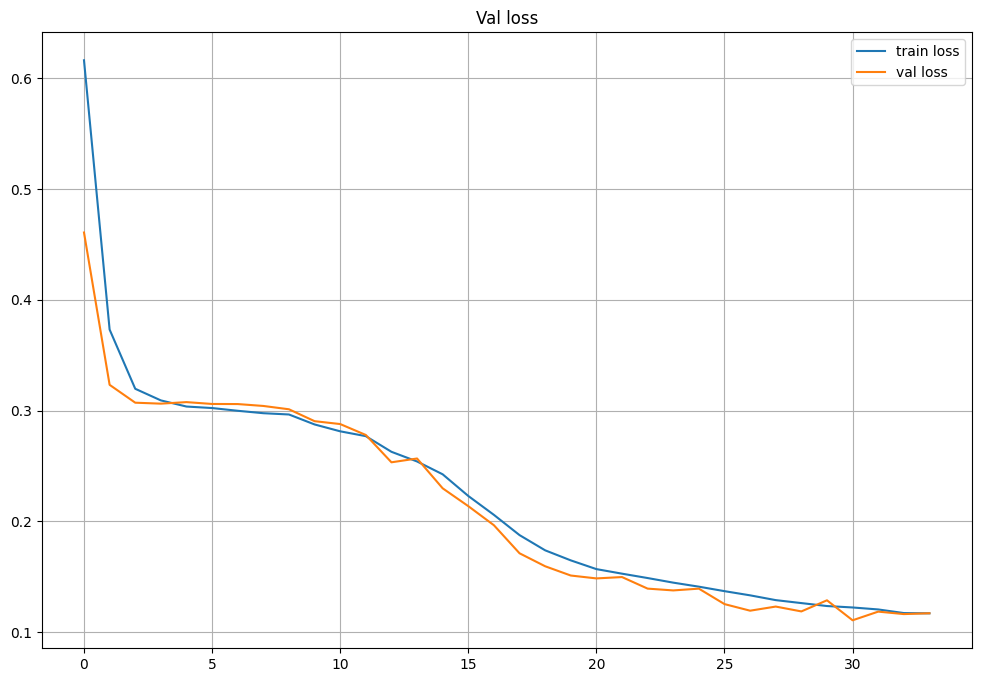

EPOCH 35:
batch / 1000: 1
LOSS train 0.11224637731122326 valid 0.10501398146152496


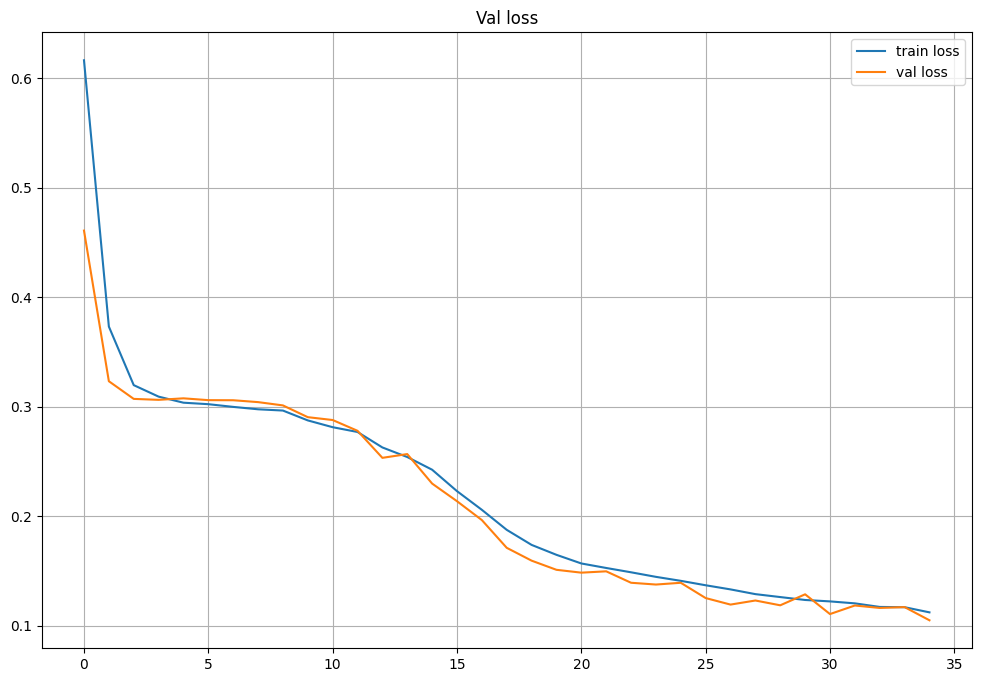

EPOCH 36:
batch / 1000: 1
LOSS train 0.10442596948333834 valid 0.1190609484910965


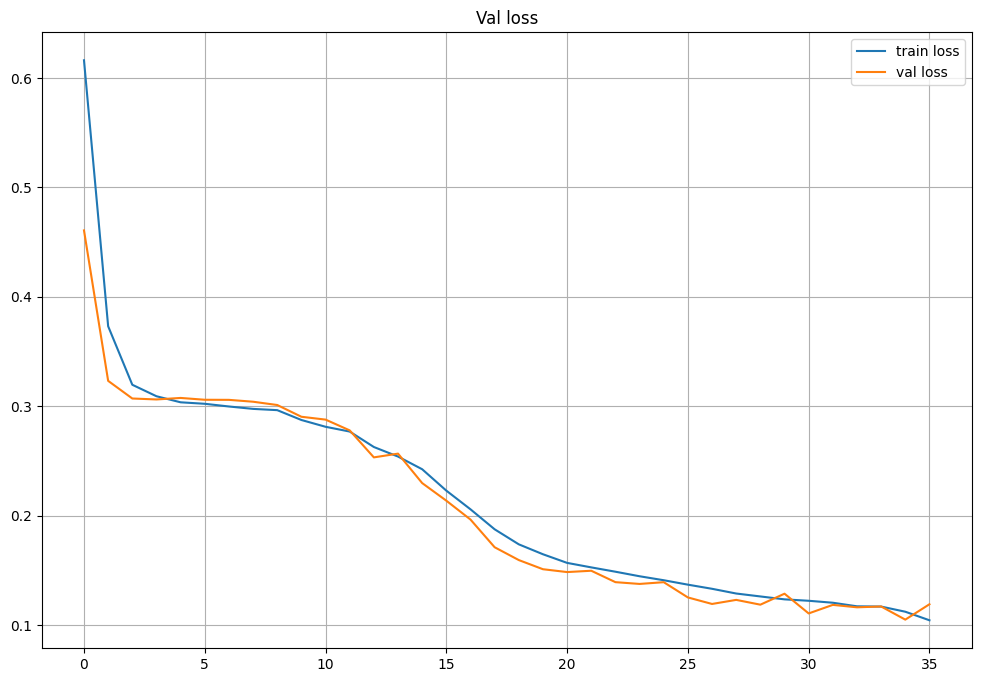

EPOCH 37:
batch / 1000: 1
LOSS train 0.1003540675947523 valid 0.10293278843164444


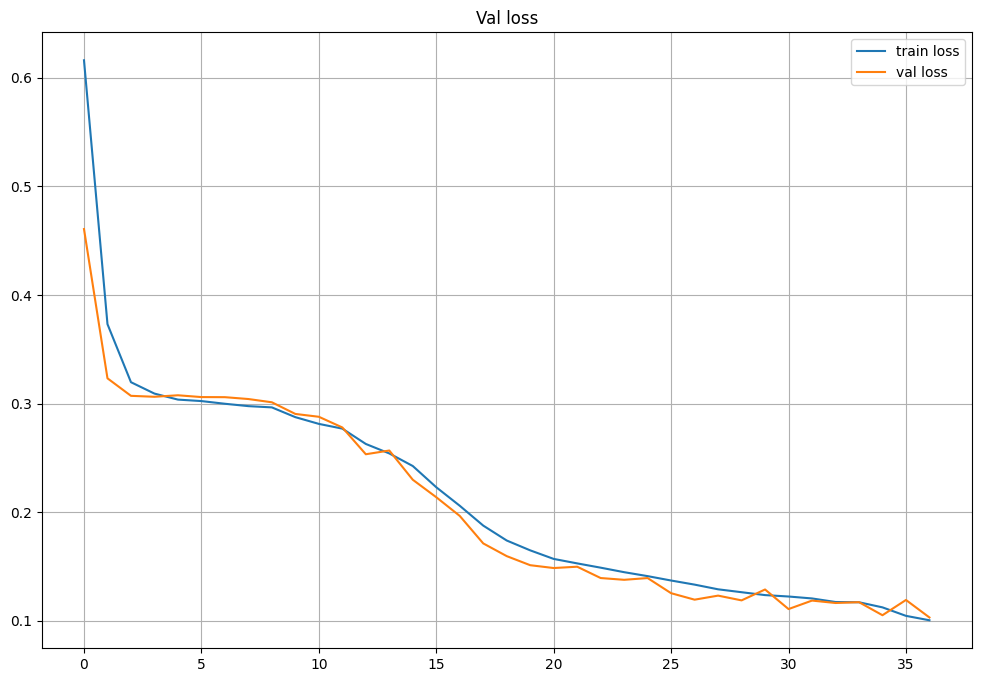

EPOCH 38:
batch / 1000: 1
LOSS train 0.09751377748309419 valid 0.09945570677518845


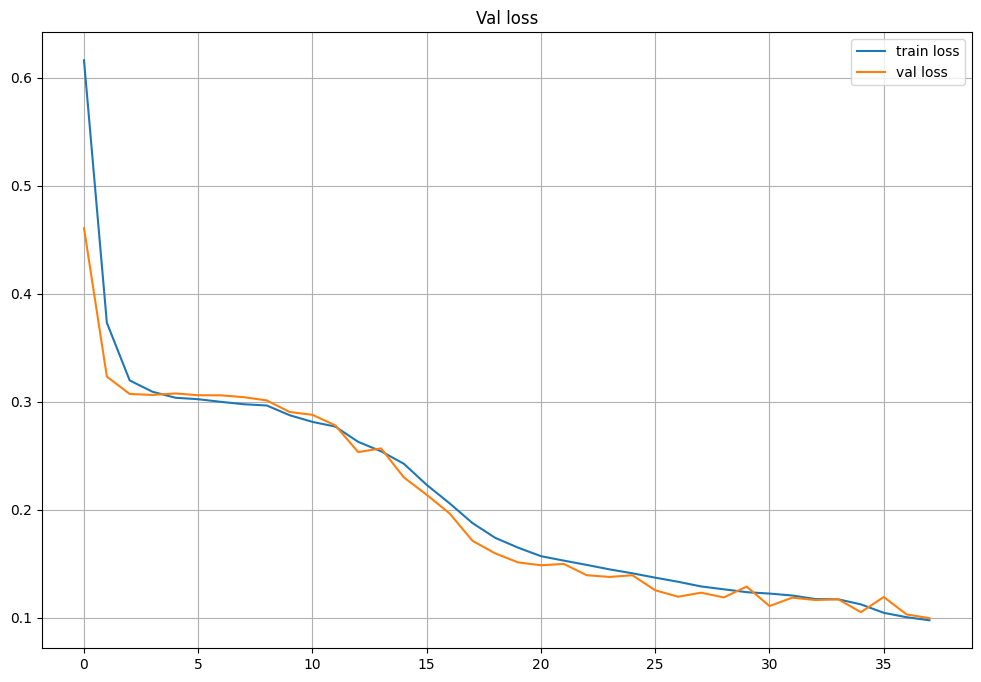

EPOCH 39:
batch / 1000: 1
LOSS train 0.09543800081614788 valid 0.10393881052732468


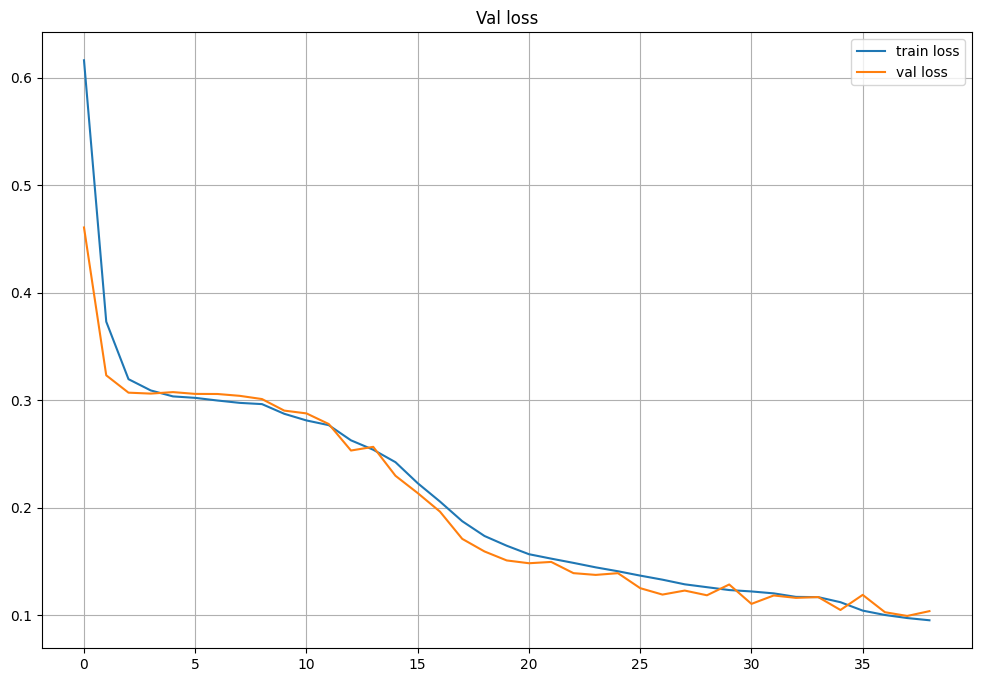

EPOCH 40:
batch / 1000: 1
LOSS train 0.09440050301843338 valid 0.09365607798099518


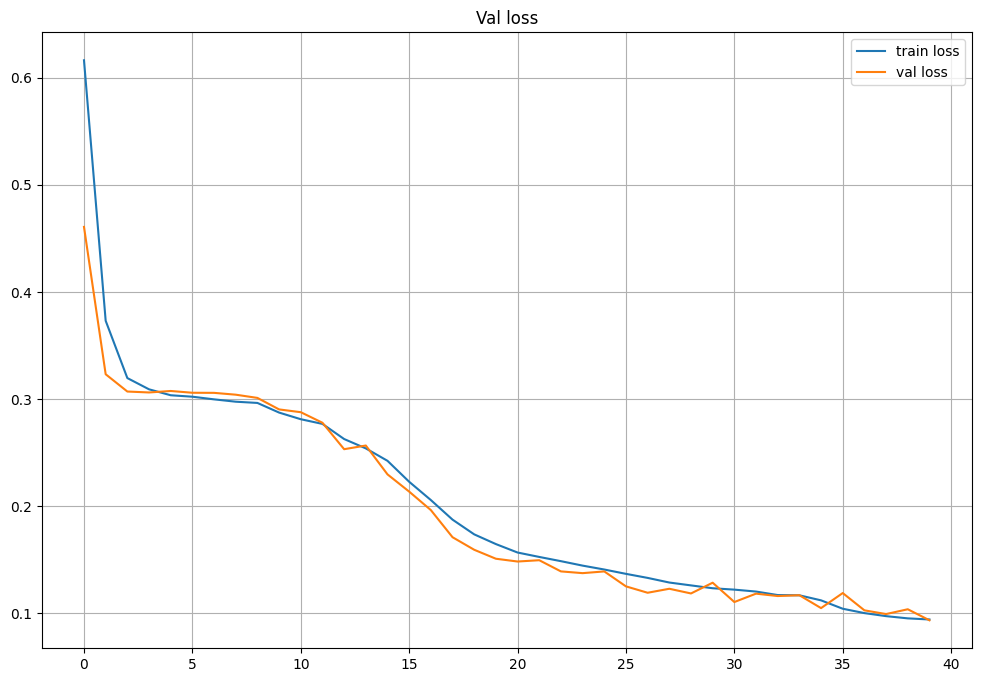

EPOCH 41:
batch / 1000: 1
LOSS train 0.09362373846684172 valid 0.08912987262010574


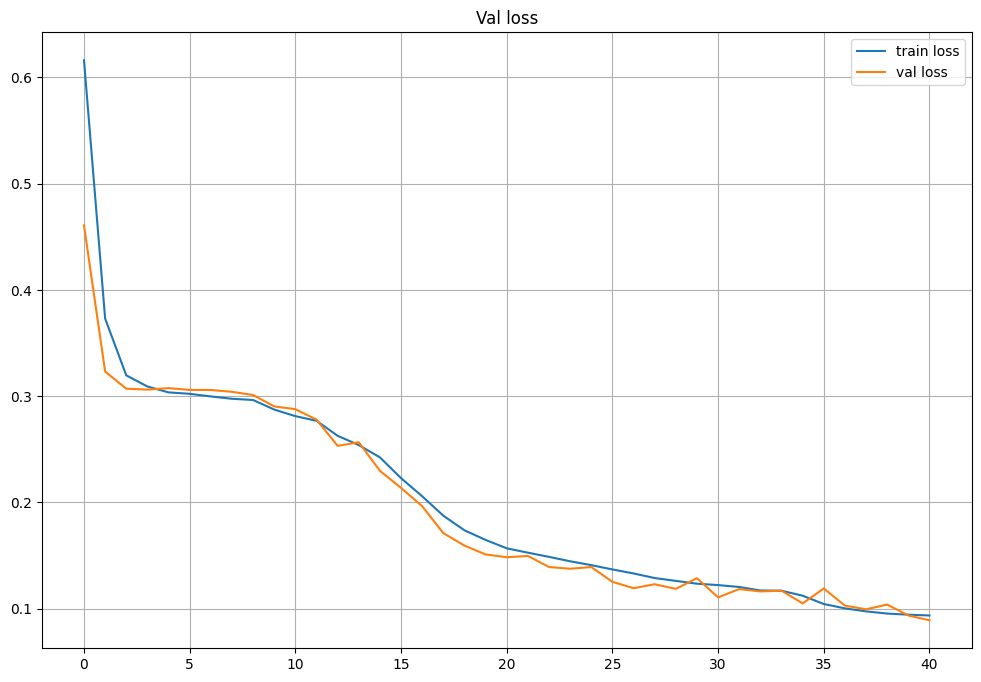

EPOCH 42:
batch / 1000: 1
LOSS train 0.09161963239301474 valid 0.09358853101730347


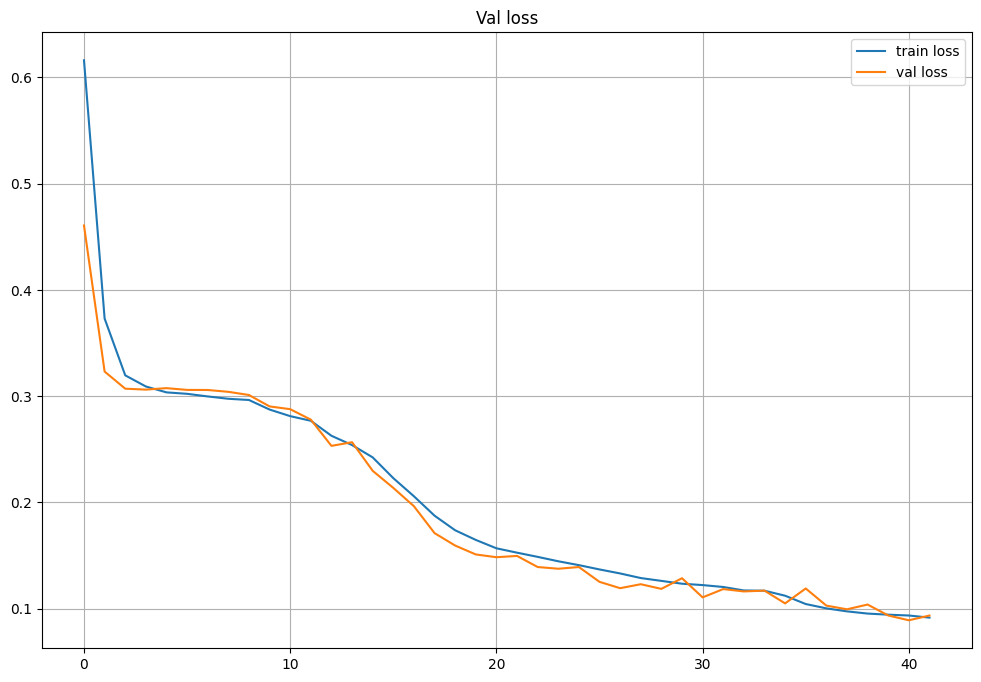

EPOCH 43:
batch / 1000: 1
LOSS train 0.09025199046799252 valid 0.09609627723693848


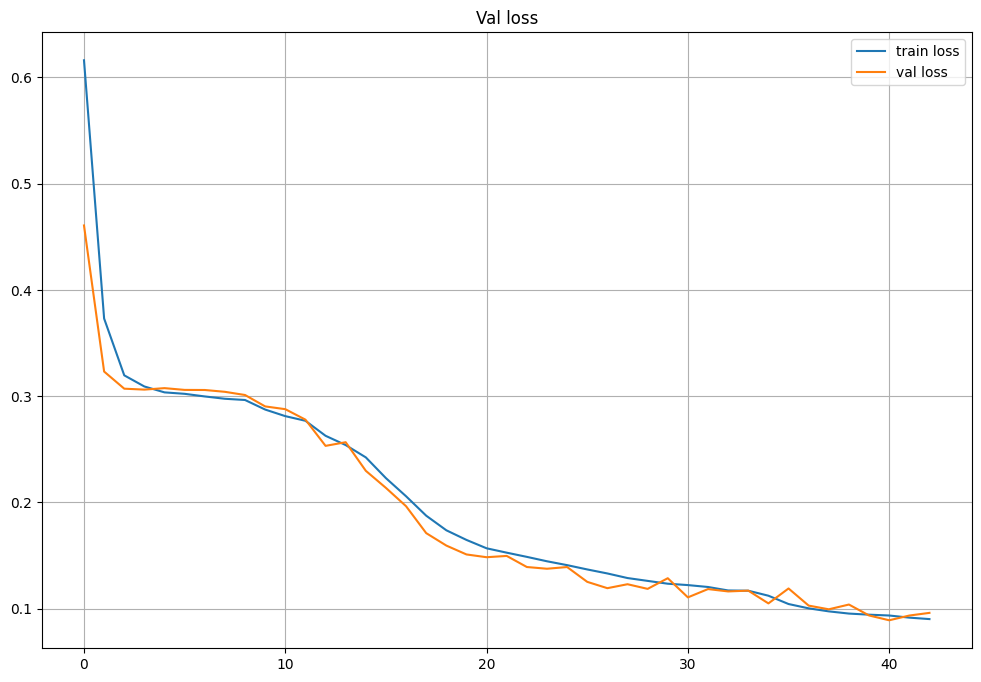

EPOCH 44:
batch / 1000: 1
LOSS train 0.08797023403535863 valid 0.0921178087592125


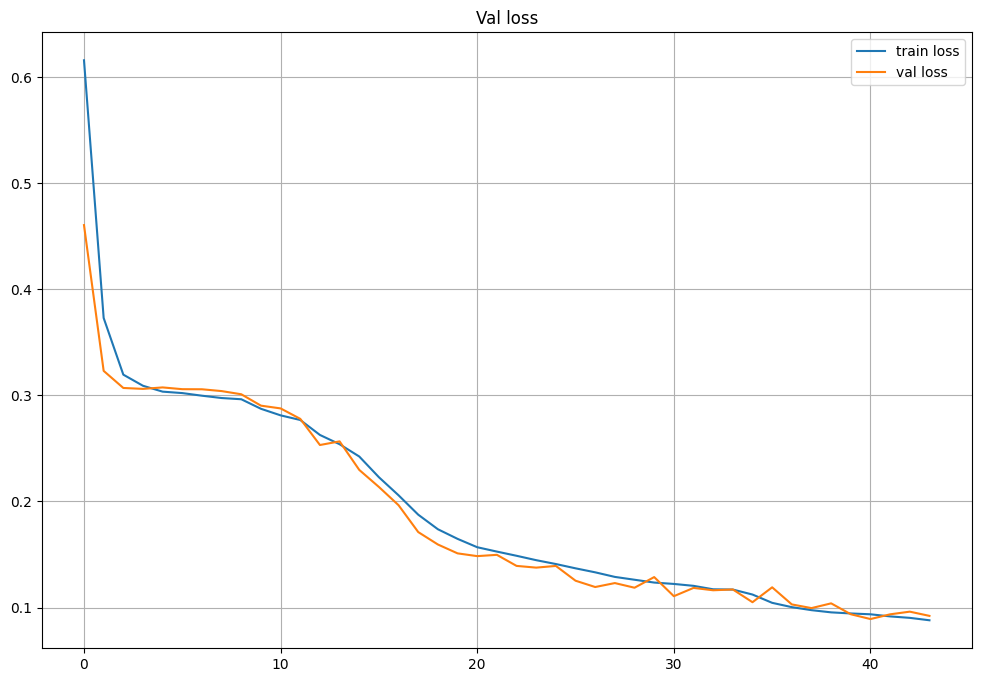

EPOCH 45:
batch / 1000: 1
LOSS train 0.08666969821930129 valid 0.09350740909576416


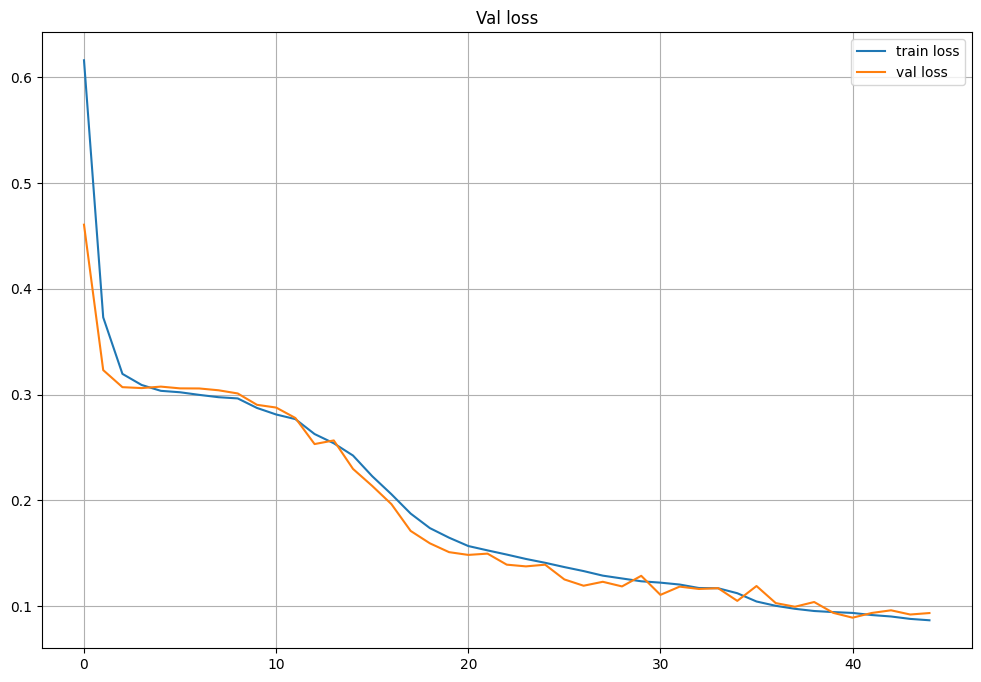

EPOCH 46:
batch / 1000: 1
LOSS train 0.0849167103512723 valid 0.08241184055805206


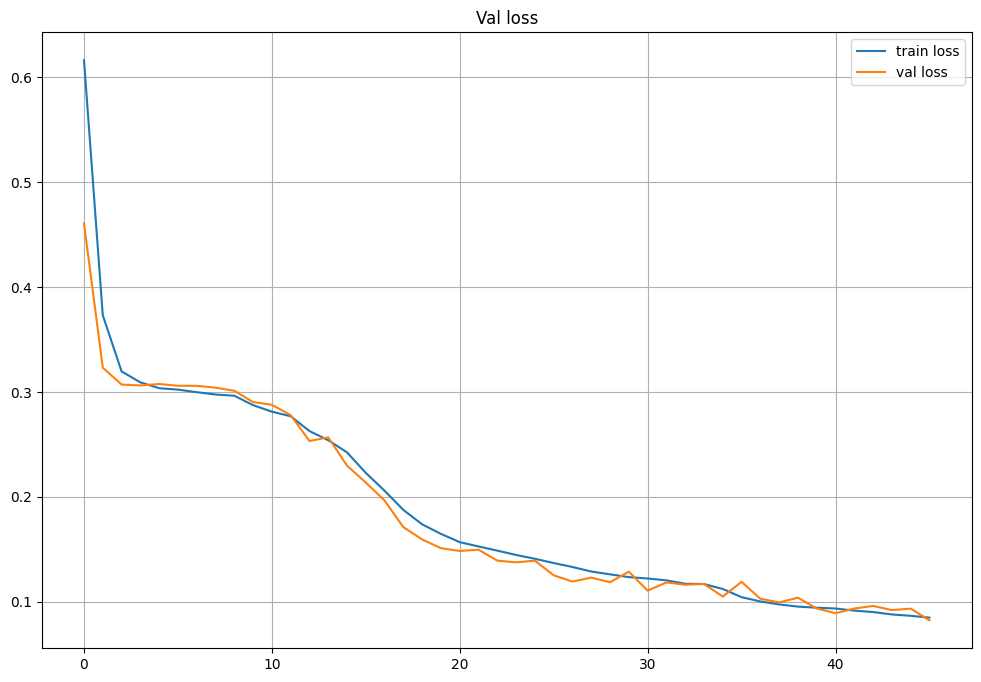

EPOCH 47:
batch / 1000: 1
LOSS train 0.08387501782586286 valid 0.09219351410865784


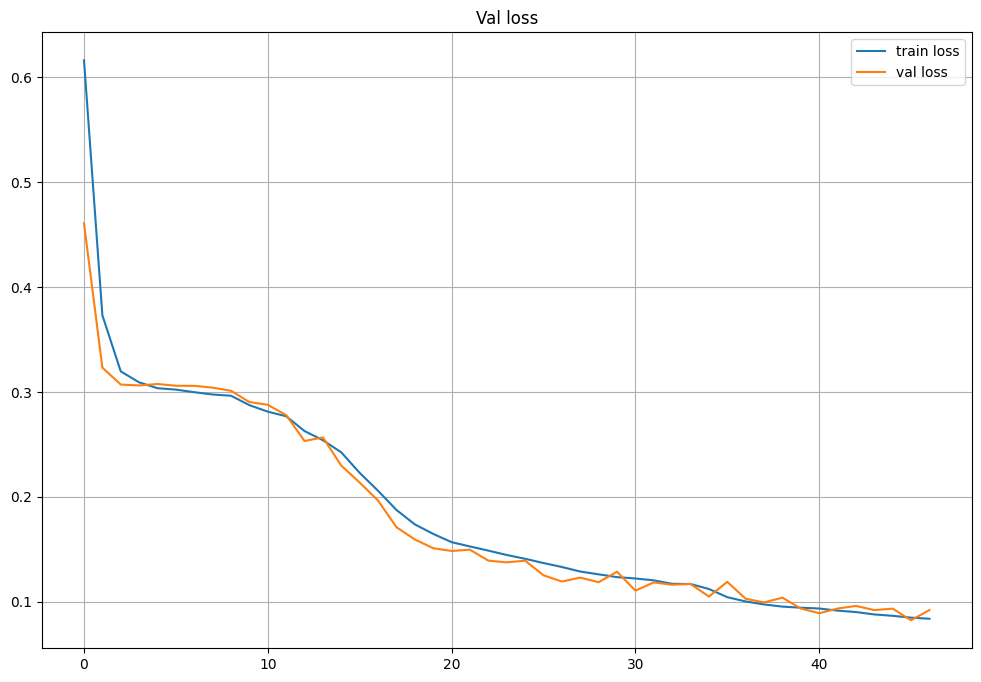

EPOCH 48:
batch / 1000: 1
LOSS train 0.0828382658412694 valid 0.09115273505449295


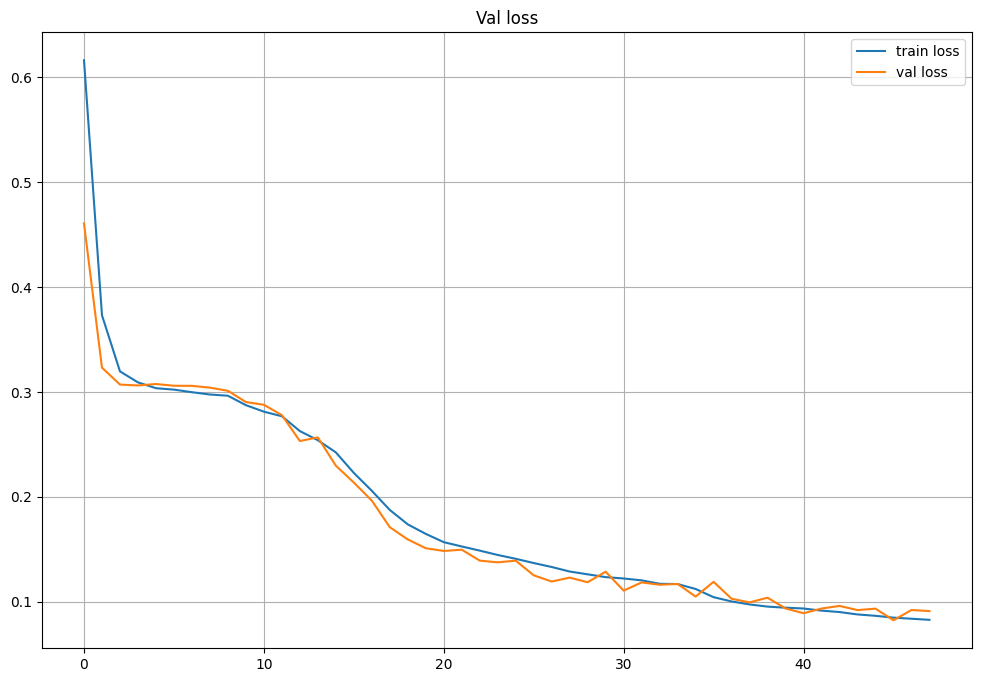

EPOCH 49:
batch / 1000: 1
LOSS train 0.08339588040173576 valid 0.09161364287137985


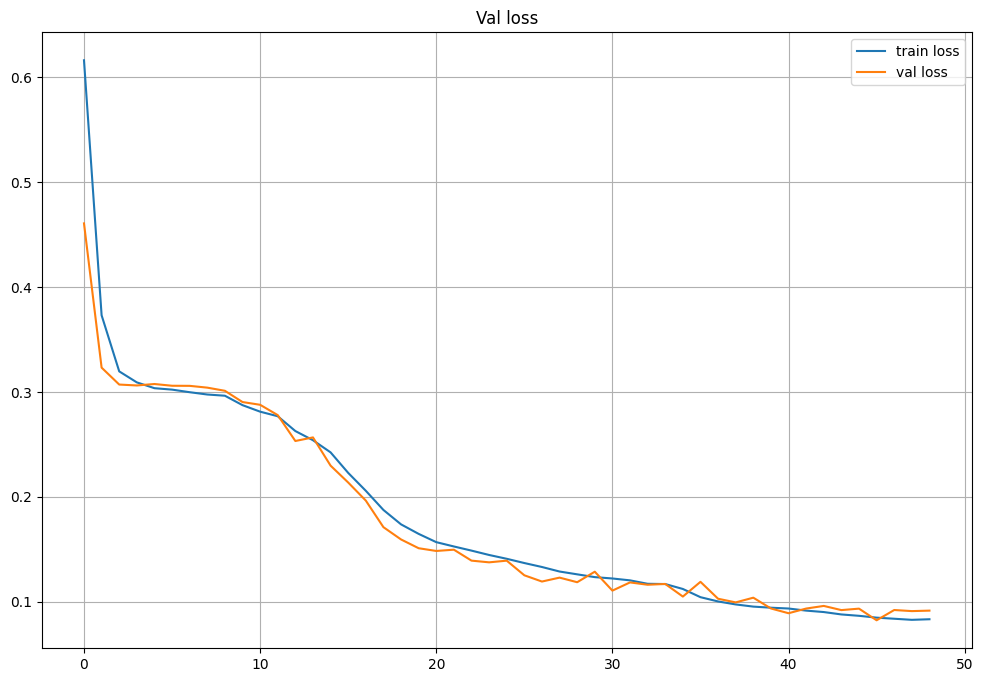

EPOCH 50:
batch / 1000: 1
LOSS train 0.08124400267462016 valid 0.08473696559667587


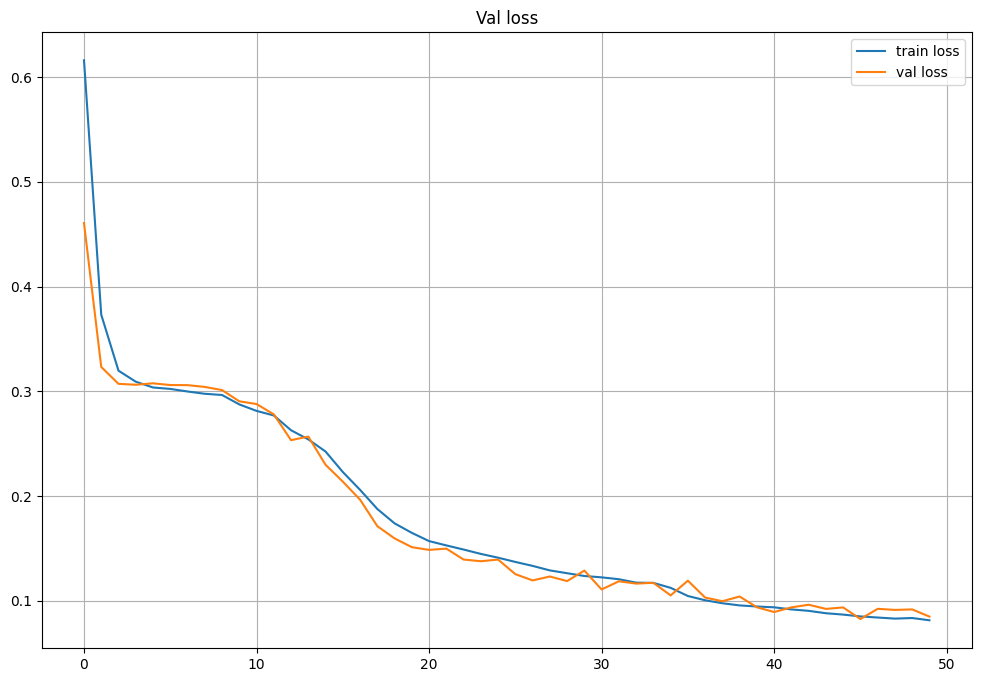

EPOCH 51:
batch / 1000: 1
LOSS train 0.0807514615805733 valid 0.09105861932039261


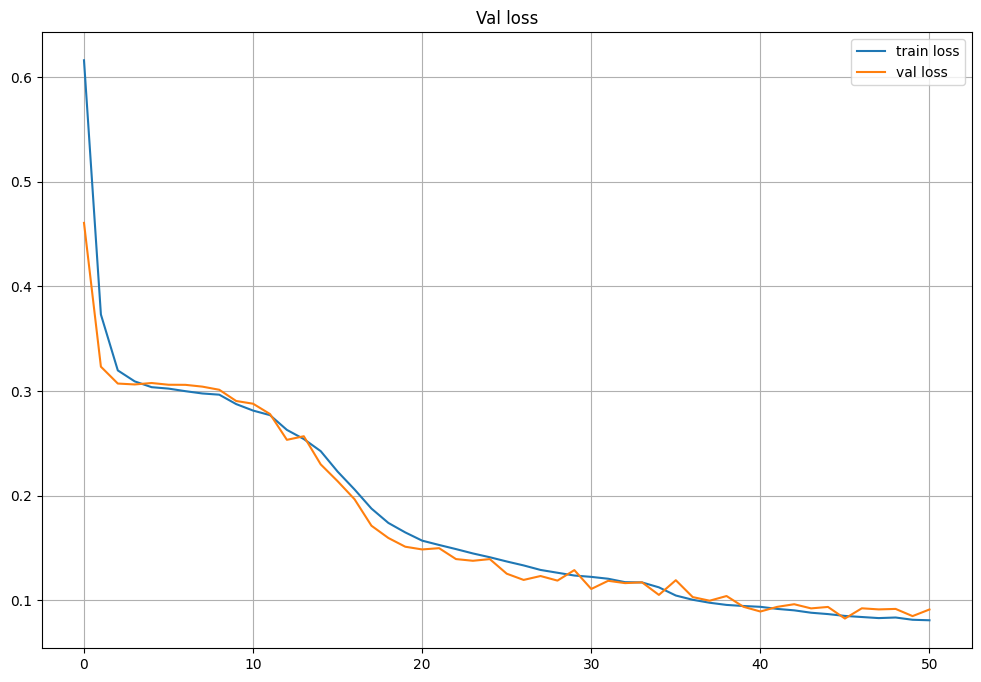

EPOCH 52:
batch / 1000: 1
LOSS train 0.08046373084940697 valid 0.0869436115026474


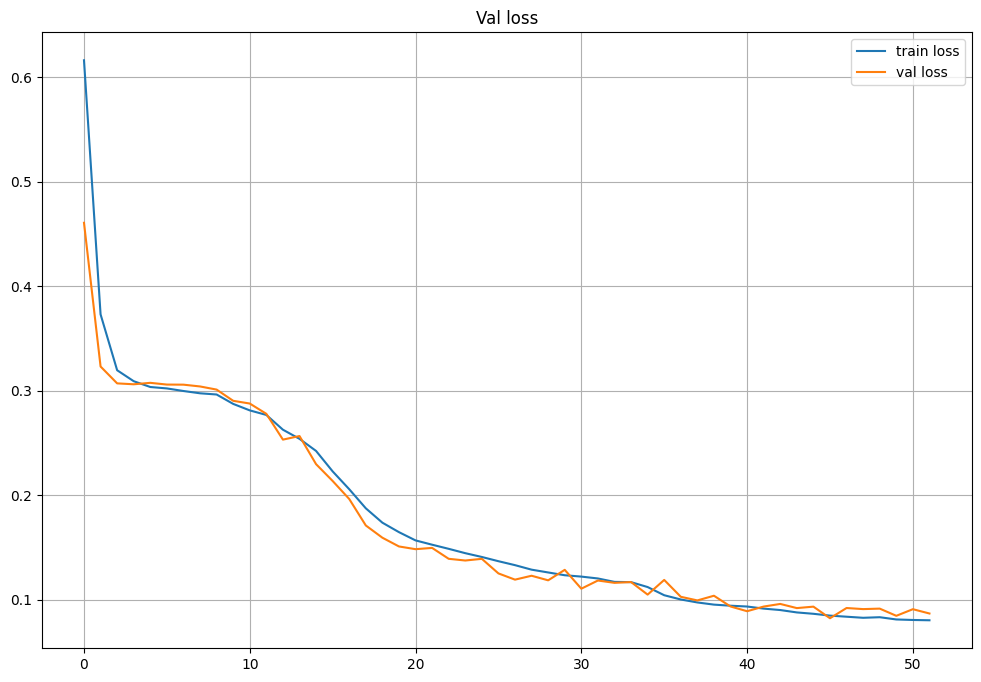

EPOCH 53:
batch / 1000: 1
LOSS train 0.07891564653616127 valid 0.08241739869117737


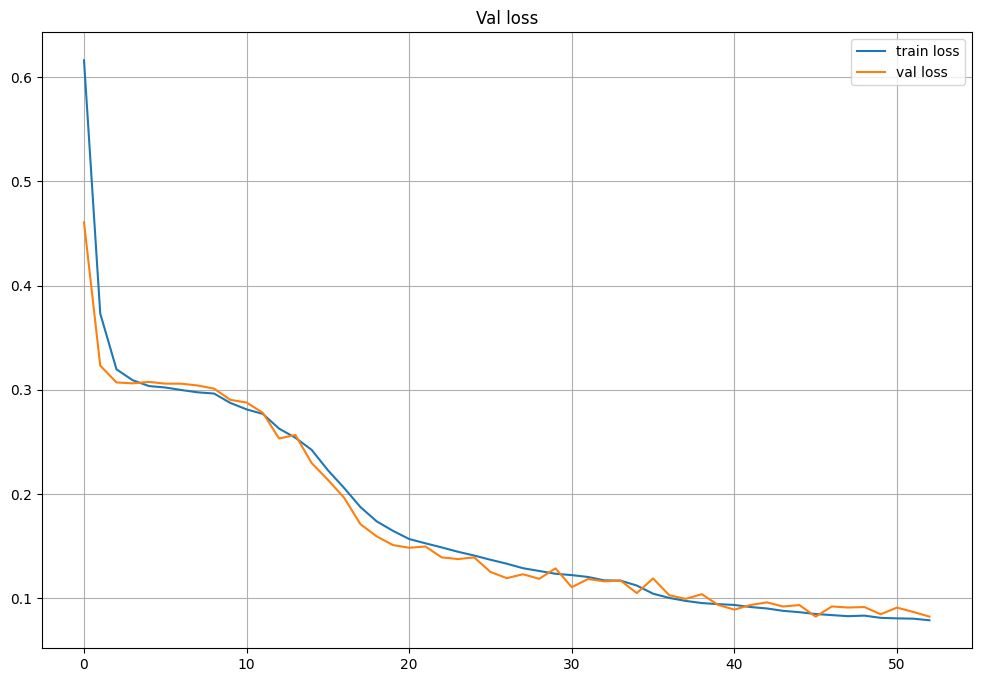

EPOCH 54:
batch / 1000: 1
LOSS train 0.0805428650965438 valid 0.0946563184261322


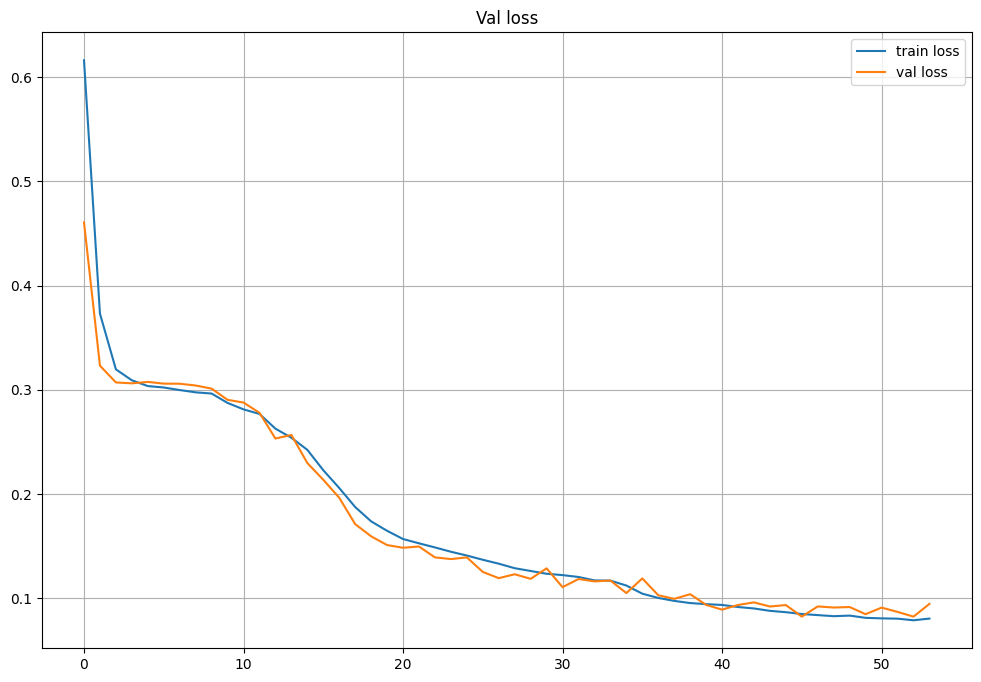

EPOCH 55:
batch / 1000: 1
LOSS train 0.07873201211737892 valid 0.0887276753783226


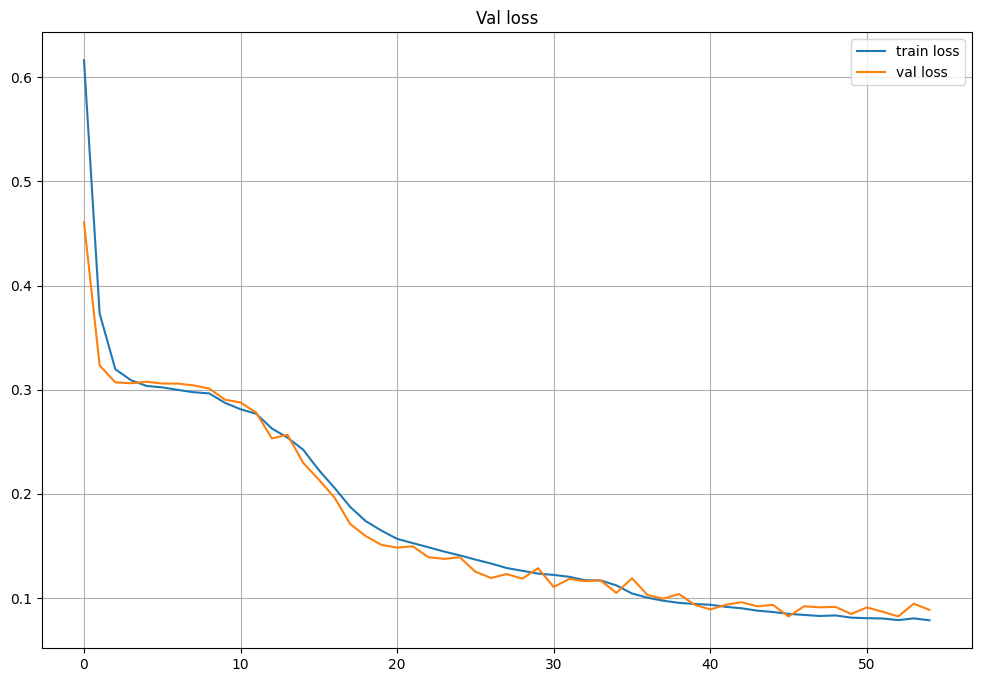

EPOCH 56:
batch / 1000: 1
LOSS train 0.07800285618817503 valid 0.0875932052731514


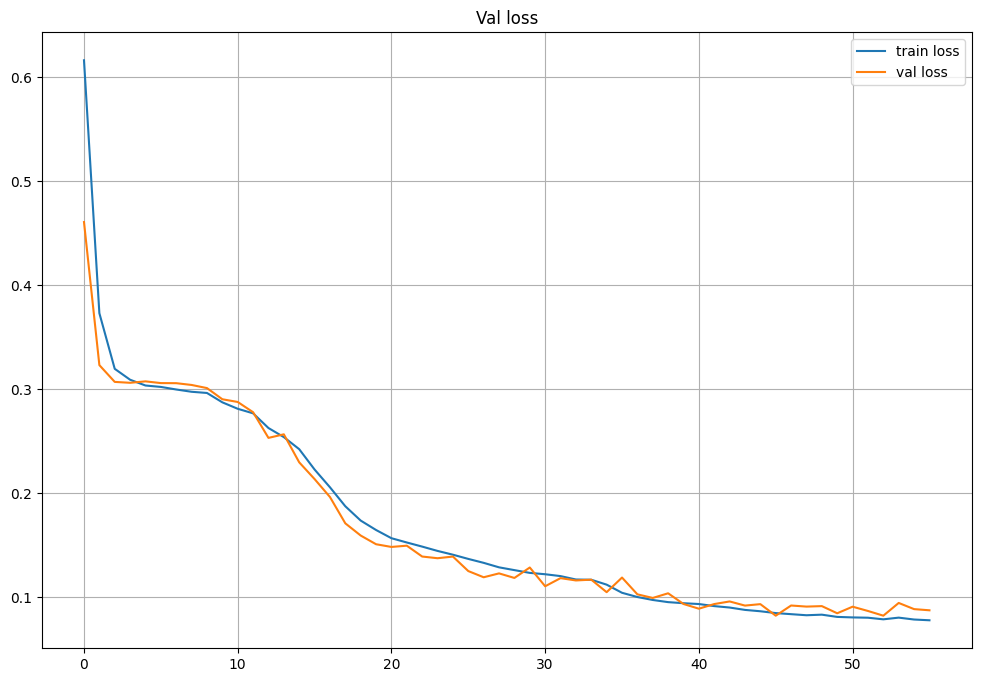

EPOCH 57:
batch / 1000: 1
LOSS train 0.07853132878584784 valid 0.08576703071594238


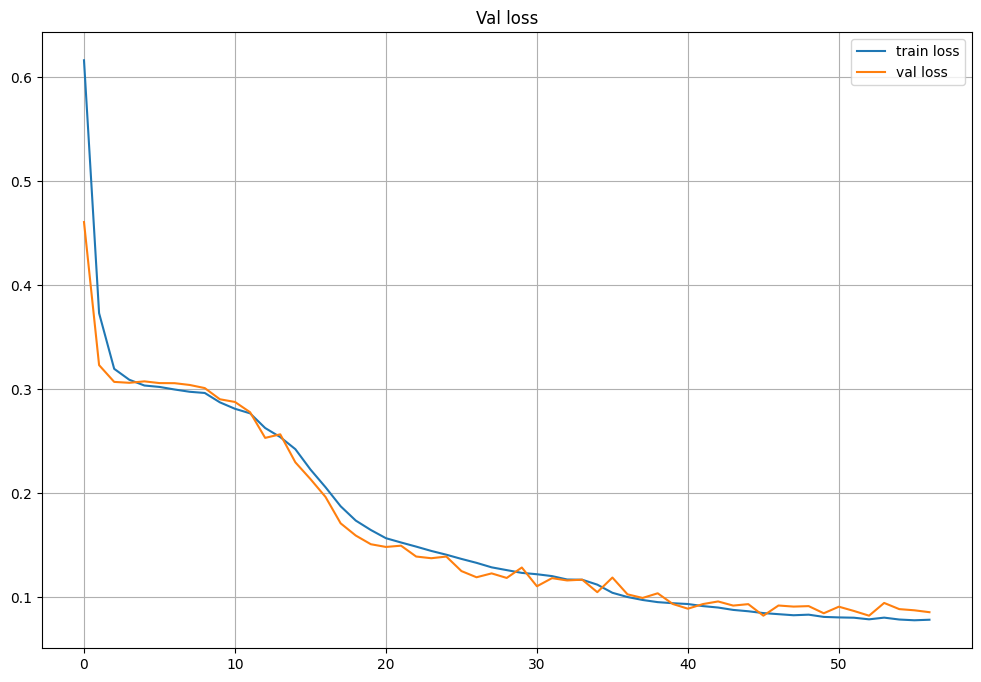

EPOCH 58:
batch / 1000: 1
LOSS train 0.07798607809022967 valid 0.09064072370529175


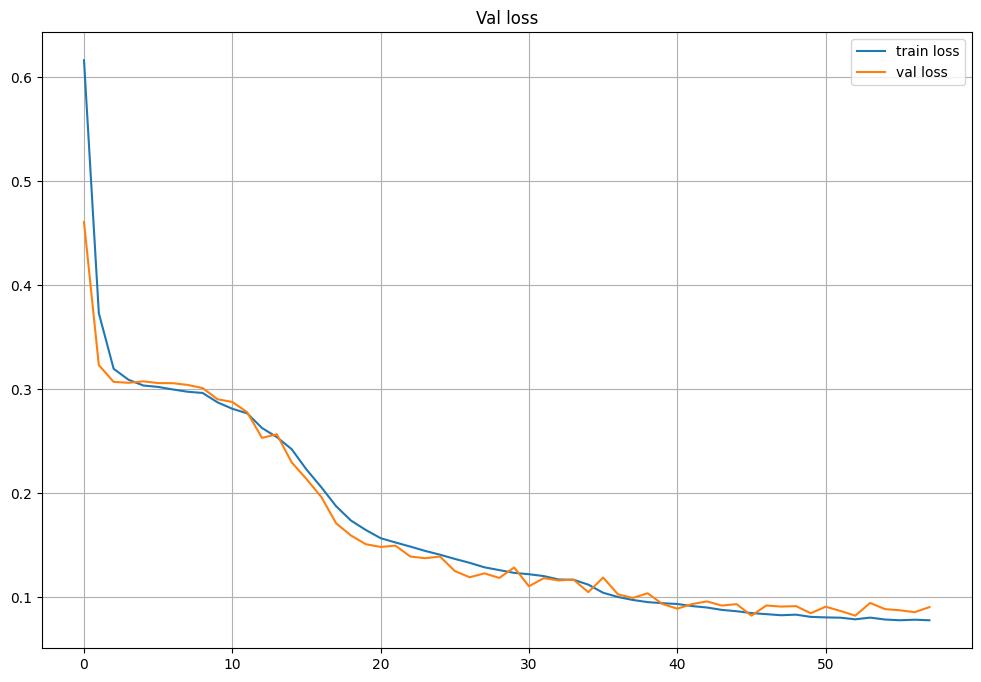

EPOCH 59:
batch / 1000: 1
LOSS train 0.07806056099561338 valid 0.08486995100975037


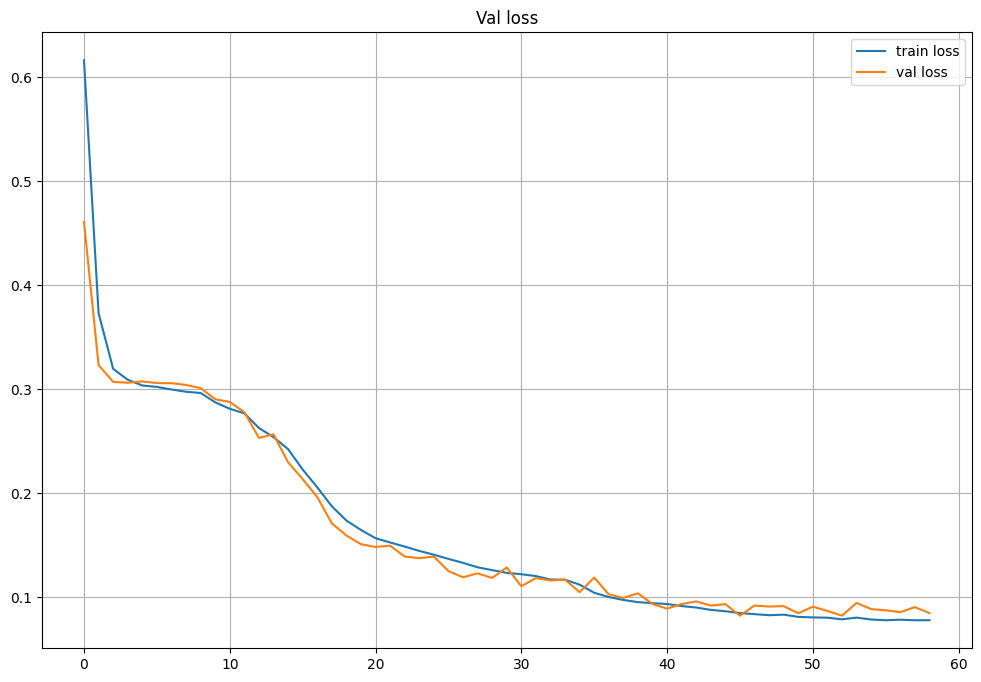

EPOCH 60:
batch / 1000: 1
LOSS train 0.07754524827826209 valid 0.08188741654157639


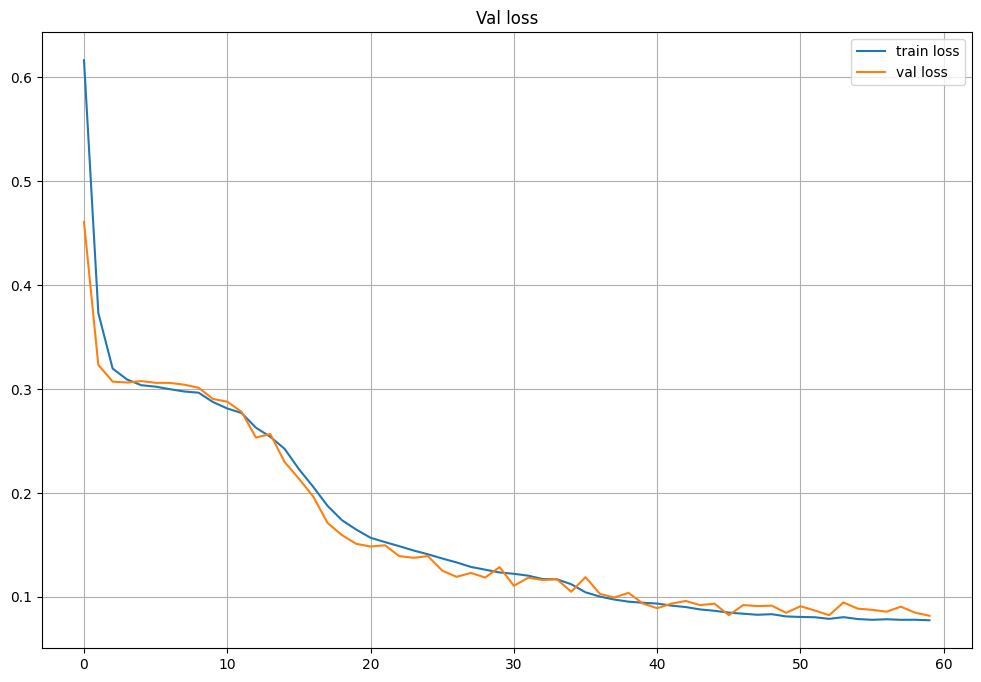

EPOCH 61:
batch / 1000: 1
LOSS train 0.07729702133049847 valid 0.0784771665930748


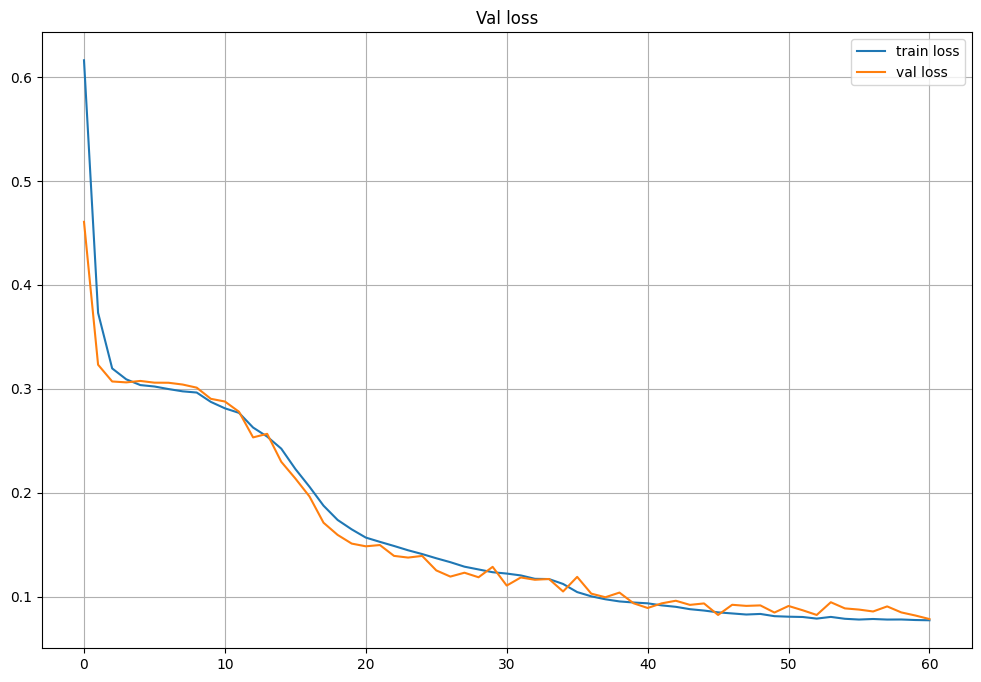

EPOCH 62:
batch / 1000: 1
LOSS train 0.0778645750953367 valid 0.08305051922798157


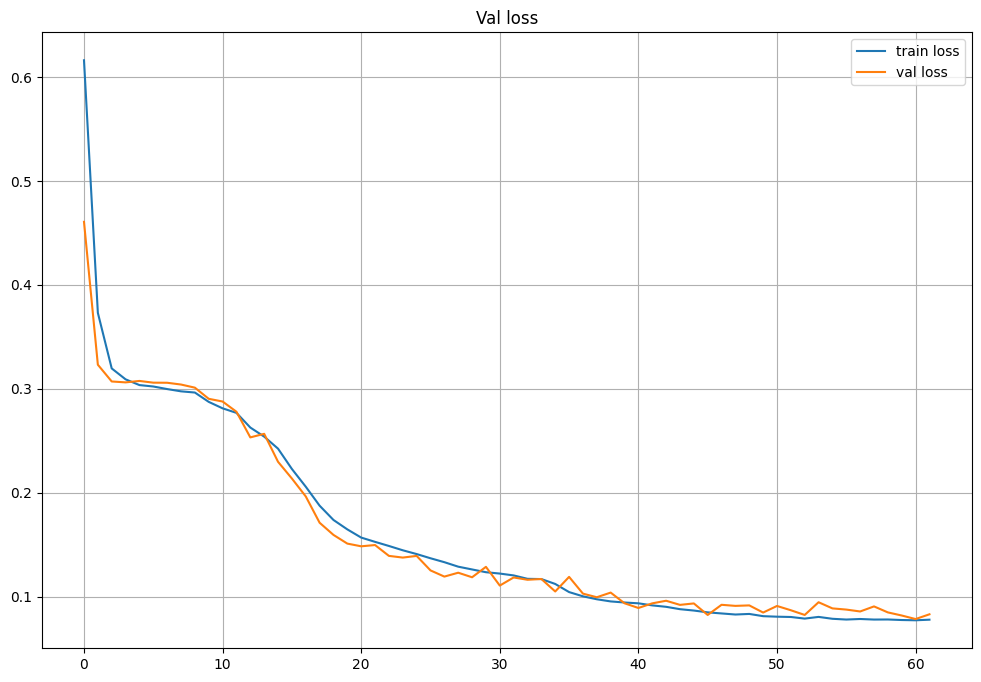

EPOCH 63:
batch / 1000: 1
LOSS train 0.07512203407527891 valid 0.08014927059412003


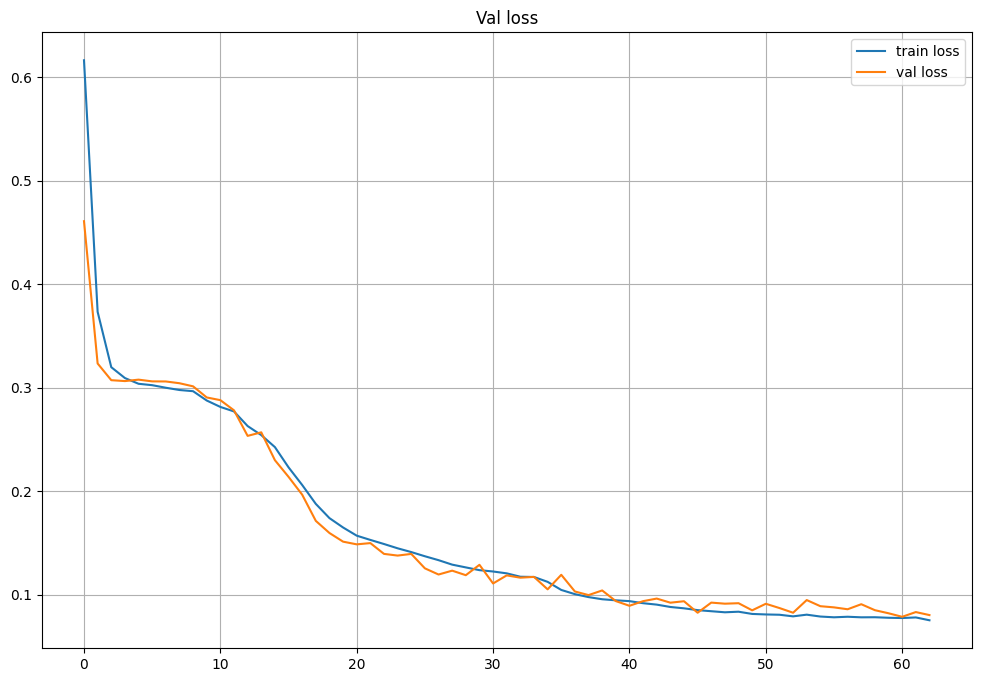

EPOCH 64:
batch / 1000: 1
LOSS train 0.07532826399148186 valid 0.07613128423690796


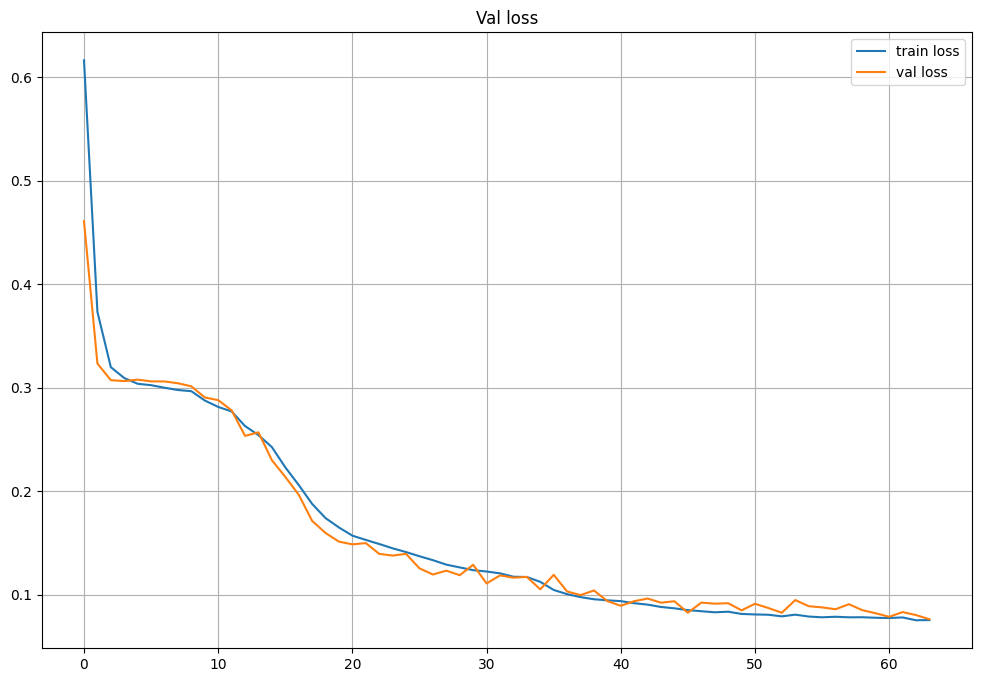

EPOCH 65:
batch / 1000: 1
LOSS train 0.07490777528787536 valid 0.08371314406394958


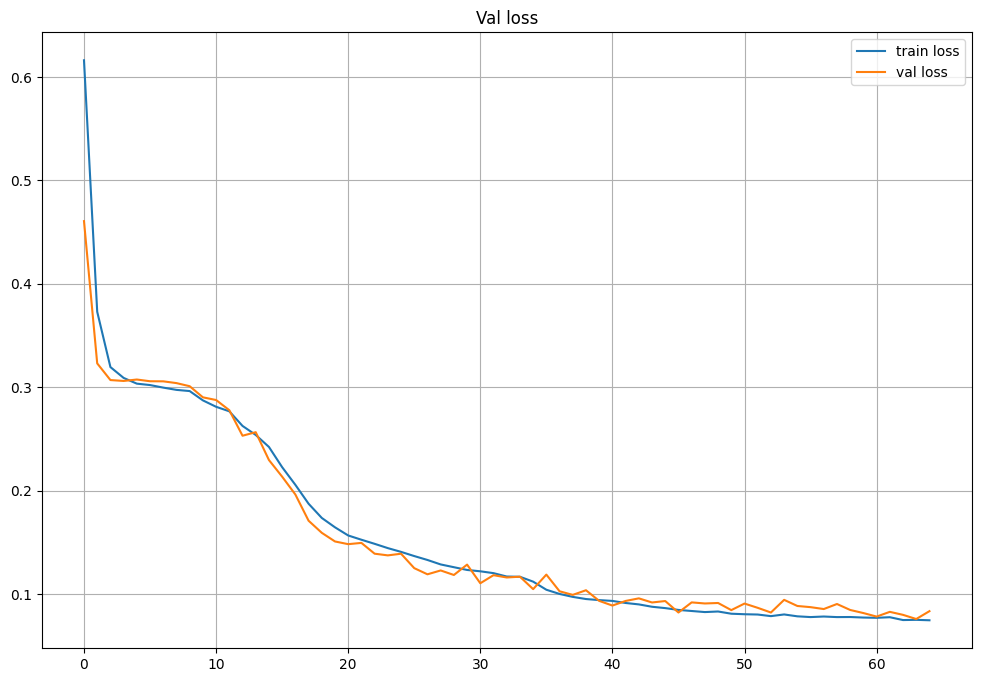

EPOCH 66:
batch / 1000: 1
LOSS train 0.07428781927142256 valid 0.07935209572315216


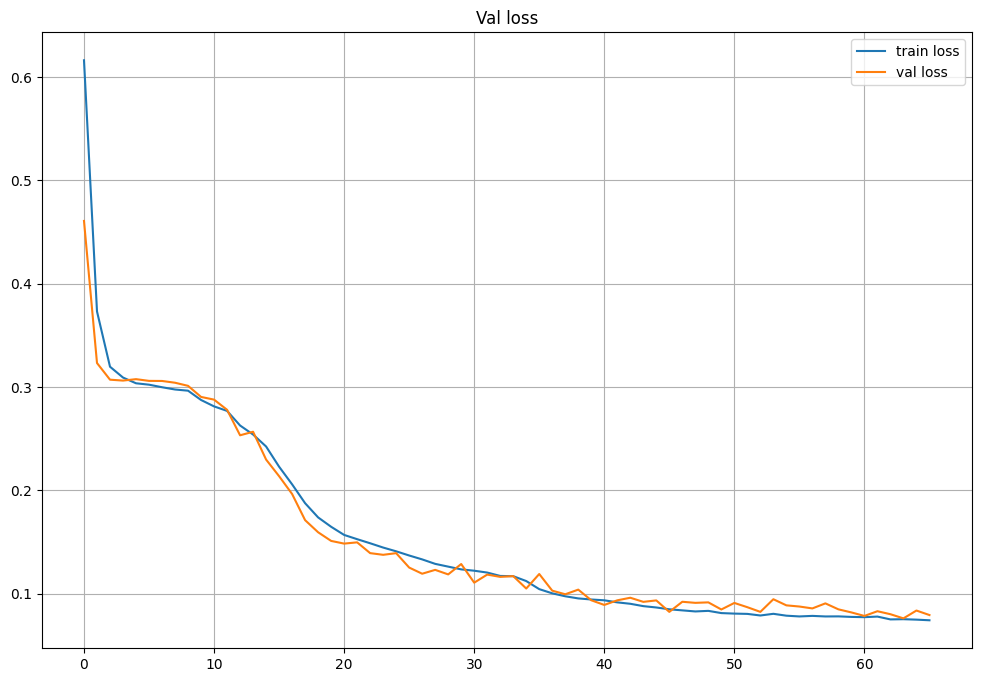

EPOCH 67:
batch / 1000: 1
LOSS train 0.0737610732281173 valid 0.0798732116818428


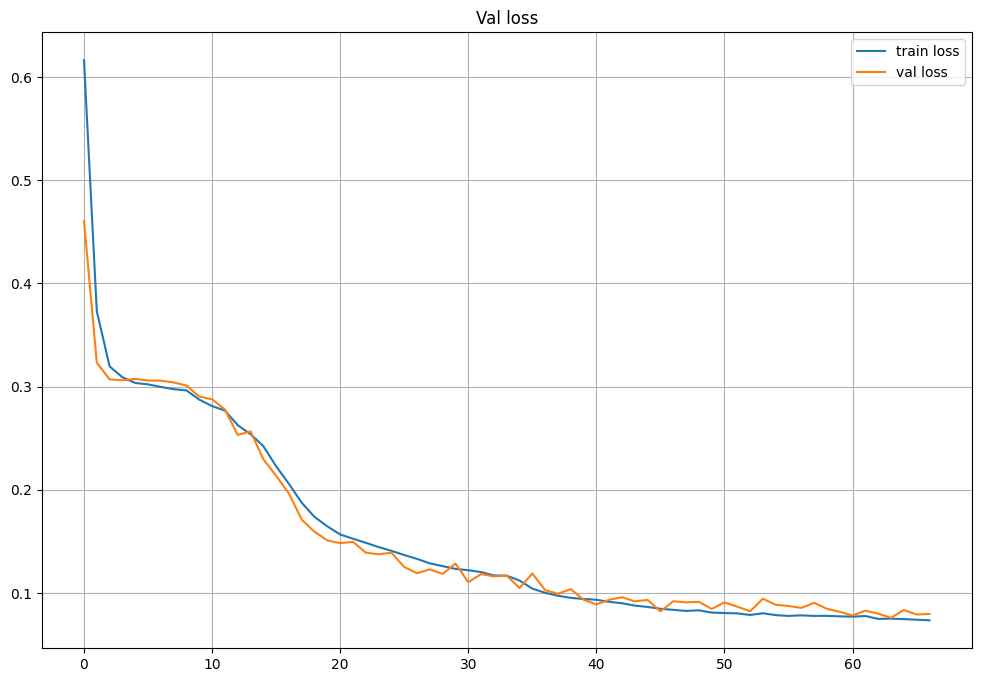

EPOCH 68:
batch / 1000: 1
LOSS train 0.07295401461849321 valid 0.07923956960439682


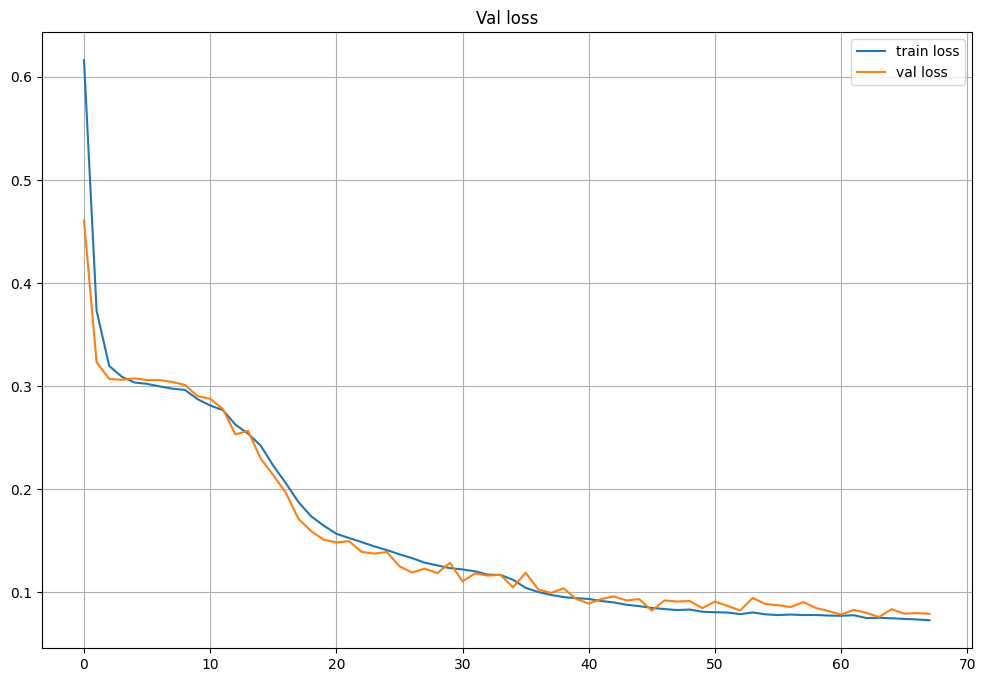

EPOCH 69:
batch / 1000: 1
LOSS train 0.07322698551225318 valid 0.0865369588136673


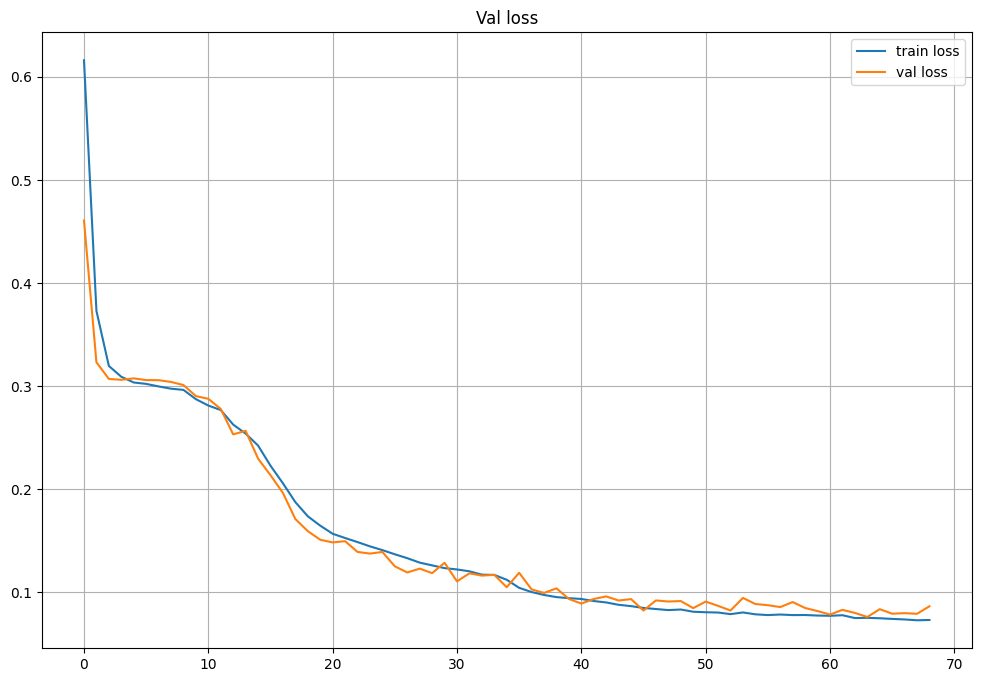

EPOCH 70:
batch / 1000: 1
LOSS train 0.07301302055097017 valid 0.08843480050563812


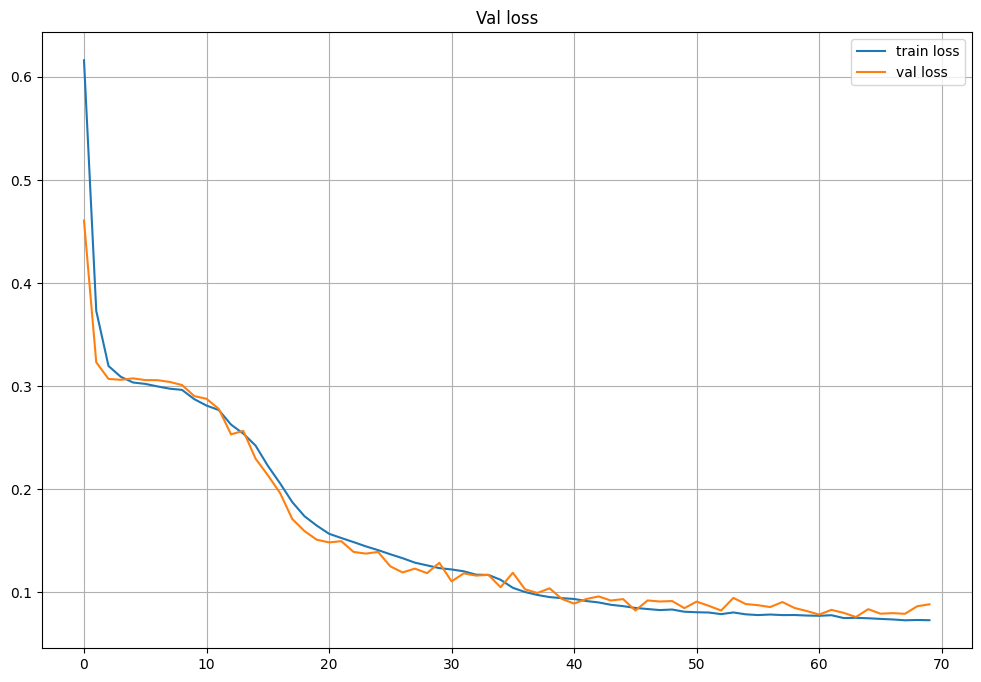

EPOCH 71:
batch / 1000: 1
LOSS train 0.07202382031362771 valid 0.07707659900188446


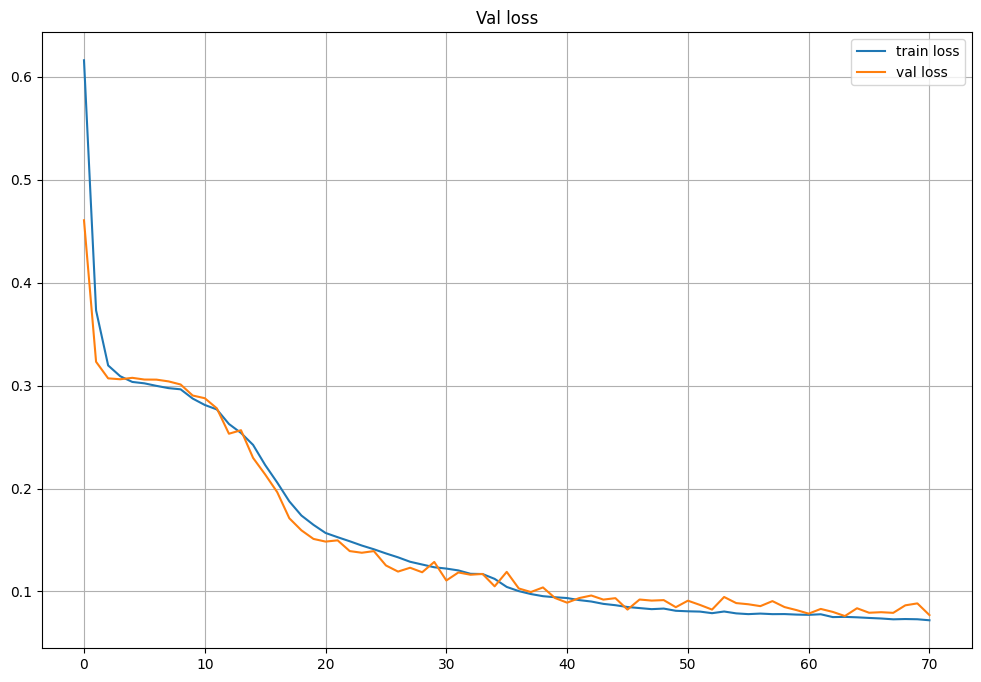

EPOCH 72:
batch / 1000: 1
LOSS train 0.07261081163502378 valid 0.08520278334617615


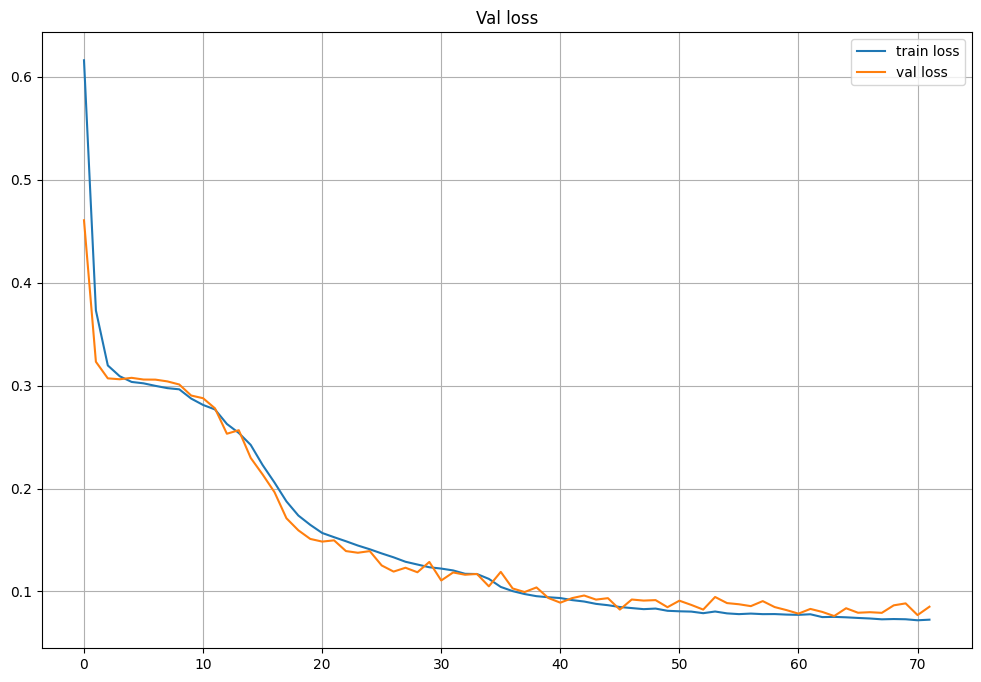

EPOCH 73:
batch / 1000: 1
LOSS train 0.07275933894290793 valid 0.08367924392223358


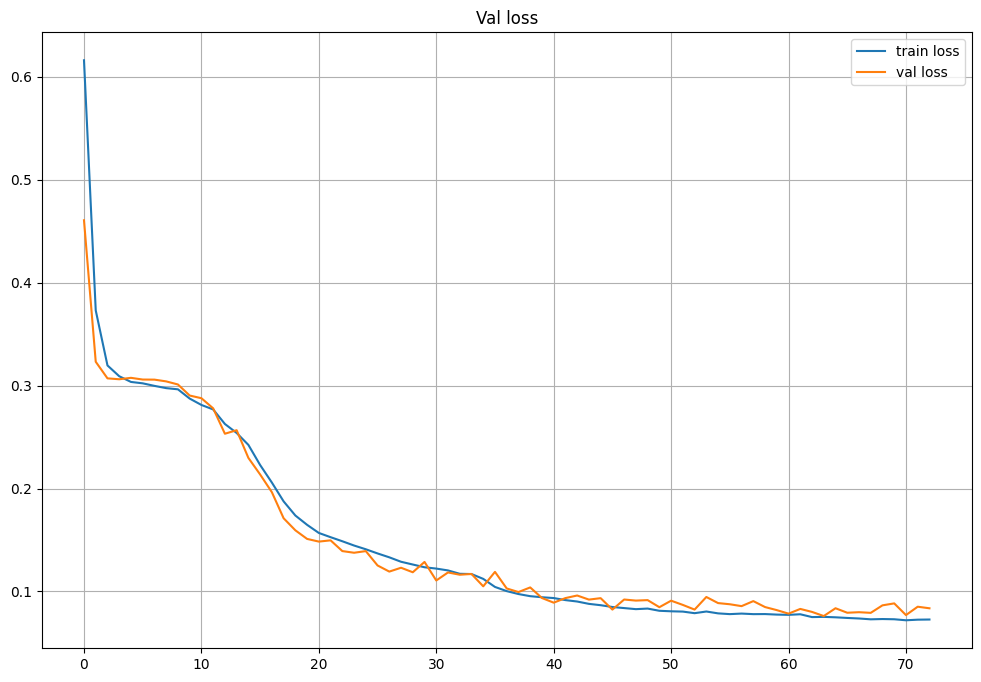

EPOCH 74:
batch / 1000: 1
LOSS train 0.07240402503666617 valid 0.07657895982265472


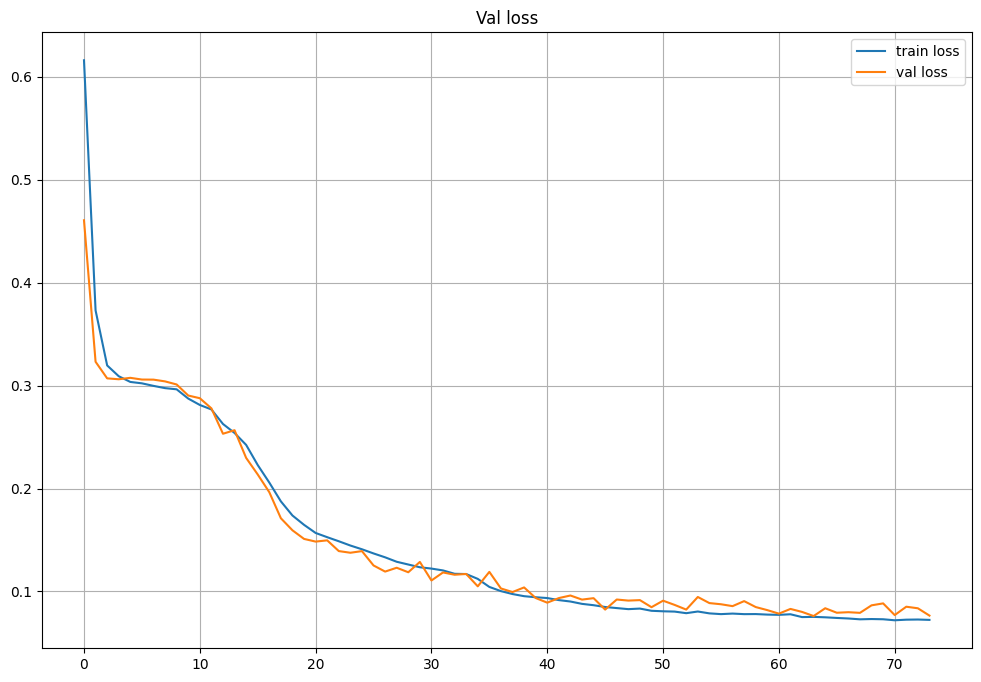

EPOCH 75:
batch / 1000: 1
LOSS train 0.07296032737004413 valid 0.08504685014486313


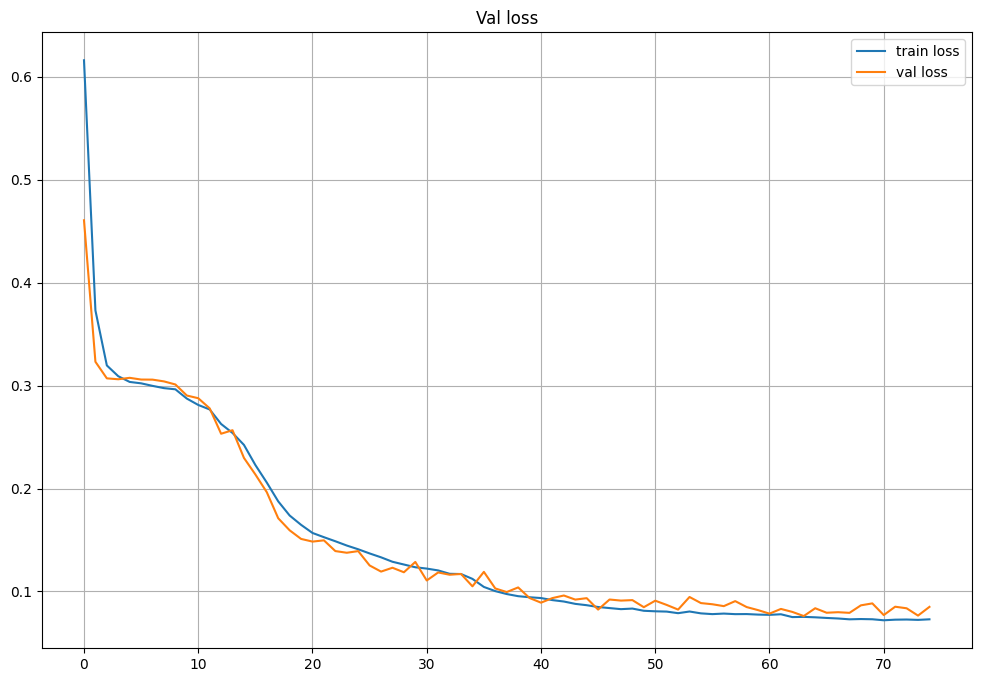

EPOCH 76:
batch / 1000: 1
LOSS train 0.07271817196476167 valid 0.07900742441415787


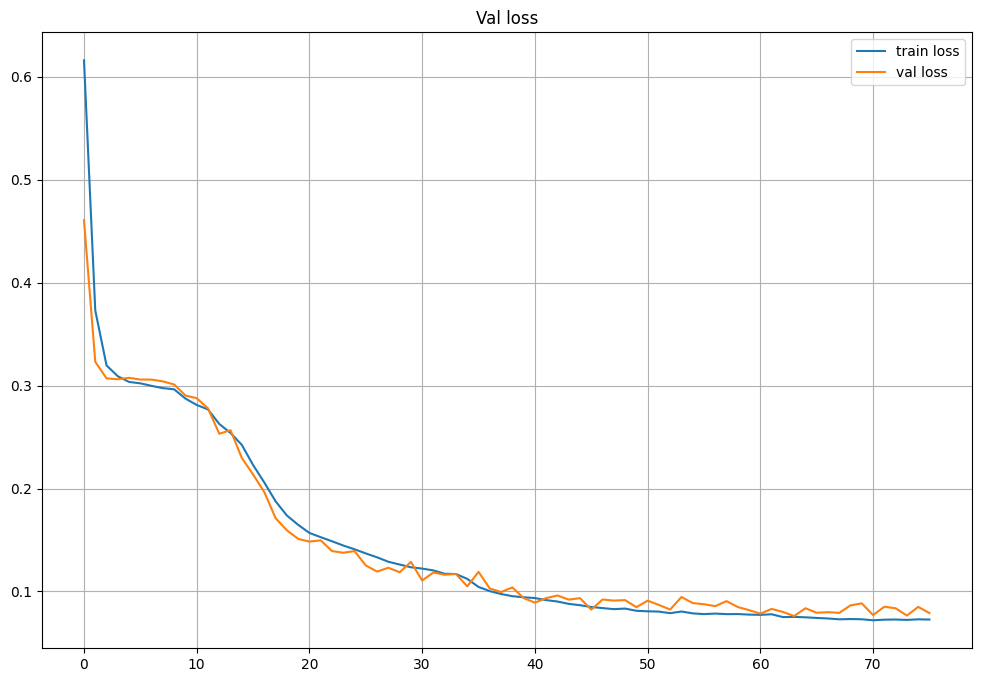

EPOCH 77:
batch / 1000: 1
LOSS train 0.07335377181331867 valid 0.08414432406425476


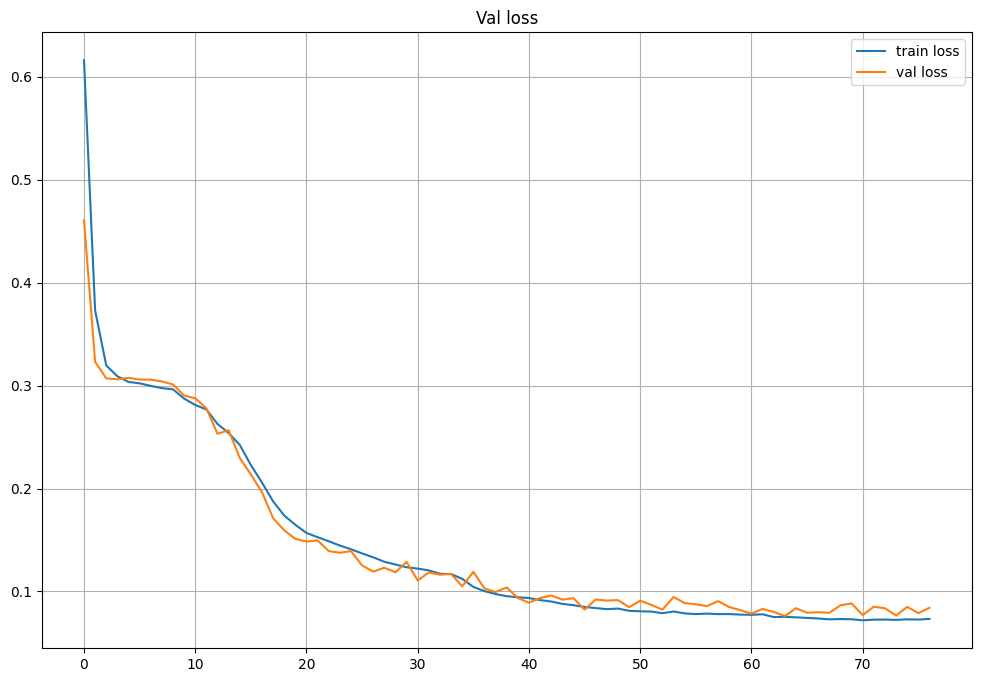

EPOCH 78:
batch / 1000: 1
LOSS train 0.07088792533734102 valid 0.08337011933326721


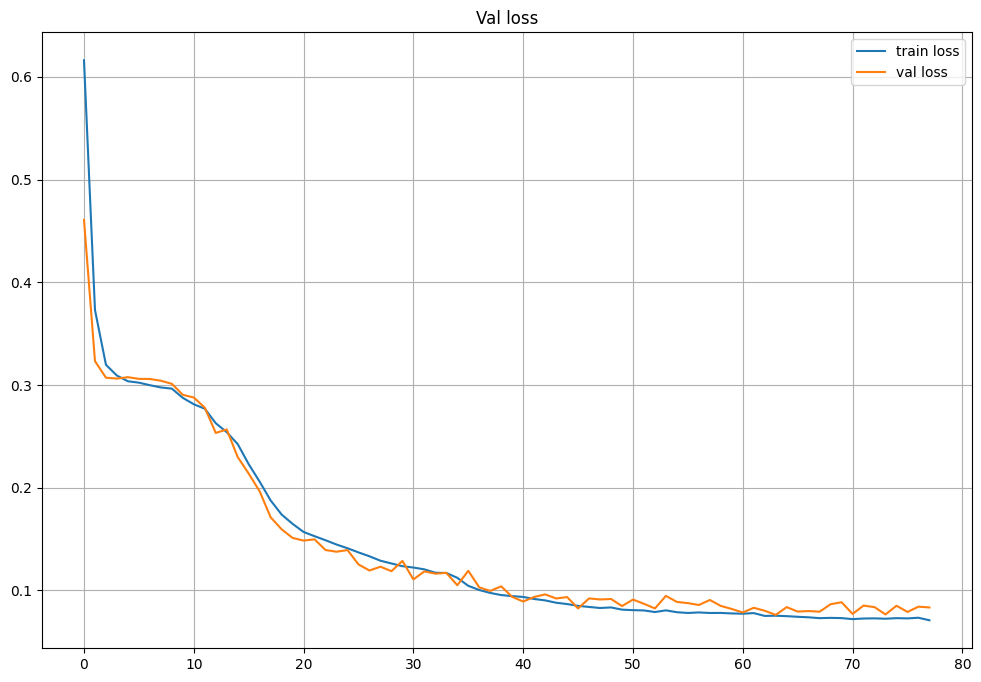

EPOCH 79:
batch / 1000: 1
LOSS train 0.07337346326748079 valid 0.07497970759868622


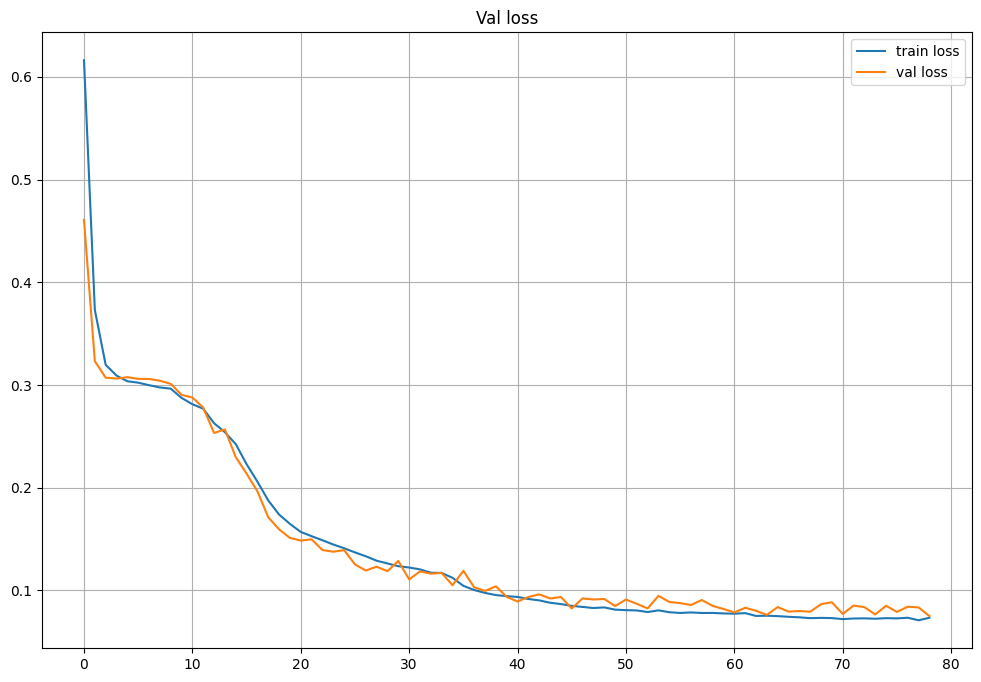

EPOCH 80:
batch / 1000: 1
LOSS train 0.07178115066823468 valid 0.07399135082960129


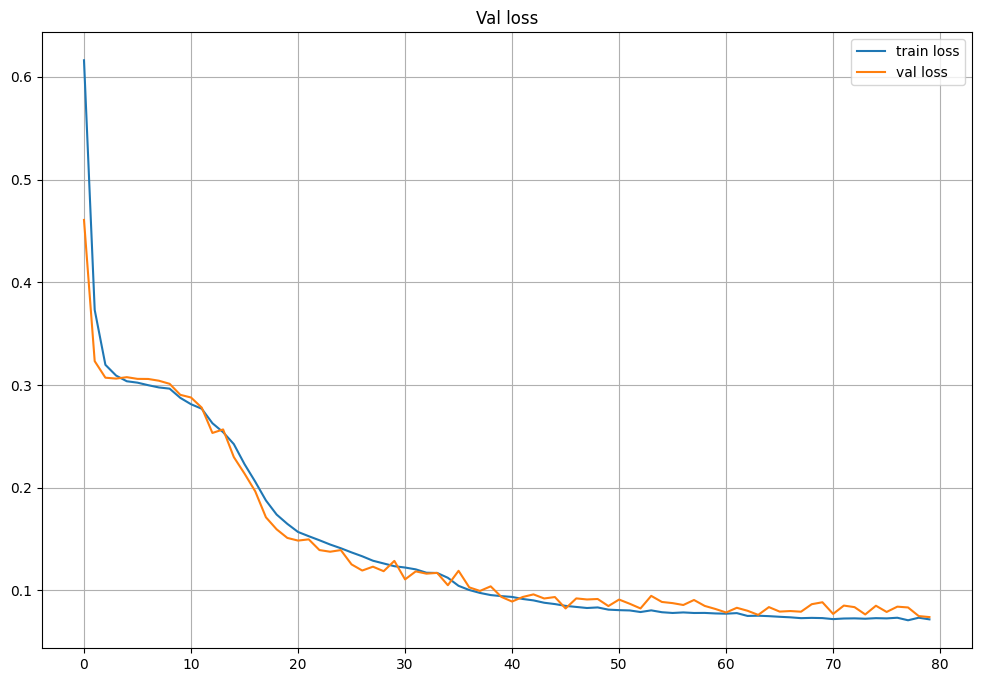

EPOCH 81:
batch / 1000: 1
LOSS train 0.07097687993101275 valid 0.08819112926721573


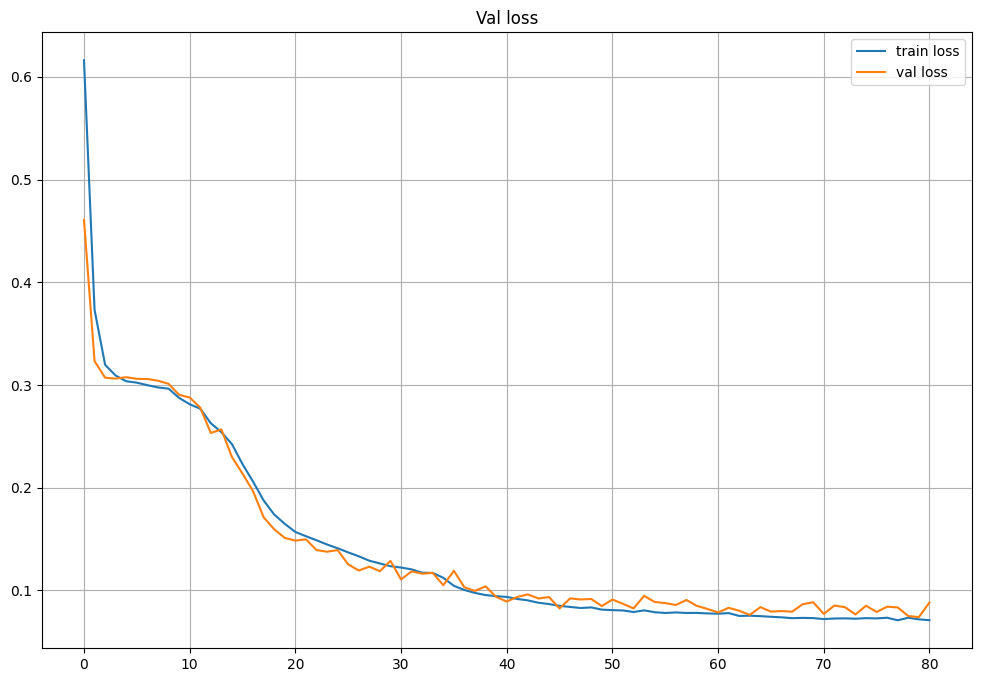

EPOCH 82:
batch / 1000: 1
LOSS train 0.0718113815025167 valid 0.0806136280298233


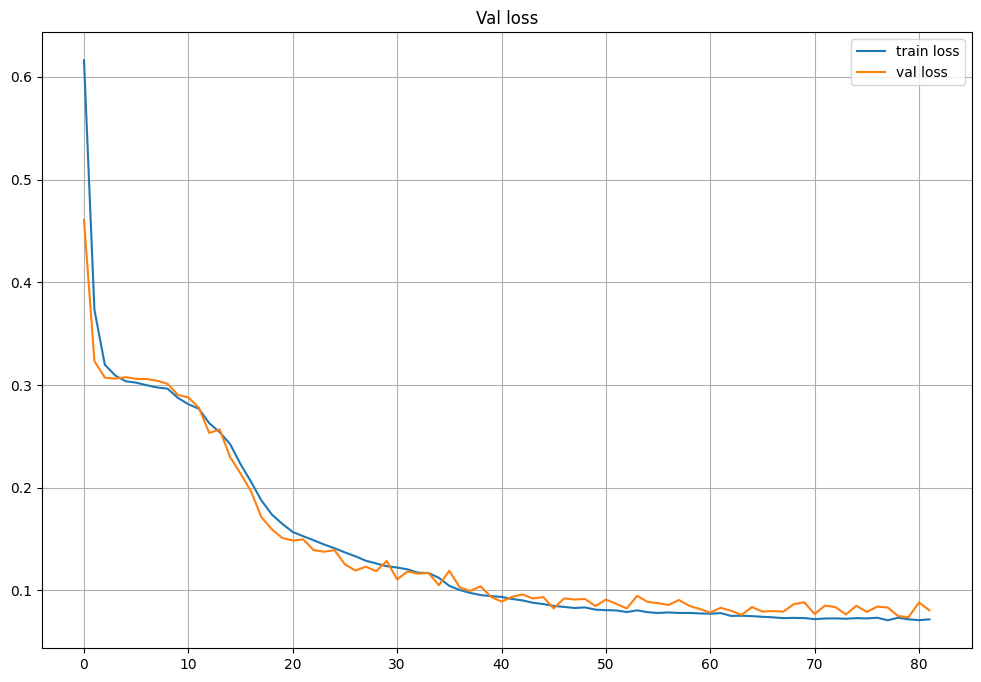

EPOCH 83:
batch / 1000: 1
LOSS train 0.07115749820038711 valid 0.08016007393598557


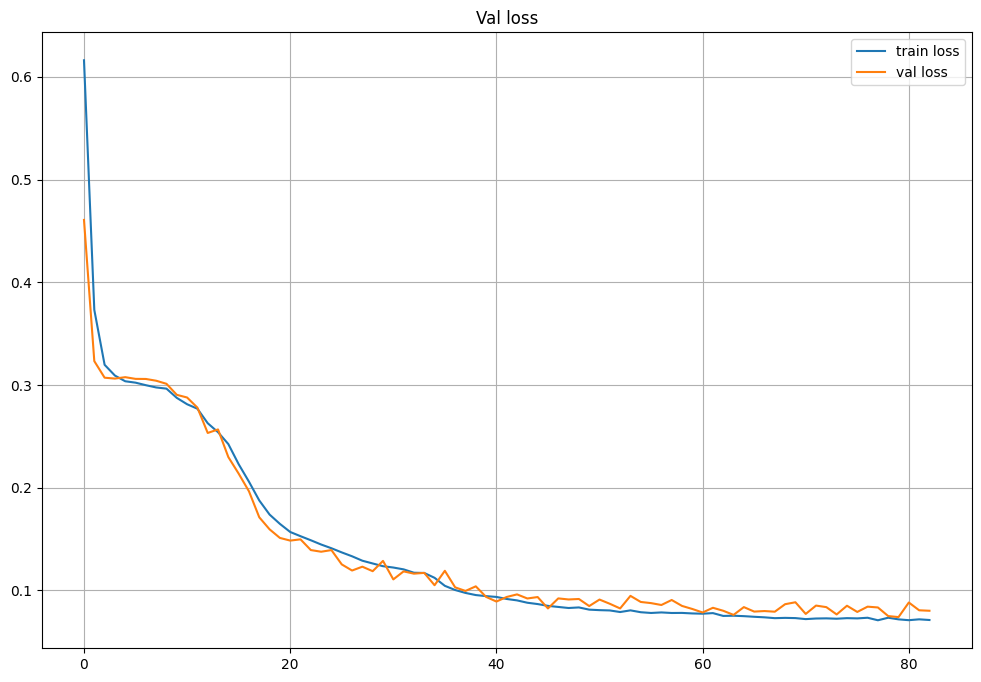

EPOCH 84:
batch / 1000: 1
LOSS train 0.07087784985830341 valid 0.0873970314860344


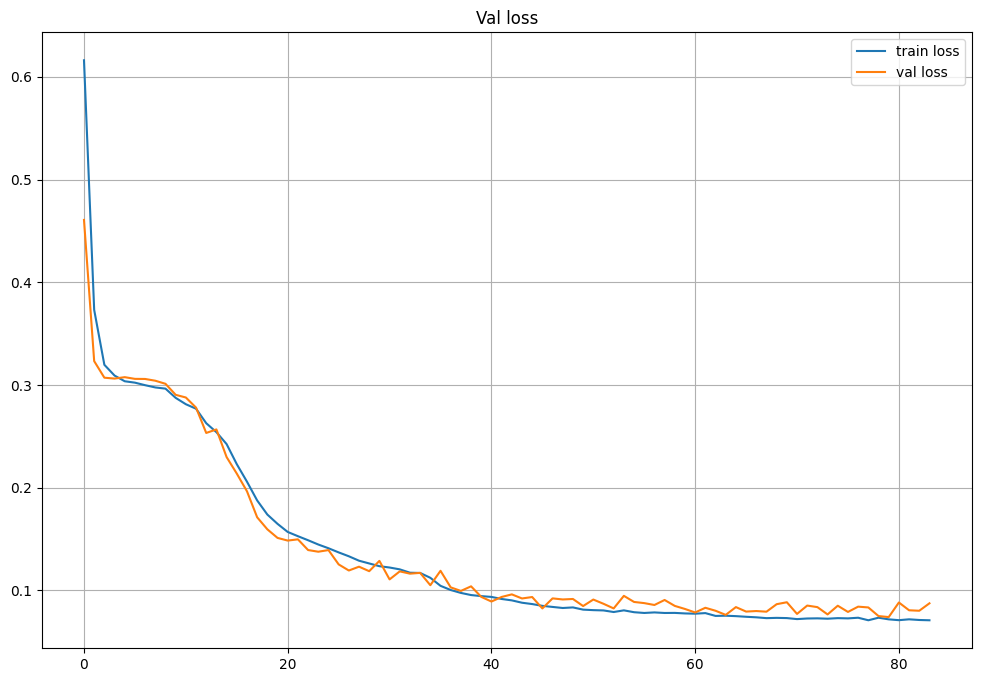

EPOCH 85:
batch / 1000: 1
LOSS train 0.06996145073457107 valid 0.07430137693881989


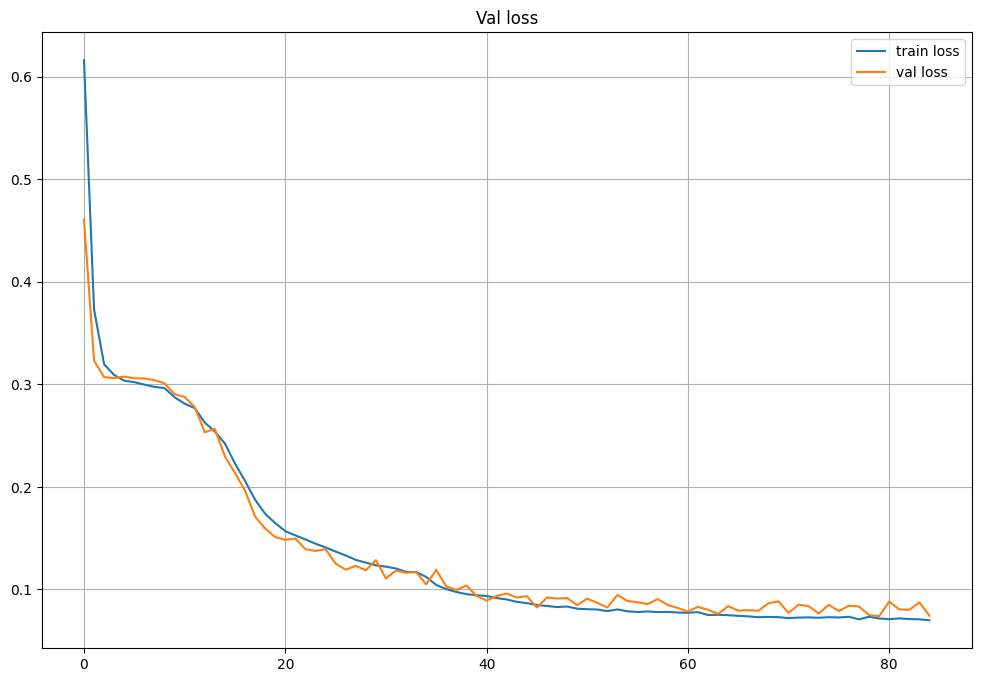

EPOCH 86:
batch / 1000: 1
LOSS train 0.07005431936783123 valid 0.07976119965314865


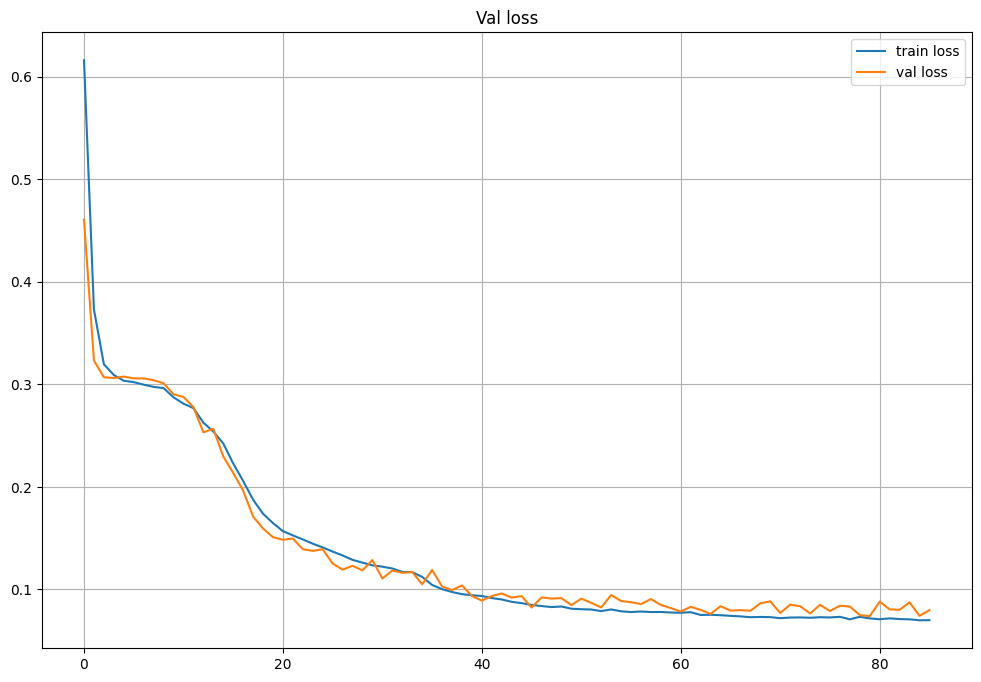

EPOCH 87:
batch / 1000: 1
LOSS train 0.07030937978024245 valid 0.08536361157894135


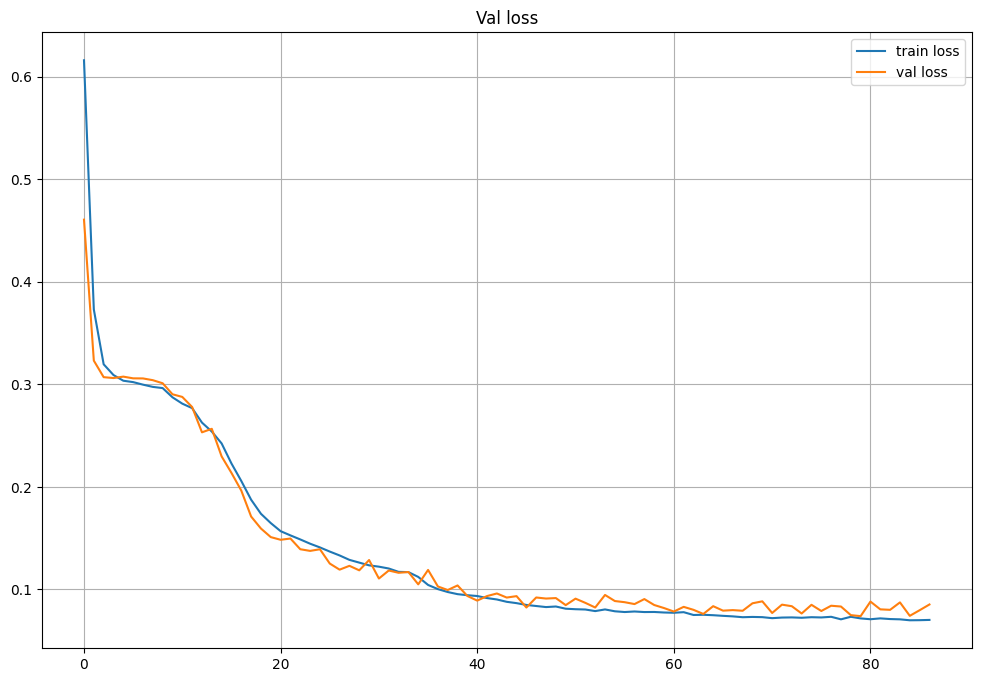

EPOCH 88:
batch / 1000: 1
LOSS train 0.07026861008847242 valid 0.09769539535045624


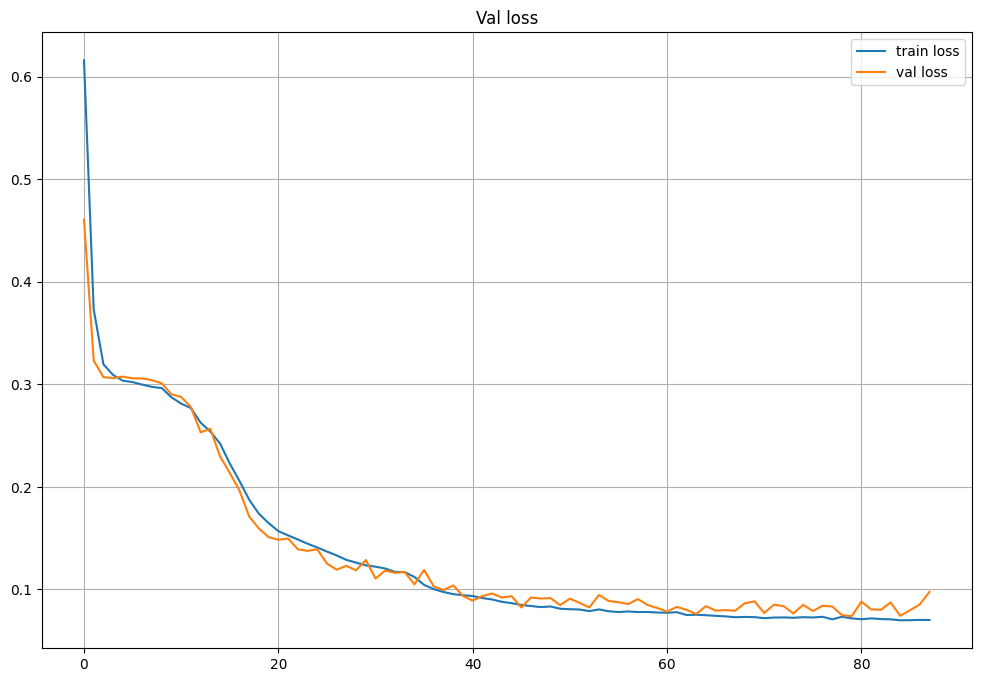

EPOCH 89:
batch / 1000: 1
LOSS train 0.0701318278126119 valid 0.07850025594234467


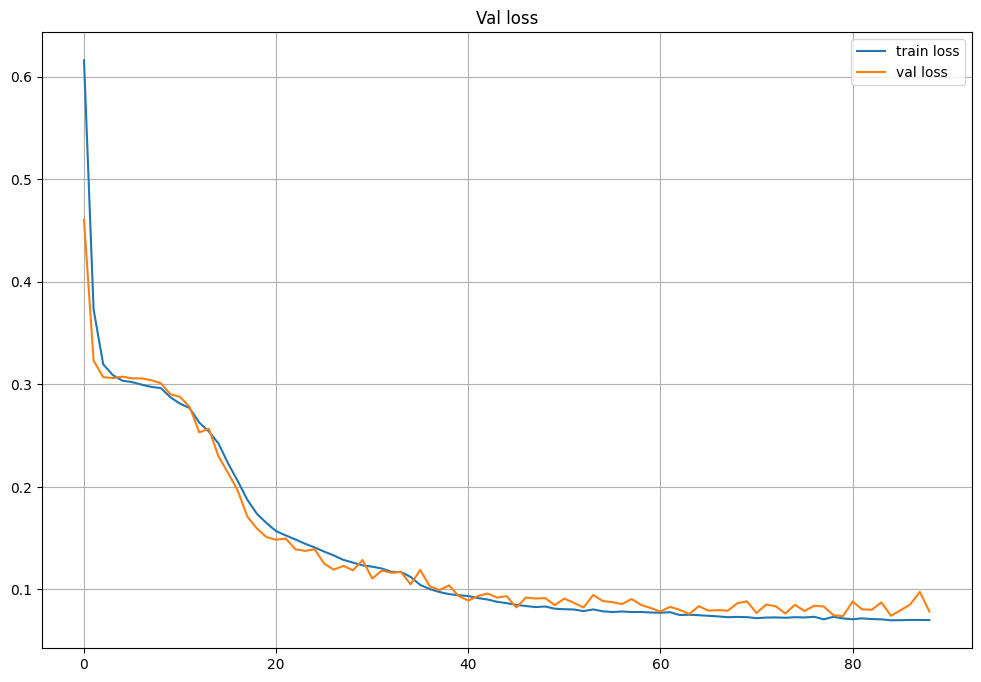

EPOCH 90:
batch / 1000: 1
LOSS train 0.07073359645979072 valid 0.08220157027244568


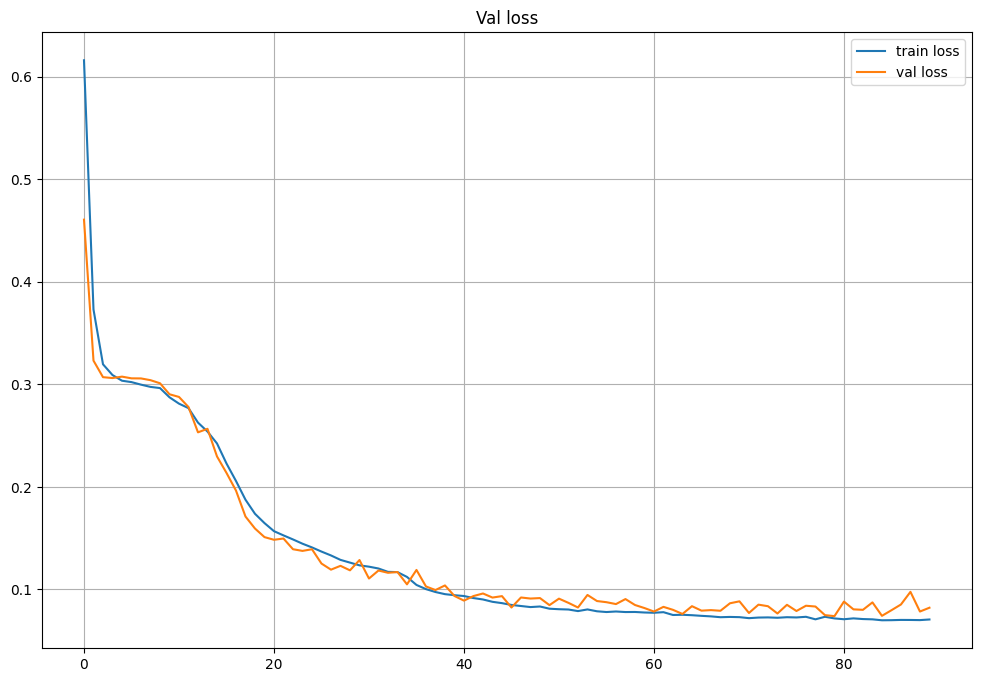

EPOCH 91:
batch / 1000: 1
LOSS train 0.06950348845641849 valid 0.0806472897529602


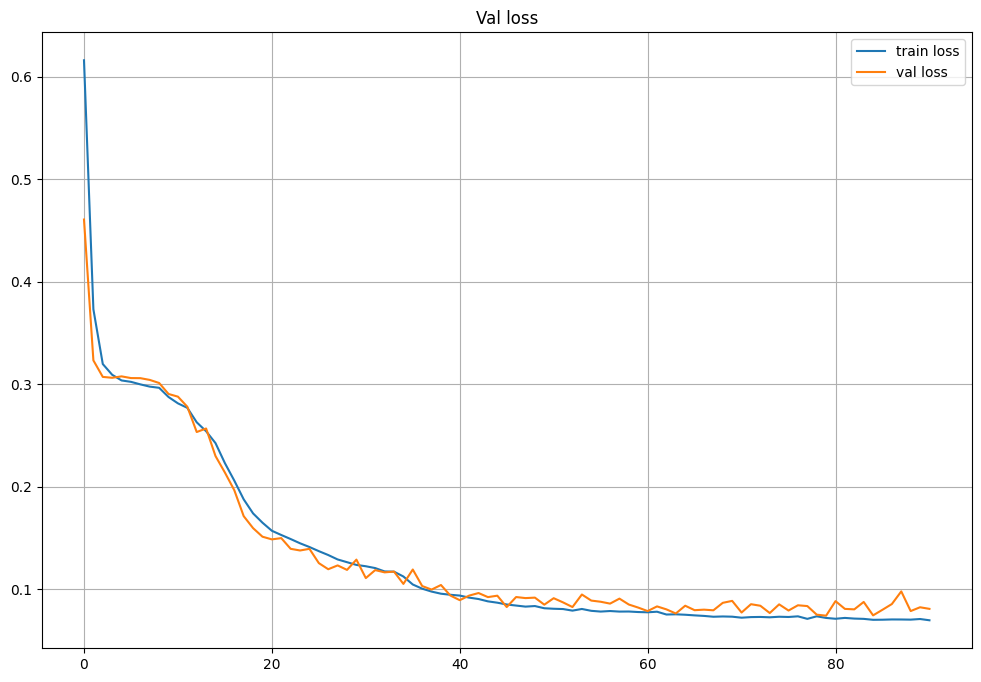

EPOCH 92:
batch / 1000: 1
LOSS train 0.06995175825833144 valid 0.07906029373407364


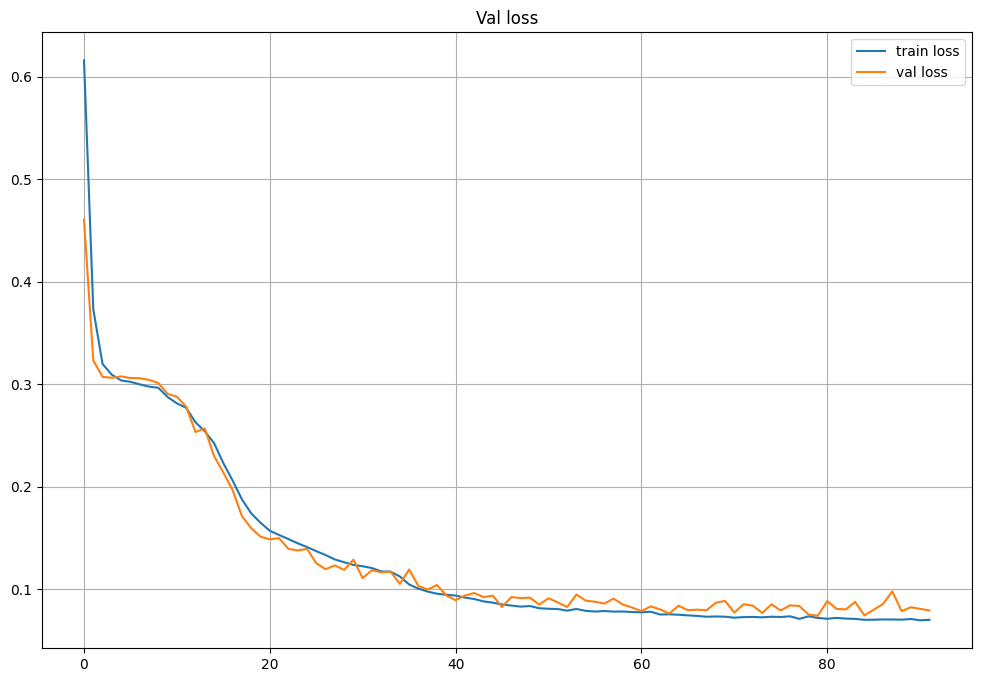

EPOCH 93:
batch / 1000: 1
LOSS train 0.06942724530054989 valid 0.08232134580612183


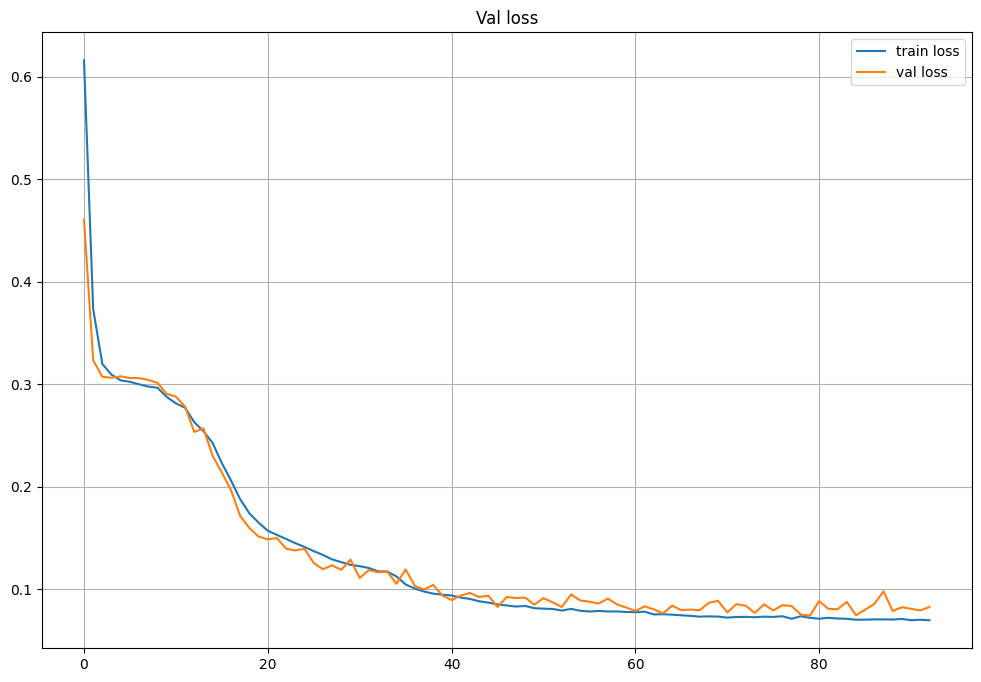

EPOCH 94:
batch / 1000: 1
LOSS train 0.06958563164938915 valid 0.07825064659118652


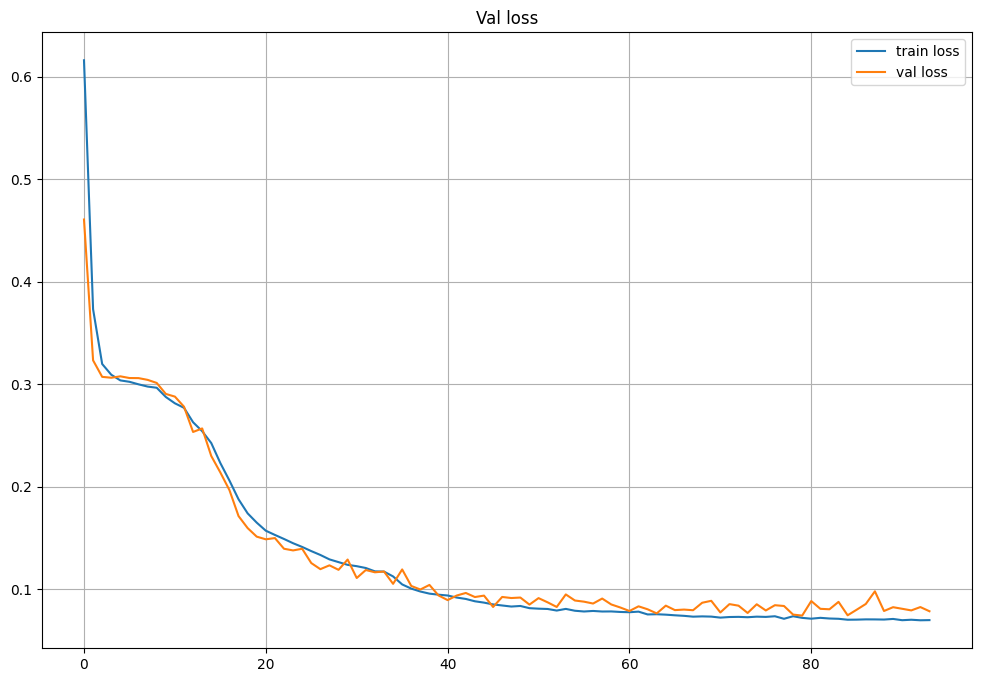

EPOCH 95:
batch / 1000: 1
LOSS train 0.06888146637224778 valid 0.09022333472967148


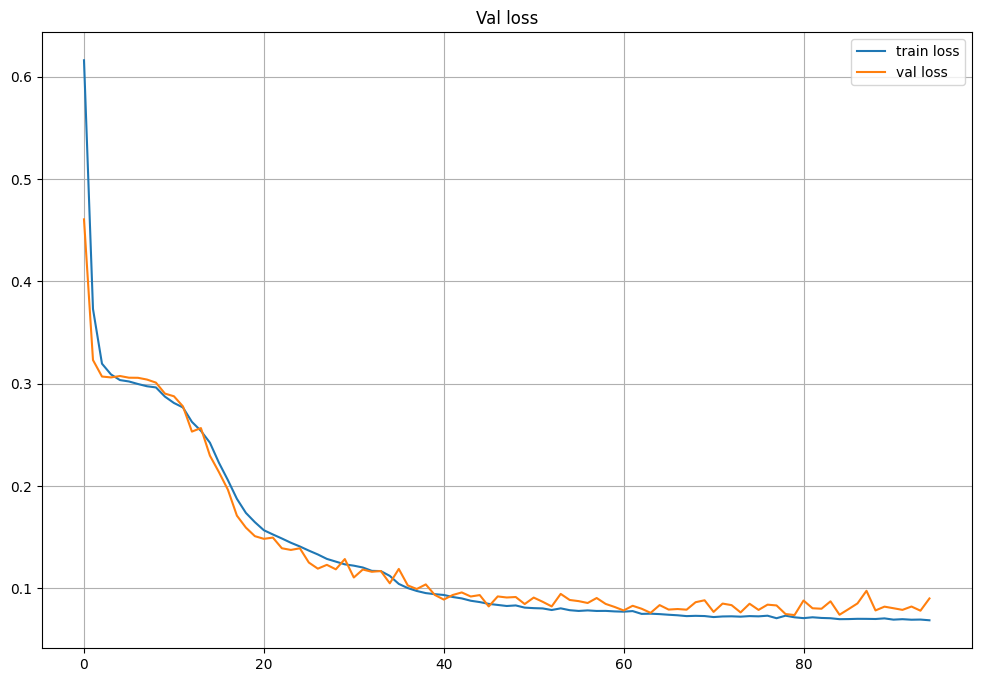

EPOCH 96:
batch / 1000: 1
LOSS train 0.06978242832975808 valid 0.07523253560066223


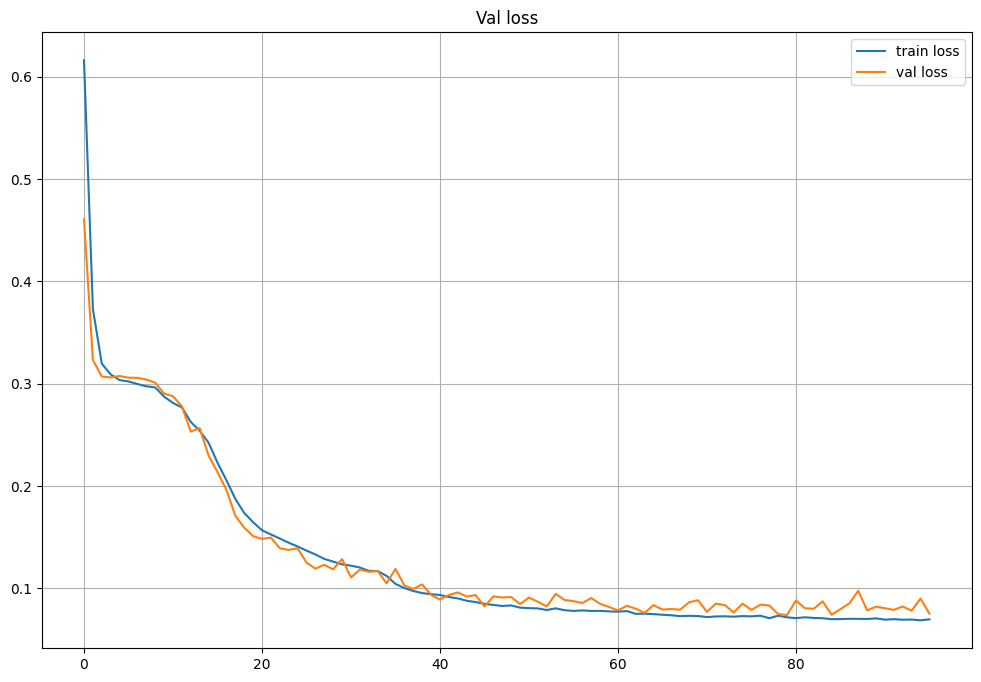

EPOCH 97:
batch / 1000: 1
LOSS train 0.07081685588780164 valid 0.10090257972478867


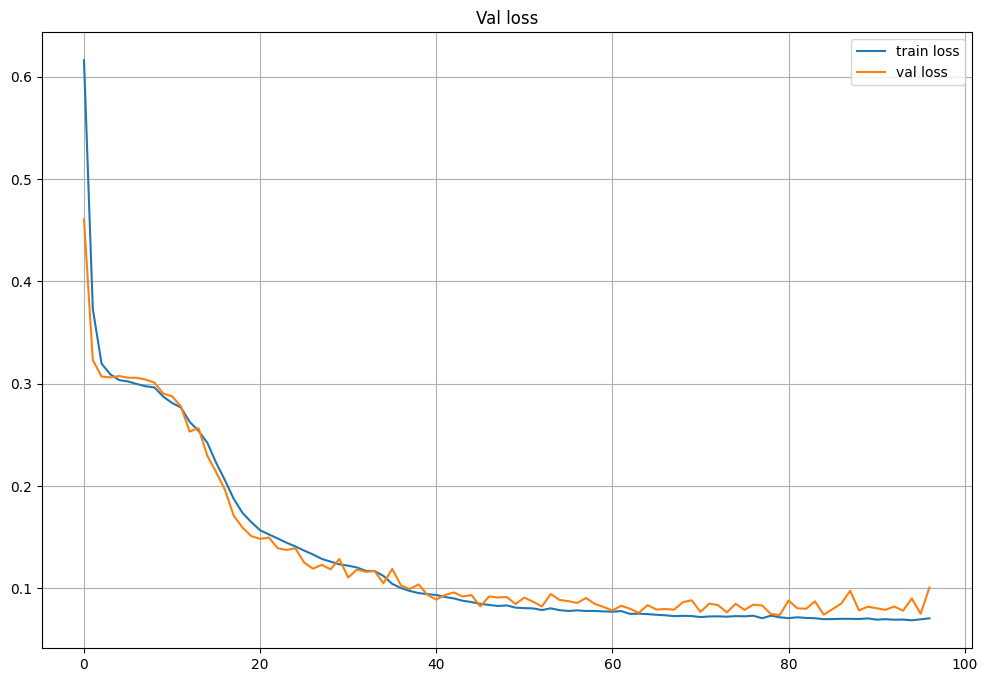

EPOCH 98:
batch / 1000: 1
LOSS train 0.07051727474687994 valid 0.07686907798051834


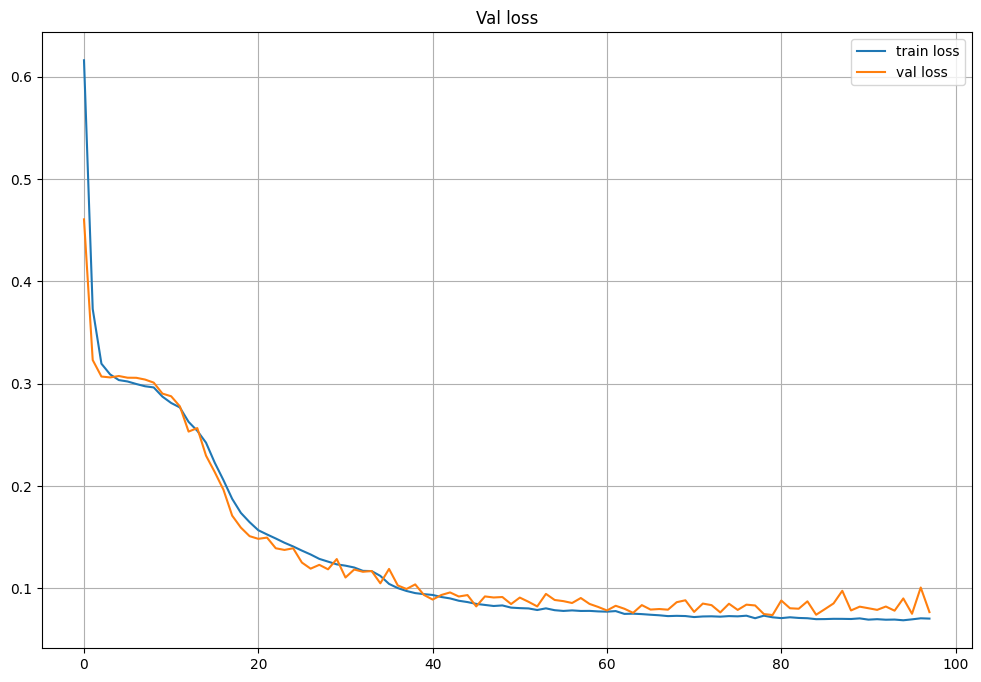

EPOCH 99:
batch / 1000: 1
LOSS train 0.07004140255521257 valid 0.07705134898424149


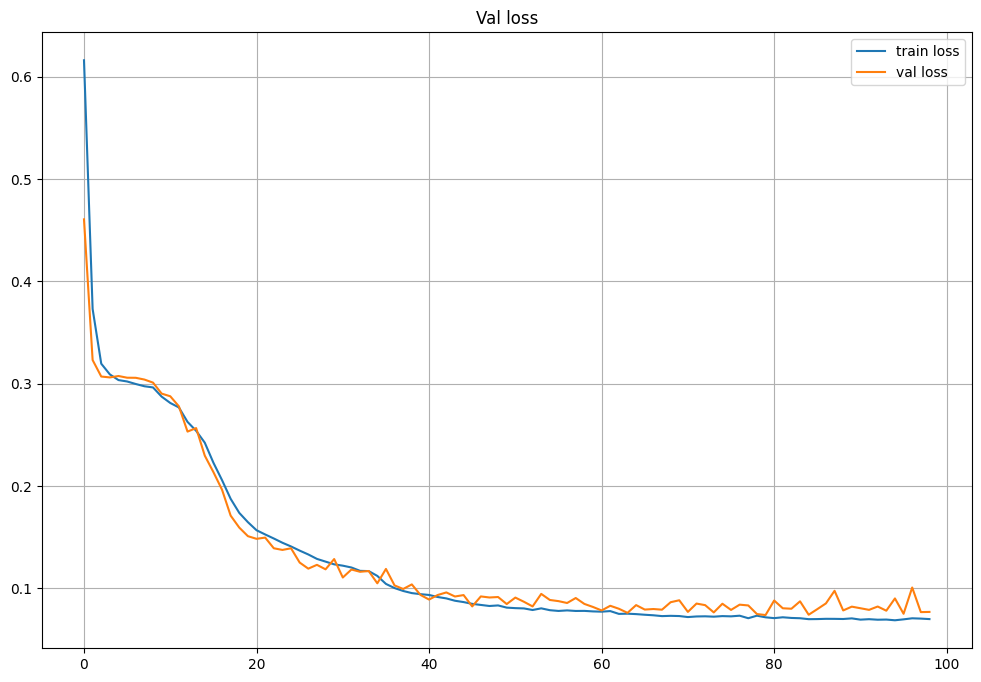

EPOCH 100:


KeyboardInterrupt: 

In [538]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 120 # formerly 1k
plt_after = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    mathNet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    train_loss.append(avg_loss)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    mathNet.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (input, t0, t1) in enumerate(validation_loader):
          input = input.to(device)
          t0 = t0.to(device)
          t1 = t1.to(device)
          y0, y1 = mathNet(input)
          vloss = loss_func(y0, y1, t0, t1)
          running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    if SPLIT_RATIO < 1:
      avg_vloss = avg_vloss.item()
    val_loss.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    if epoch % plt_after == plt_after - 1:
      plot_train(train_loss, 'loss', val_loss, 'val')

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(mathNet.state_dict(), model_path)

    epoch_number += 1

In [ ]:
# Plot training and validation data

# Testing

In [550]:
# Test the network
mathNet.eval()
null = number_to_network_input(float('nan')).to(device)
a, b, c = number_to_network_input(31).to(device), number_to_network_input(2).to(device), number_to_network_input(62).to(device)
input = torch.stack((a, b, c))
# create batch axis
input = torch.unsqueeze(input, 0)
y0, y1 = mathNet(input)
chosen_op_index = torch.argmax(y0).item()
print(f"{y0=}")
print(MATH_OPERATIONS[chosen_op_index])
print(a.tolist())
print(y1[0])
print(bits_to_float_v3(np.array(torch.round(y1[0]).tolist()).astype(int)))

y0=tensor([[-135.0523,  -26.1472,  -50.7376,   28.3882,   11.7758]],
       grad_fn=<AddmmBackward0>)
Multiplication
[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
tensor([ 0.0092, -0.0399,  0.0171,  1.0069,  0.9791,  0.9920,  0.0190, -0.0158,
        -0.0089, -0.0089,  0.0022, -0.0173,  1.0187,  1.0163, -0.0109,  0.0324],
       grad_fn=<SelectBackward0>)
[31.]


# Play

In [ ]:
# input 1 or 3 numbers, get network output
# 1. Process each number (scale by 10)
# 2. feed through network
# 3. Perform a 'max' operation of the softmax output
# 4. print the corresponding category and the constant output